In [1]:
import tensorflow as tf 
import numpy as np 
from tensorflow import keras 
import os 
import math 
import random 
import pickle 
import glob
import matplotlib.pyplot as plt 
from collections import deque 
from tensorflow.keras import layers
import time 

from vehicle_model_variant import Environment 
from cell_model import CellModel 
from driver_MDP import Driver_MDP 

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
drving_cycle = '../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat'
battery_path = "../../OC_SIM_DB/OC_SIM_DB_Bat/OC_SIM_DB_Bat_nimh_6_240_panasonic_MY01_Prius.mat"
motor_path = "../../OC_SIM_DB/OC_SIM_DB_Mot/OC_SIM_DB_Mot_pm_95_145_X2.mat"
cell_model = CellModel()
# env = Environment(cell_model, drving_cycle, battery_path, motor_path, 10)
driver = Driver_MDP(0.02)

num_states = 4

In [3]:
class OUActionNoise: 
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None): 
        self.theta = theta 
        self.mean = mean 
        self.std_dev = std_deviation 
        self.dt = dt 
        self.x_initial = x_initial 
        self.reset() 
        
    def reset(self): 
        if self.x_initial is not None: 
            self.x_prev = self.x_initial 
        else: 
            self.x_prev = 0 
            
    def __call__(self): 
        x = (
             self.x_prev + self.theta * (self.mean - self.x_prev) * self.dt 
            + self.std_dev * np.sqrt(self.dt) * np.random.normal() 
        )
        self.x_prev = x 
        return x 

In [4]:
class Buffer: 
    def __init__(self, buffer_capacity=100000, batch_size=64):      
        self.buffer_capacity = buffer_capacity 
        self.batch_size = batch_size 
        self.buffer_counter = 0 
        
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, 1))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity 

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        
        self.buffer_counter += 1 
        
    def learn(self): 
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        
        with tf.GradientTape() as tape: 
            target_actions = target_actor(next_state_batch)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions])
            critic_value = critic_model([state_batch, action_batch])
            critic_loss = tf.math.reduce_mean(tf.square(y - critic_value)) 
        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables) 
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )
        
        with tf.GradientTape() as tape: 
            actions = actor_model(state_batch)
            critic_value = critic_model([state_batch, actions])
            actor_loss = - tf.math.reduce_mean(critic_value)
        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables) 
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
        

In [5]:
def update_target(tau): 
    new_weights = [] 
    target_variables = target_critic.weights
    for i, variable in enumerate(critic_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_critic.set_weights(new_weights)
    
    new_weights = [] 
    target_variables = target_actor.weights
    for i, variable in enumerate(actor_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_actor.set_weights(new_weights)
    

In [6]:
def get_actor(): 
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    inputs = layers.Input(shape=(num_states))
    inputs_batchnorm = layers.BatchNormalization()(inputs)
    
    out = layers.Dense(512, activation="relu")(inputs_batchnorm)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1, activation="sigmoid", 
                          kernel_initializer=last_init)(out)
    model = tf.keras.Model(inputs, outputs)
    return model

In [7]:
def get_critic(): 
    state_input = layers.Input(shape=(num_states))
    state_input_batchnorm = layers.BatchNormalization()(state_input)
    
    state_out = layers.Dense(16, activation="relu")(state_input_batchnorm)
#     state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="relu")(state_out)
#     state_out = layers.BatchNormalization()(state_out)
    
    action_input = layers.Input(shape=(1))
    action_out = layers.Dense(32, activation="relu")(action_input)
#     action_out = layers.BatchNormalization()(action_out)
    
    concat = layers.Concatenate()([state_out, action_out]) 
    
    out = layers.Dense(512, activation="relu")(concat)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)
    
    model = tf.keras.Model([state_input, action_input], outputs)
    return model 
    

In [8]:
def policy(state, noise_object): 
    j_min = state[0][2].numpy()
    j_max = state[0][3].numpy()
    sampled_action = tf.squeeze(actor_model(state)) 
    noise = noise_object()
    sampled_action = sampled_action.numpy() + noise 
    legal_action = sampled_action * j_max 
    legal_action = np.clip(legal_action, j_min, j_max)
#     print(j_min, j_max, legal_action, noise)
    return legal_action 
    

In [9]:
def policy_epsilon_greedy(state, eps): 
    j_min = state[0][-2].numpy()
    j_max = state[0][-1].numpy()

    if random.random() < eps: 
        a = random.randint(0, 9)
        return np.linspace(j_min, j_max, 10)[a]
    else: 
        sampled_action = tf.squeeze(actor_model(state)).numpy()  
        legal_action = sampled_action * j_max 
        legal_action = np.clip(legal_action, j_min, j_max)
        return legal_action

In [10]:
std_dev = 0.2 
ou_noise = OUActionNoise(mean=0, std_deviation=0.2)

critic_lr = 0.0005 
actor_lr = 0.00025 
critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 400 
gamma = 0.95 
tau = 0.001 

MAX_EPSILON = 1.0 
MIN_EPSILON = 0.01 
DECAY_RATE = 0.00002
BATCH_SIZE = 32 
DELAY_TRAINING = 5000 

In [11]:
def initialization(): 
    actor_model = get_actor() 
    critic_model = get_critic() 
    target_actor = get_actor() 
    target_critic = get_critic() 
    target_actor.set_weights(actor_model.get_weights())
    target_critic.set_weights(critic_model.get_weights())
#     actor_model.load_weights("./DDPG1_trial1/actor_model_checkpoint")
#     critic_model.load_weights("./DDPG1_trial1/critic_model_checkpoint")
#     target_actor.load_weights("./DDPG1_trial1/target_actor_checkpoint")
#     target_critic.load_weights("./DDPG1_trial1/target_critic_checkpoint")
    
    buffer = Buffer(500000, BATCH_SIZE)
    return actor_model, critic_model, target_actor, target_critic, buffer

In [12]:
def save_weights(actor_model, critic_model, target_actor, target_critic, root): 
    if not os.path.exists(root): 
        os.makedirs(root)
        
    actor_model.save_weights("./{}/actor_model.h5".format(root))
    critic_model.save_weights("./{}/critic_model.h5".format(root))
    target_actor.save_weights("./{}/target_actor.h5".format(root))
    target_critic.save_weights("./{}/target_critic.h5".format(root))
    print("model is saved..")

In [13]:
def initialization_env(driving_path, reward_factor):
    env = Environment(cell_model, driving_path, battery_path, motor_path, reward_factor)
    return env 

In [14]:
def test_agent(actor_model, reward_factor):
    test_cycle = driver.get_cycle() 
    env = initialization_env(test_cycle, reward_factor)
    
    total_reward = 0
    state = env.reset() 
    while True: 
        tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        action = policy_epsilon_greedy(tf_state, -1)
        next_state, reward, done = env.step(action)
        
        state = next_state 
        total_reward += reward 
        
        if done: 
            break 
        
    SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
    
    print("******************* Test is start *****************")
#     print(test_cycle)
    print('Total reward: {}'.format(total_reward), 
          "SOC: {:.4f}".format(env.SOC), 
          "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
          "Fuel Consumption: {:.4f}".format(env.fuel_consumption))
    print("******************* Test is done *****************")
    print("")
    plt.subplot(1, 2, 1)
    plt.plot(test_cycle)
    plt.subplot(1, 2, 2)
    plt.plot(env.history["Action"])
    plt.show() 
    return env.history  
    


Trial 7



C:\Users\RECL\Desktop\Song\graduate_paper\program\experiment\DDPG_rewardfactor_comparison\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\RECL\Desktop\Song\graduate_paper\program\experiment\DDPG_rewardfactor_comparison\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 6.689
Episode: 1 Exploration P: 1.0000 Total reward: -2580.058757277282 SOC: 1.0000 Cumulative_SOC_deviation: 352.7698 Fuel Consumption: 110.6704

maximum steps, simulation is done ... 
elapsed_time: 6.769
Episode: 2 Exploration P: 1.0000 Total reward: -2577.6640949816397 SOC: 1.0000 Cumulative_SOC_deviation: 353.9503 Fuel Consumption: 100.0118

maximum steps, simulation is done ... 
elapsed_time: 6.599
Episode: 3 Exploration P: 1.0000 Total reward: -2540.985113724691 SOC: 1.0000 Cumulative_SOC_deviation: 348.9655 Fuel Consumption: 98.2267

maximum steps, simulation is done ... 
elapsed_time: 6.731
Episode: 4 Exploration P: 1.0000 Total reward: -2593.746276963055 SOC: 1.0000 Cumulative_SOC_deviation: 356.3097 Fuel Consumption: 99.5784


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To chang

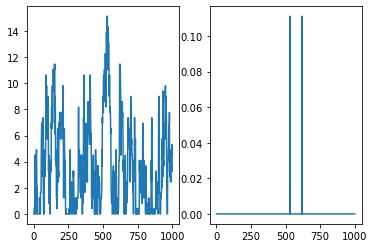

maximum steps, simulation is done ... 
elapsed_time: 49.771
Episode: 11 Exploration P: 0.8879 Total reward: -2519.330187344867 SOC: 1.0000 Cumulative_SOC_deviation: 346.5883 Fuel Consumption: 93.2121

maximum steps, simulation is done ... 
elapsed_time: 50.396
Episode: 12 Exploration P: 0.8705 Total reward: -2526.3115919454535 SOC: 1.0000 Cumulative_SOC_deviation: 348.3433 Fuel Consumption: 87.9086

maximum steps, simulation is done ... 
elapsed_time: 51.592
Episode: 13 Exploration P: 0.8534 Total reward: -2497.994718447241 SOC: 0.9997 Cumulative_SOC_deviation: 344.3806 Fuel Consumption: 87.3308

maximum steps, simulation is done ... 
elapsed_time: 51.099
Episode: 14 Exploration P: 0.8367 Total reward: -2467.321751849372 SOC: 0.9994 Cumulative_SOC_deviation: 340.2080 Fuel Consumption: 85.8656

maximum steps, simulation is done ... 
elapsed_time: 50.381
Episode: 15 Exploration P: 0.8203 Total reward: -2430.8408911651345 SOC: 0.9499 Cumulative_SOC_deviation: 332.5127 Fuel Consumption: 10

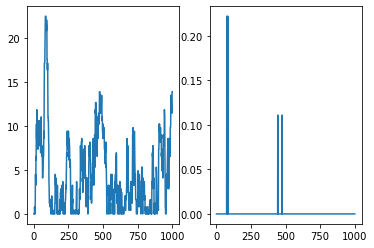

maximum steps, simulation is done ... 
elapsed_time: 51.571
Episode: 21 Exploration P: 0.7286 Total reward: -2433.889795867695 SOC: 1.0000 Cumulative_SOC_deviation: 336.2958 Fuel Consumption: 79.8192

maximum steps, simulation is done ... 
elapsed_time: 51.060
Episode: 22 Exploration P: 0.7144 Total reward: -2394.5488844352262 SOC: 1.0000 Cumulative_SOC_deviation: 330.6654 Fuel Consumption: 79.8914

maximum steps, simulation is done ... 
elapsed_time: 50.585
Episode: 23 Exploration P: 0.7004 Total reward: -2464.590023651961 SOC: 1.0000 Cumulative_SOC_deviation: 340.6874 Fuel Consumption: 79.7779

maximum steps, simulation is done ... 
elapsed_time: 50.635
Episode: 24 Exploration P: 0.6867 Total reward: -2314.3969258710317 SOC: 1.0000 Cumulative_SOC_deviation: 320.7009 Fuel Consumption: 69.4907

maximum steps, simulation is done ... 
elapsed_time: 50.310
Episode: 25 Exploration P: 0.6733 Total reward: -2362.4906740511633 SOC: 0.9999 Cumulative_SOC_deviation: 327.0835 Fuel Consumption: 7

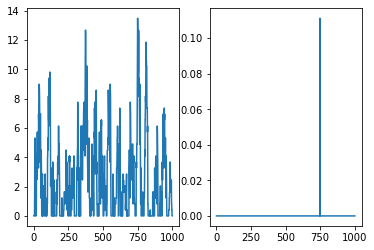

maximum steps, simulation is done ... 
elapsed_time: 50.844
Episode: 31 Exploration P: 0.5982 Total reward: -2333.468286689037 SOC: 1.0000 Cumulative_SOC_deviation: 324.0386 Fuel Consumption: 65.1984

maximum steps, simulation is done ... 
elapsed_time: 50.786
Episode: 32 Exploration P: 0.5866 Total reward: -2375.2452595195514 SOC: 1.0000 Cumulative_SOC_deviation: 329.8947 Fuel Consumption: 65.9825

maximum steps, simulation is done ... 
elapsed_time: 50.785
Episode: 33 Exploration P: 0.5751 Total reward: -2338.4820241911466 SOC: 1.0000 Cumulative_SOC_deviation: 324.8388 Fuel Consumption: 64.6102

maximum steps, simulation is done ... 
elapsed_time: 50.498
Episode: 34 Exploration P: 0.5639 Total reward: -2227.7652997926057 SOC: 0.9358 Cumulative_SOC_deviation: 308.4856 Fuel Consumption: 68.3660

maximum steps, simulation is done ... 
elapsed_time: 50.635
Episode: 35 Exploration P: 0.5530 Total reward: -2298.650659599602 SOC: 1.0000 Cumulative_SOC_deviation: 318.9437 Fuel Consumption: 6

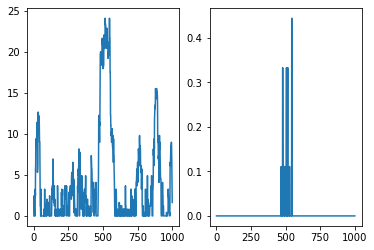

maximum steps, simulation is done ... 
elapsed_time: 50.524
Episode: 41 Exploration P: 0.4915 Total reward: -2293.6322562873133 SOC: 1.0000 Cumulative_SOC_deviation: 319.5859 Fuel Consumption: 56.5311

maximum steps, simulation is done ... 
elapsed_time: 50.531
Episode: 42 Exploration P: 0.4820 Total reward: -2015.1978002218145 SOC: 1.0000 Cumulative_SOC_deviation: 279.6990 Fuel Consumption: 57.3050

maximum steps, simulation is done ... 
elapsed_time: 50.450
Episode: 43 Exploration P: 0.4726 Total reward: -2168.173862030535 SOC: 1.0000 Cumulative_SOC_deviation: 302.0391 Fuel Consumption: 53.9000

maximum steps, simulation is done ... 
elapsed_time: 50.576
Episode: 44 Exploration P: 0.4634 Total reward: -2091.498700977694 SOC: 0.9999 Cumulative_SOC_deviation: 290.6477 Fuel Consumption: 56.9645

maximum steps, simulation is done ... 
elapsed_time: 50.753
Episode: 45 Exploration P: 0.4544 Total reward: -2117.3045027831304 SOC: 1.0000 Cumulative_SOC_deviation: 294.7780 Fuel Consumption: 5

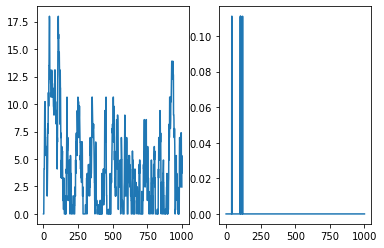

maximum steps, simulation is done ... 
elapsed_time: 50.657
Episode: 51 Exploration P: 0.4041 Total reward: -2053.5108484611123 SOC: 0.9943 Cumulative_SOC_deviation: 286.0935 Fuel Consumption: 50.8562

maximum steps, simulation is done ... 
elapsed_time: 50.695
Episode: 52 Exploration P: 0.3963 Total reward: -2046.0786122696359 SOC: 0.9998 Cumulative_SOC_deviation: 285.5197 Fuel Consumption: 47.4408

maximum steps, simulation is done ... 
elapsed_time: 50.794
Episode: 53 Exploration P: 0.3887 Total reward: -2015.587901320365 SOC: 0.9860 Cumulative_SOC_deviation: 281.3614 Fuel Consumption: 46.0582

maximum steps, simulation is done ... 
elapsed_time: 50.854
Episode: 54 Exploration P: 0.3812 Total reward: -1994.2946018710745 SOC: 1.0000 Cumulative_SOC_deviation: 278.1190 Fuel Consumption: 47.4615

maximum steps, simulation is done ... 
elapsed_time: 50.525
Episode: 55 Exploration P: 0.3738 Total reward: -1876.2397952683423 SOC: 1.0000 Cumulative_SOC_deviation: 261.5090 Fuel Consumption: 

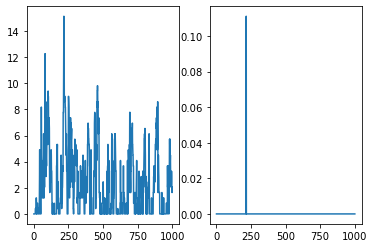

maximum steps, simulation is done ... 
elapsed_time: 51.027
Episode: 61 Exploration P: 0.3326 Total reward: -1784.370759471526 SOC: 0.9994 Cumulative_SOC_deviation: 248.7564 Fuel Consumption: 43.0763

maximum steps, simulation is done ... 
elapsed_time: 51.648
Episode: 62 Exploration P: 0.3262 Total reward: -1526.7545368212134 SOC: 1.0000 Cumulative_SOC_deviation: 212.4508 Fuel Consumption: 39.5991

maximum steps, simulation is done ... 
elapsed_time: 51.081
Episode: 63 Exploration P: 0.3200 Total reward: -1745.3048104447225 SOC: 1.0000 Cumulative_SOC_deviation: 243.1460 Fuel Consumption: 43.2826

maximum steps, simulation is done ... 
elapsed_time: 51.280
Episode: 64 Exploration P: 0.3138 Total reward: -1466.1276037997031 SOC: 0.9681 Cumulative_SOC_deviation: 203.9166 Fuel Consumption: 38.7117

maximum steps, simulation is done ... 
elapsed_time: 50.846
Episode: 65 Exploration P: 0.3078 Total reward: -1631.6185613197183 SOC: 0.9987 Cumulative_SOC_deviation: 227.0216 Fuel Consumption: 

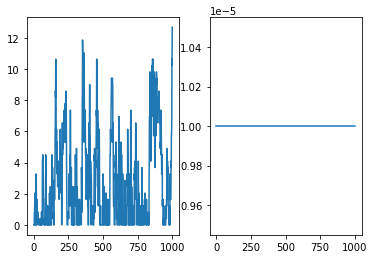

maximum steps, simulation is done ... 
elapsed_time: 50.840
Episode: 71 Exploration P: 0.2741 Total reward: -1436.401348238249 SOC: 0.9793 Cumulative_SOC_deviation: 199.8218 Fuel Consumption: 37.6489

maximum steps, simulation is done ... 
elapsed_time: 51.140
Episode: 72 Exploration P: 0.2689 Total reward: -1191.022215842889 SOC: 0.9363 Cumulative_SOC_deviation: 164.8782 Fuel Consumption: 36.8751

maximum steps, simulation is done ... 
elapsed_time: 51.180
Episode: 73 Exploration P: 0.2637 Total reward: -1174.9565355975717 SOC: 0.8986 Cumulative_SOC_deviation: 162.4357 Fuel Consumption: 37.9069

maximum steps, simulation is done ... 
elapsed_time: 50.925
Episode: 74 Exploration P: 0.2587 Total reward: -1082.4226188698533 SOC: 0.9240 Cumulative_SOC_deviation: 149.3728 Fuel Consumption: 36.8132

battery power is 68459.81413929342(+) but condition is not avail
elapsed_time: 4.835
Episode: 75 Exploration P: 0.2582 Total reward: -1009.7373535963673 SOC: 0.5549 Cumulative_SOC_deviation: 0.6

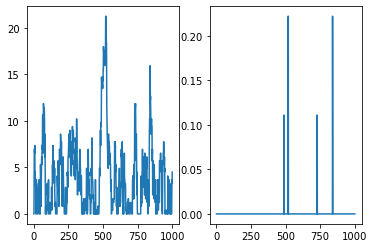

maximum steps, simulation is done ... 
elapsed_time: 50.087
Episode: 81 Exploration P: 0.2301 Total reward: -1383.4013803494129 SOC: 0.9379 Cumulative_SOC_deviation: 192.3314 Fuel Consumption: 37.0814

maximum steps, simulation is done ... 
elapsed_time: 51.808
Episode: 82 Exploration P: 0.2258 Total reward: -951.9623008172997 SOC: 0.8631 Cumulative_SOC_deviation: 131.1483 Fuel Consumption: 33.9241

maximum steps, simulation is done ... 
elapsed_time: 52.388
Episode: 83 Exploration P: 0.2215 Total reward: -1117.0931295314817 SOC: 0.9014 Cumulative_SOC_deviation: 154.4967 Fuel Consumption: 35.6163

maximum steps, simulation is done ... 
elapsed_time: 51.818
Episode: 84 Exploration P: 0.2173 Total reward: -809.8840809060393 SOC: 0.6600 Cumulative_SOC_deviation: 110.5227 Fuel Consumption: 36.2250

maximum steps, simulation is done ... 
elapsed_time: 51.684
Episode: 85 Exploration P: 0.2132 Total reward: -1149.8654445504253 SOC: 0.8992 Cumulative_SOC_deviation: 159.4762 Fuel Consumption: 3

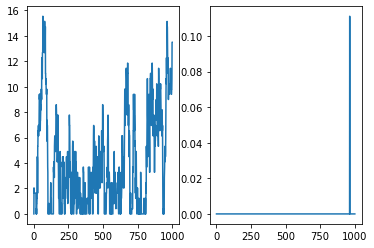

maximum steps, simulation is done ... 
elapsed_time: 49.808
Episode: 91 Exploration P: 0.1902 Total reward: -797.5635452651337 SOC: 0.7740 Cumulative_SOC_deviation: 109.8239 Fuel Consumption: 28.7960

maximum steps, simulation is done ... 
elapsed_time: 51.296
Episode: 92 Exploration P: 0.1866 Total reward: -885.7116234729975 SOC: 0.8358 Cumulative_SOC_deviation: 123.1697 Fuel Consumption: 23.5234

maximum steps, simulation is done ... 
elapsed_time: 51.295
Episode: 93 Exploration P: 0.1831 Total reward: -1093.1700269828043 SOC: 0.8804 Cumulative_SOC_deviation: 151.9650 Fuel Consumption: 29.4151

maximum steps, simulation is done ... 
elapsed_time: 50.911
Episode: 94 Exploration P: 0.1797 Total reward: -451.6784387554989 SOC: 0.7279 Cumulative_SOC_deviation: 61.0677 Fuel Consumption: 24.2044

maximum steps, simulation is done ... 
elapsed_time: 51.239
Episode: 95 Exploration P: 0.1763 Total reward: -747.1254713315051 SOC: 0.7499 Cumulative_SOC_deviation: 102.9000 Fuel Consumption: 26.8

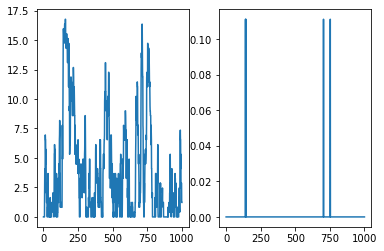

maximum steps, simulation is done ... 
elapsed_time: 50.316
Episode: 101 Exploration P: 0.1575 Total reward: -289.89821621058184 SOC: 0.6429 Cumulative_SOC_deviation: 37.4949 Fuel Consumption: 27.4340

maximum steps, simulation is done ... 
elapsed_time: 51.934
Episode: 102 Exploration P: 0.1546 Total reward: -504.5216507351887 SOC: 0.7206 Cumulative_SOC_deviation: 69.0015 Fuel Consumption: 21.5114

maximum steps, simulation is done ... 
elapsed_time: 52.007
Episode: 103 Exploration P: 0.1517 Total reward: -647.8072875644308 SOC: 0.7535 Cumulative_SOC_deviation: 89.1377 Fuel Consumption: 23.8433

maximum steps, simulation is done ... 
elapsed_time: 51.624
Episode: 104 Exploration P: 0.1489 Total reward: -607.5910425759308 SOC: 0.7538 Cumulative_SOC_deviation: 83.4412 Fuel Consumption: 23.5028

maximum steps, simulation is done ... 
elapsed_time: 51.869
Episode: 105 Exploration P: 0.1462 Total reward: -398.71322625377763 SOC: 0.7079 Cumulative_SOC_deviation: 53.6236 Fuel Consumption: 23

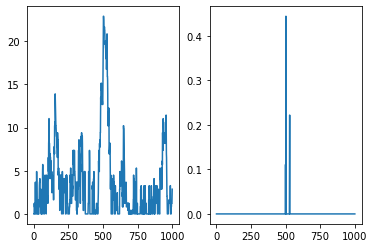

maximum steps, simulation is done ... 
elapsed_time: 50.076
Episode: 111 Exploration P: 0.1307 Total reward: -258.1468517002061 SOC: 0.6600 Cumulative_SOC_deviation: 33.8817 Fuel Consumption: 20.9748

maximum steps, simulation is done ... 
elapsed_time: 51.134
Episode: 112 Exploration P: 0.1283 Total reward: -262.2928506111187 SOC: 0.6877 Cumulative_SOC_deviation: 34.5890 Fuel Consumption: 20.1700

maximum steps, simulation is done ... 
elapsed_time: 50.637
Episode: 113 Exploration P: 0.1260 Total reward: -311.2898797659668 SOC: 0.7027 Cumulative_SOC_deviation: 41.2805 Fuel Consumption: 22.3265

maximum steps, simulation is done ... 
elapsed_time: 51.008
Episode: 114 Exploration P: 0.1237 Total reward: -295.19994885075386 SOC: 0.6639 Cumulative_SOC_deviation: 39.3283 Fuel Consumption: 19.9017

maximum steps, simulation is done ... 
elapsed_time: 51.279
Episode: 115 Exploration P: 0.1214 Total reward: -511.25286566878793 SOC: 0.7423 Cumulative_SOC_deviation: 70.2151 Fuel Consumption: 19

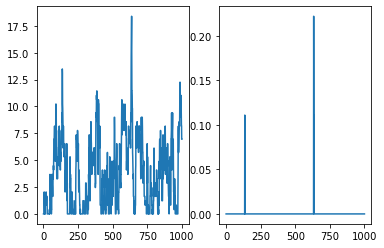

maximum steps, simulation is done ... 
elapsed_time: 50.377
Episode: 121 Exploration P: 0.1088 Total reward: -331.24069682646996 SOC: 0.6643 Cumulative_SOC_deviation: 44.9693 Fuel Consumption: 16.4555

maximum steps, simulation is done ... 
elapsed_time: 51.386
Episode: 122 Exploration P: 0.1069 Total reward: -343.8059436930543 SOC: 0.6670 Cumulative_SOC_deviation: 47.1417 Fuel Consumption: 13.8140

maximum steps, simulation is done ... 
elapsed_time: 51.392
Episode: 123 Exploration P: 0.1050 Total reward: -418.9068794072368 SOC: 0.5147 Cumulative_SOC_deviation: 58.0311 Fuel Consumption: 12.6894

maximum steps, simulation is done ... 
elapsed_time: 51.453
Episode: 124 Exploration P: 0.1031 Total reward: -249.4534601857317 SOC: 0.6723 Cumulative_SOC_deviation: 33.4800 Fuel Consumption: 15.0935

maximum steps, simulation is done ... 
elapsed_time: 51.505
Episode: 125 Exploration P: 0.1012 Total reward: -366.2614050063455 SOC: 0.5555 Cumulative_SOC_deviation: 49.1468 Fuel Consumption: 22.

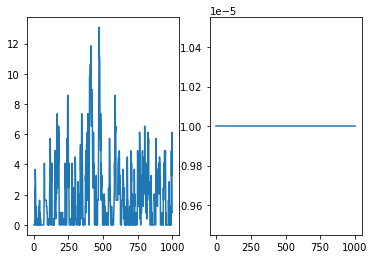

maximum steps, simulation is done ... 
elapsed_time: 49.806
Episode: 131 Exploration P: 0.0917 Total reward: -263.6057550493243 SOC: 0.6897 Cumulative_SOC_deviation: 35.2806 Fuel Consumption: 16.6412

maximum steps, simulation is done ... 
elapsed_time: 51.487
Episode: 132 Exploration P: 0.0901 Total reward: -270.1907372828195 SOC: 0.4532 Cumulative_SOC_deviation: 35.9737 Fuel Consumption: 18.3747

maximum steps, simulation is done ... 
elapsed_time: 51.782
Episode: 133 Exploration P: 0.0885 Total reward: -92.9803383714019 SOC: 0.6348 Cumulative_SOC_deviation: 11.2564 Fuel Consumption: 14.1855

maximum steps, simulation is done ... 
elapsed_time: 51.010
Episode: 134 Exploration P: 0.0869 Total reward: -144.8166868695322 SOC: 0.5962 Cumulative_SOC_deviation: 18.6041 Fuel Consumption: 14.5879

maximum steps, simulation is done ... 
elapsed_time: 51.274
Episode: 135 Exploration P: 0.0854 Total reward: -249.70620030447444 SOC: 0.6076 Cumulative_SOC_deviation: 33.9436 Fuel Consumption: 12.1

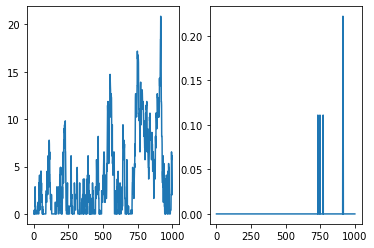

maximum steps, simulation is done ... 
elapsed_time: 49.667
Episode: 141 Exploration P: 0.0769 Total reward: -186.85642986215353 SOC: 0.5636 Cumulative_SOC_deviation: 24.6201 Fuel Consumption: 14.5157

battery power is 117962.07876046178(+) but condition is not avail
elapsed_time: 29.035
Episode: 142 Exploration P: 0.0761 Total reward: -1406.6178091772779 SOC: 0.2111 Cumulative_SOC_deviation: 56.0886 Fuel Consumption: 16.7201

maximum steps, simulation is done ... 
elapsed_time: 51.218
Episode: 143 Exploration P: 0.0748 Total reward: -267.6919531158965 SOC: 0.6656 Cumulative_SOC_deviation: 36.3110 Fuel Consumption: 13.5148

maximum steps, simulation is done ... 
elapsed_time: 51.000
Episode: 144 Exploration P: 0.0735 Total reward: -92.90377672511761 SOC: 0.6107 Cumulative_SOC_deviation: 11.7245 Fuel Consumption: 10.8321

maximum steps, simulation is done ... 
elapsed_time: 51.061
Episode: 145 Exploration P: 0.0723 Total reward: -238.69243548819264 SOC: 0.4607 Cumulative_SOC_deviation: 

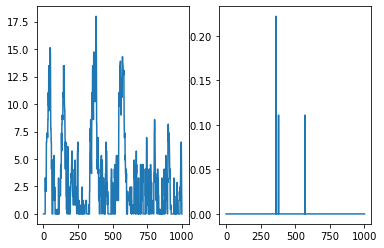

maximum steps, simulation is done ... 
elapsed_time: 49.813
Episode: 151 Exploration P: 0.0652 Total reward: -415.873787046432 SOC: 0.7073 Cumulative_SOC_deviation: 57.3737 Fuel Consumption: 14.2577

maximum steps, simulation is done ... 
elapsed_time: 51.616
Episode: 152 Exploration P: 0.0641 Total reward: -228.48764893804417 SOC: 0.5718 Cumulative_SOC_deviation: 30.7428 Fuel Consumption: 13.2878

maximum steps, simulation is done ... 
elapsed_time: 51.460
Episode: 153 Exploration P: 0.0630 Total reward: -290.9791957537931 SOC: 0.5342 Cumulative_SOC_deviation: 40.4190 Fuel Consumption: 8.0462

maximum steps, simulation is done ... 
elapsed_time: 51.938
Episode: 154 Exploration P: 0.0620 Total reward: -111.80360358532732 SOC: 0.5919 Cumulative_SOC_deviation: 14.5306 Fuel Consumption: 10.0892

maximum steps, simulation is done ... 
elapsed_time: 51.397
Episode: 155 Exploration P: 0.0610 Total reward: -580.8048720797635 SOC: 0.4560 Cumulative_SOC_deviation: 81.1726 Fuel Consumption: 12.5

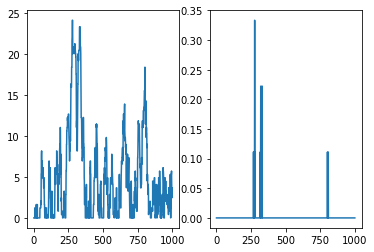

maximum steps, simulation is done ... 
elapsed_time: 50.092
Episode: 161 Exploration P: 0.0552 Total reward: -571.9668297577027 SOC: 0.4472 Cumulative_SOC_deviation: 80.2034 Fuel Consumption: 10.5432

maximum steps, simulation is done ... 
elapsed_time: 51.545
Episode: 162 Exploration P: 0.0543 Total reward: -155.38780217825087 SOC: 0.5355 Cumulative_SOC_deviation: 20.9412 Fuel Consumption: 8.7994

maximum steps, simulation is done ... 
elapsed_time: 51.783
Episode: 163 Exploration P: 0.0534 Total reward: -241.32878329178885 SOC: 0.4706 Cumulative_SOC_deviation: 33.2981 Fuel Consumption: 8.2422

maximum steps, simulation is done ... 
elapsed_time: 52.115
Episode: 164 Exploration P: 0.0526 Total reward: -76.0346477947226 SOC: 0.6013 Cumulative_SOC_deviation: 9.6655 Fuel Consumption: 8.3764

maximum steps, simulation is done ... 
elapsed_time: 51.811
Episode: 165 Exploration P: 0.0517 Total reward: -40.14450394464907 SOC: 0.6100 Cumulative_SOC_deviation: 4.7137 Fuel Consumption: 7.1485



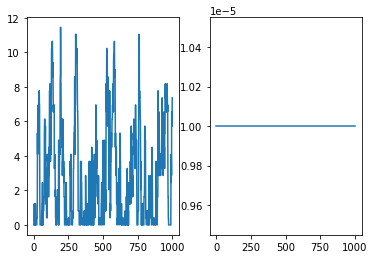

maximum steps, simulation is done ... 
elapsed_time: 49.355
Episode: 171 Exploration P: 0.0470 Total reward: -382.5702856335579 SOC: 0.5271 Cumulative_SOC_deviation: 53.4961 Fuel Consumption: 8.0978

maximum steps, simulation is done ... 
elapsed_time: 51.424
Episode: 172 Exploration P: 0.0463 Total reward: -379.3458791291614 SOC: 0.3367 Cumulative_SOC_deviation: 52.1717 Fuel Consumption: 14.1442

maximum steps, simulation is done ... 
elapsed_time: 51.344
Episode: 173 Exploration P: 0.0455 Total reward: -185.60836871024247 SOC: 0.5398 Cumulative_SOC_deviation: 25.4383 Fuel Consumption: 7.5406

maximum steps, simulation is done ... 
elapsed_time: 51.118
Episode: 174 Exploration P: 0.0448 Total reward: -171.88730188481938 SOC: 0.5867 Cumulative_SOC_deviation: 23.3911 Fuel Consumption: 8.1494

maximum steps, simulation is done ... 
elapsed_time: 51.053
Episode: 175 Exploration P: 0.0441 Total reward: -111.24803862015786 SOC: 0.5565 Cumulative_SOC_deviation: 15.0468 Fuel Consumption: 5.92

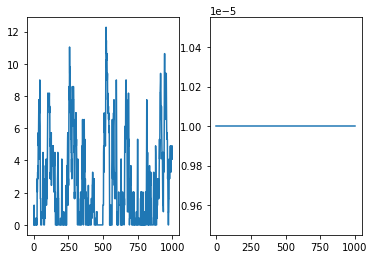

maximum steps, simulation is done ... 
elapsed_time: 49.417
Episode: 181 Exploration P: 0.0403 Total reward: -184.61248545647086 SOC: 0.4842 Cumulative_SOC_deviation: 25.2532 Fuel Consumption: 7.8398

maximum steps, simulation is done ... 
elapsed_time: 51.162
Episode: 182 Exploration P: 0.0397 Total reward: -85.76752260519937 SOC: 0.5853 Cumulative_SOC_deviation: 11.2844 Fuel Consumption: 6.7771

maximum steps, simulation is done ... 
elapsed_time: 51.108
Episode: 183 Exploration P: 0.0391 Total reward: -1772.034029108287 SOC: 0.2210 Cumulative_SOC_deviation: 251.5531 Fuel Consumption: 11.1623

maximum steps, simulation is done ... 
elapsed_time: 51.229
Episode: 184 Exploration P: 0.0385 Total reward: -332.71728518981826 SOC: 0.4903 Cumulative_SOC_deviation: 46.6145 Fuel Consumption: 6.4159

maximum steps, simulation is done ... 
elapsed_time: 51.192
Episode: 185 Exploration P: 0.0379 Total reward: -399.9797740090984 SOC: 0.5313 Cumulative_SOC_deviation: 56.3133 Fuel Consumption: 5.78

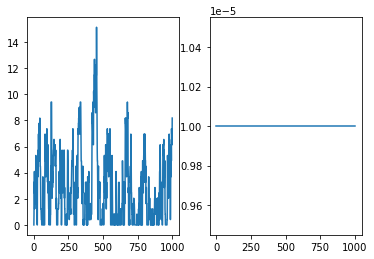

maximum steps, simulation is done ... 
elapsed_time: 49.827
Episode: 191 Exploration P: 0.0348 Total reward: -512.3106185850341 SOC: 0.4947 Cumulative_SOC_deviation: 72.5389 Fuel Consumption: 4.5380

maximum steps, simulation is done ... 
elapsed_time: 51.233
Episode: 192 Exploration P: 0.0343 Total reward: -281.1965864885155 SOC: 0.5108 Cumulative_SOC_deviation: 39.3649 Fuel Consumption: 5.6421

maximum steps, simulation is done ... 
elapsed_time: 51.186
Episode: 193 Exploration P: 0.0338 Total reward: -405.31201410017104 SOC: 0.4943 Cumulative_SOC_deviation: 56.9498 Fuel Consumption: 6.6636

maximum steps, simulation is done ... 
elapsed_time: 51.589
Episode: 194 Exploration P: 0.0333 Total reward: -134.38734806827074 SOC: 0.5693 Cumulative_SOC_deviation: 18.4010 Fuel Consumption: 5.5802

maximum steps, simulation is done ... 
elapsed_time: 51.452
Episode: 195 Exploration P: 0.0329 Total reward: -119.31305052432705 SOC: 0.5767 Cumulative_SOC_deviation: 16.1517 Fuel Consumption: 6.250

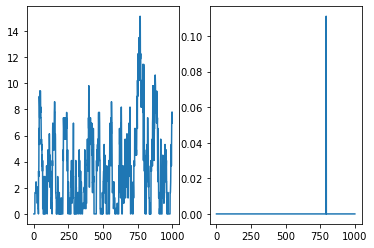

maximum steps, simulation is done ... 
elapsed_time: 49.638
Episode: 201 Exploration P: 0.0303 Total reward: -282.4324611955339 SOC: 0.5083 Cumulative_SOC_deviation: 39.6329 Fuel Consumption: 5.0023

maximum steps, simulation is done ... 
elapsed_time: 51.202
Episode: 202 Exploration P: 0.0299 Total reward: -182.15717089277672 SOC: 0.5474 Cumulative_SOC_deviation: 25.5334 Fuel Consumption: 3.4237

maximum steps, simulation is done ... 
elapsed_time: 51.298
Episode: 203 Exploration P: 0.0295 Total reward: -132.30911366209878 SOC: 0.5485 Cumulative_SOC_deviation: 18.0923 Fuel Consumption: 5.6627

maximum steps, simulation is done ... 
elapsed_time: 51.121
Episode: 204 Exploration P: 0.0291 Total reward: -292.2871909765181 SOC: 0.5405 Cumulative_SOC_deviation: 41.0761 Fuel Consumption: 4.7547

maximum steps, simulation is done ... 
elapsed_time: 51.492
Episode: 205 Exploration P: 0.0287 Total reward: -276.72602374236124 SOC: 0.5456 Cumulative_SOC_deviation: 38.9621 Fuel Consumption: 3.991

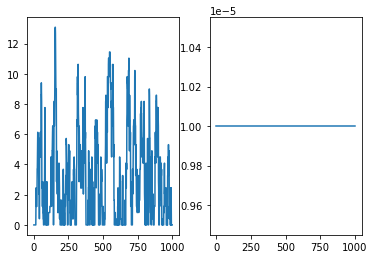

maximum steps, simulation is done ... 
elapsed_time: 49.584
Episode: 211 Exploration P: 0.0266 Total reward: -356.84563648238486 SOC: 0.4964 Cumulative_SOC_deviation: 50.4343 Fuel Consumption: 3.8054

maximum steps, simulation is done ... 
elapsed_time: 51.073
Episode: 212 Exploration P: 0.0263 Total reward: -353.50612808226884 SOC: 0.5056 Cumulative_SOC_deviation: 49.9425 Fuel Consumption: 3.9086

maximum steps, simulation is done ... 
elapsed_time: 50.885
Episode: 213 Exploration P: 0.0260 Total reward: -173.34820944694894 SOC: 0.5384 Cumulative_SOC_deviation: 24.1261 Fuel Consumption: 4.4658

maximum steps, simulation is done ... 
elapsed_time: 50.678
Episode: 214 Exploration P: 0.0256 Total reward: -488.27409605755724 SOC: 0.4089 Cumulative_SOC_deviation: 69.0550 Fuel Consumption: 4.8888

maximum steps, simulation is done ... 
elapsed_time: 51.015
Episode: 215 Exploration P: 0.0253 Total reward: -697.7202500782437 SOC: 0.2216 Cumulative_SOC_deviation: 97.8984 Fuel Consumption: 12.4

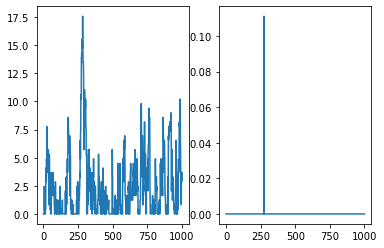

maximum steps, simulation is done ... 
elapsed_time: 50.677
Episode: 221 Exploration P: 0.0236 Total reward: -279.82561762249776 SOC: 0.5285 Cumulative_SOC_deviation: 39.7086 Fuel Consumption: 1.8656

maximum steps, simulation is done ... 
elapsed_time: 51.464
Episode: 222 Exploration P: 0.0233 Total reward: -890.4334198934906 SOC: 0.2600 Cumulative_SOC_deviation: 126.4002 Fuel Consumption: 5.6318

maximum steps, simulation is done ... 
elapsed_time: 51.160
Episode: 223 Exploration P: 0.0231 Total reward: -136.59027644126093 SOC: 0.5719 Cumulative_SOC_deviation: 19.0783 Fuel Consumption: 3.0419

maximum steps, simulation is done ... 
elapsed_time: 52.949
Episode: 224 Exploration P: 0.0228 Total reward: -372.5165908213743 SOC: 0.4795 Cumulative_SOC_deviation: 52.4195 Fuel Consumption: 5.5802

maximum steps, simulation is done ... 
elapsed_time: 50.895
Episode: 225 Exploration P: 0.0225 Total reward: -715.5638189963965 SOC: 0.4365 Cumulative_SOC_deviation: 101.4292 Fuel Consumption: 5.55

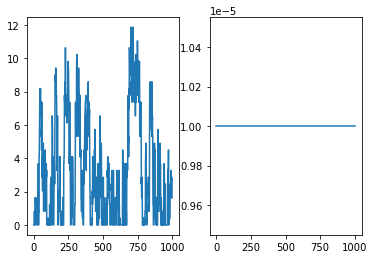

maximum steps, simulation is done ... 
elapsed_time: 50.635
Episode: 231 Exploration P: 0.0211 Total reward: -164.51918880093982 SOC: 0.5510 Cumulative_SOC_deviation: 23.0726 Fuel Consumption: 3.0109

maximum steps, simulation is done ... 
elapsed_time: 51.704
Episode: 232 Exploration P: 0.0209 Total reward: -310.3306455002132 SOC: 0.4310 Cumulative_SOC_deviation: 43.8365 Fuel Consumption: 3.4753

maximum steps, simulation is done ... 
elapsed_time: 51.467
Episode: 233 Exploration P: 0.0207 Total reward: -396.2404208370931 SOC: 0.4761 Cumulative_SOC_deviation: 56.2759 Fuel Consumption: 2.3093

maximum steps, simulation is done ... 
elapsed_time: 51.285
Episode: 234 Exploration P: 0.0205 Total reward: -160.52764305801102 SOC: 0.5427 Cumulative_SOC_deviation: 22.5201 Fuel Consumption: 2.8871

battery power is 111014.03996170503(+) but condition is not avail
elapsed_time: 29.537
Episode: 235 Exploration P: 0.0204 Total reward: -1144.7427804555352 SOC: 0.2859 Cumulative_SOC_deviation: 19.4

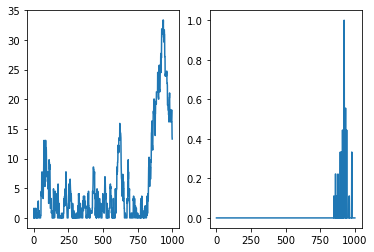

maximum steps, simulation is done ... 
elapsed_time: 50.686
Episode: 241 Exploration P: 0.0192 Total reward: -561.1339531131597 SOC: 0.4349 Cumulative_SOC_deviation: 79.7923 Fuel Consumption: 2.5879

maximum steps, simulation is done ... 
elapsed_time: 51.134
Episode: 242 Exploration P: 0.0190 Total reward: -581.534315142052 SOC: 0.4153 Cumulative_SOC_deviation: 82.5121 Fuel Consumption: 3.9499

maximum steps, simulation is done ... 
elapsed_time: 51.301
Episode: 243 Exploration P: 0.0188 Total reward: -556.4086886259178 SOC: 0.4303 Cumulative_SOC_deviation: 78.7119 Fuel Consumption: 5.4254

maximum steps, simulation is done ... 
elapsed_time: 51.284
Episode: 244 Exploration P: 0.0187 Total reward: -830.0060544526362 SOC: 0.3995 Cumulative_SOC_deviation: 117.9373 Fuel Consumption: 4.4452

maximum steps, simulation is done ... 
elapsed_time: 51.472
Episode: 245 Exploration P: 0.0185 Total reward: -499.9672452116466 SOC: 0.4808 Cumulative_SOC_deviation: 71.1161 Fuel Consumption: 2.1545



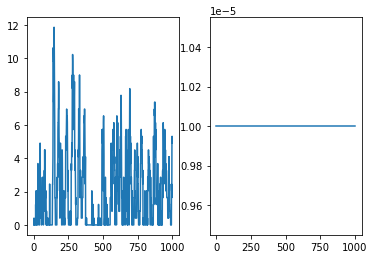

maximum steps, simulation is done ... 
elapsed_time: 50.242
Episode: 251 Exploration P: 0.0175 Total reward: -343.20352145224246 SOC: 0.4985 Cumulative_SOC_deviation: 48.6122 Fuel Consumption: 2.9181

maximum steps, simulation is done ... 
elapsed_time: 50.811
Episode: 252 Exploration P: 0.0174 Total reward: -231.91539277506683 SOC: 0.5430 Cumulative_SOC_deviation: 32.8377 Fuel Consumption: 2.0514

maximum steps, simulation is done ... 
elapsed_time: 50.987
Episode: 253 Exploration P: 0.0172 Total reward: -1077.2210966779924 SOC: 0.3222 Cumulative_SOC_deviation: 152.9913 Fuel Consumption: 6.2818

maximum steps, simulation is done ... 
elapsed_time: 51.162
Episode: 254 Exploration P: 0.0171 Total reward: -201.21968758549028 SOC: 0.5310 Cumulative_SOC_deviation: 28.3185 Fuel Consumption: 2.9903

maximum steps, simulation is done ... 
elapsed_time: 51.131
Episode: 255 Exploration P: 0.0169 Total reward: -768.0085578238543 SOC: 0.4429 Cumulative_SOC_deviation: 109.3650 Fuel Consumption: 2.

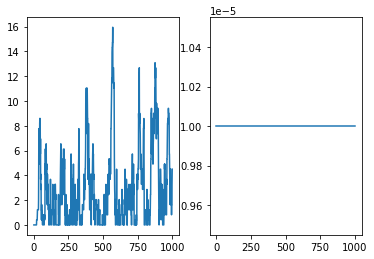

maximum steps, simulation is done ... 
elapsed_time: 50.296
Episode: 261 Exploration P: 0.0162 Total reward: -678.2197536224027 SOC: 0.4200 Cumulative_SOC_deviation: 96.4098 Fuel Consumption: 3.3514

maximum steps, simulation is done ... 
elapsed_time: 51.388
Episode: 262 Exploration P: 0.0160 Total reward: -585.0429024950301 SOC: 0.4609 Cumulative_SOC_deviation: 83.3641 Fuel Consumption: 1.4942

maximum steps, simulation is done ... 
elapsed_time: 51.223
Episode: 263 Exploration P: 0.0159 Total reward: -408.9747333048615 SOC: 0.4957 Cumulative_SOC_deviation: 58.1142 Fuel Consumption: 2.1752

maximum steps, simulation is done ... 
elapsed_time: 51.338
Episode: 264 Exploration P: 0.0158 Total reward: -195.10820297893594 SOC: 0.5379 Cumulative_SOC_deviation: 27.6650 Fuel Consumption: 1.4529

maximum steps, simulation is done ... 
elapsed_time: 51.141
Episode: 265 Exploration P: 0.0157 Total reward: -328.2532091078286 SOC: 0.5292 Cumulative_SOC_deviation: 46.5811 Fuel Consumption: 2.1855


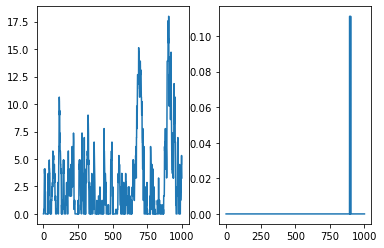

maximum steps, simulation is done ... 
elapsed_time: 50.895
Episode: 271 Exploration P: 0.0150 Total reward: -455.9815891009136 SOC: 0.4933 Cumulative_SOC_deviation: 64.8280 Fuel Consumption: 2.1855

maximum steps, simulation is done ... 
elapsed_time: 51.338
Episode: 272 Exploration P: 0.0149 Total reward: -314.21282913899597 SOC: 0.5086 Cumulative_SOC_deviation: 44.6358 Fuel Consumption: 1.7624

maximum steps, simulation is done ... 
elapsed_time: 51.591
Episode: 273 Exploration P: 0.0148 Total reward: -291.35461513881773 SOC: 0.4682 Cumulative_SOC_deviation: 41.3143 Fuel Consumption: 2.1545

maximum steps, simulation is done ... 
elapsed_time: 51.478
Episode: 274 Exploration P: 0.0147 Total reward: -1200.4936014540565 SOC: 0.2815 Cumulative_SOC_deviation: 170.7904 Fuel Consumption: 4.9611

maximum steps, simulation is done ... 
elapsed_time: 51.235
Episode: 275 Exploration P: 0.0147 Total reward: -769.2134655359007 SOC: 0.4286 Cumulative_SOC_deviation: 109.5459 Fuel Consumption: 2.3

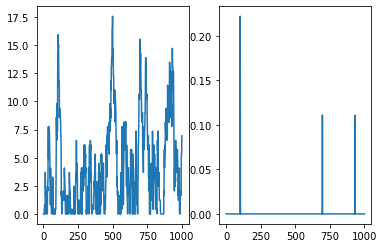

maximum steps, simulation is done ... 
elapsed_time: 50.571
Episode: 281 Exploration P: 0.0141 Total reward: -1037.3080802656862 SOC: 0.3535 Cumulative_SOC_deviation: 147.4501 Fuel Consumption: 5.1571

maximum steps, simulation is done ... 
elapsed_time: 51.118
Episode: 282 Exploration P: 0.0140 Total reward: -337.50287420317005 SOC: 0.5128 Cumulative_SOC_deviation: 47.9983 Fuel Consumption: 1.5148

maximum steps, simulation is done ... 
elapsed_time: 50.796
Episode: 283 Exploration P: 0.0140 Total reward: -270.69139659027337 SOC: 0.4999 Cumulative_SOC_deviation: 38.4022 Fuel Consumption: 1.8759

maximum steps, simulation is done ... 
elapsed_time: 51.639
Episode: 284 Exploration P: 0.0139 Total reward: -189.58227541279427 SOC: 0.5283 Cumulative_SOC_deviation: 26.7798 Fuel Consumption: 2.1236

maximum steps, simulation is done ... 
elapsed_time: 51.526
Episode: 285 Exploration P: 0.0138 Total reward: -1172.8797812940904 SOC: 0.1059 Cumulative_SOC_deviation: 164.7229 Fuel Consumption: 1

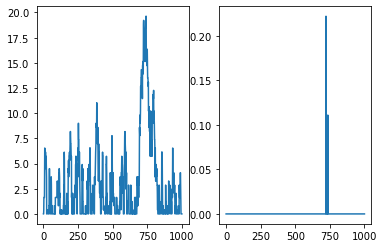

maximum steps, simulation is done ... 
elapsed_time: 50.577
Episode: 291 Exploration P: 0.0134 Total reward: -629.2218866478589 SOC: 0.4681 Cumulative_SOC_deviation: 89.5354 Fuel Consumption: 2.4744

maximum steps, simulation is done ... 
elapsed_time: 51.551
Episode: 292 Exploration P: 0.0133 Total reward: -385.90609237348224 SOC: 0.4938 Cumulative_SOC_deviation: 54.8909 Fuel Consumption: 1.6696

maximum steps, simulation is done ... 
elapsed_time: 51.583
Episode: 293 Exploration P: 0.0132 Total reward: -475.2817790719445 SOC: 0.4794 Cumulative_SOC_deviation: 67.6913 Fuel Consumption: 1.4426

maximum steps, simulation is done ... 
elapsed_time: 51.403
Episode: 294 Exploration P: 0.0132 Total reward: -213.54085953007268 SOC: 0.5214 Cumulative_SOC_deviation: 30.3101 Fuel Consumption: 1.3704

maximum steps, simulation is done ... 
elapsed_time: 51.484
Episode: 295 Exploration P: 0.0131 Total reward: -372.1310277291388 SOC: 0.4481 Cumulative_SOC_deviation: 52.8951 Fuel Consumption: 1.8656

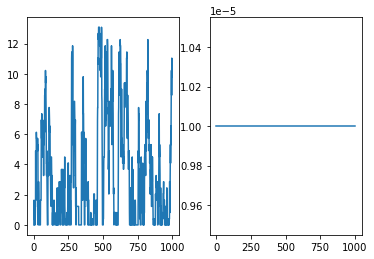

maximum steps, simulation is done ... 
elapsed_time: 50.826
Episode: 301 Exploration P: 0.0128 Total reward: -402.1718997271289 SOC: 0.5050 Cumulative_SOC_deviation: 57.1453 Fuel Consumption: 2.1545

maximum steps, simulation is done ... 
elapsed_time: 51.616
Episode: 302 Exploration P: 0.0127 Total reward: -573.0161656572919 SOC: 0.4374 Cumulative_SOC_deviation: 81.5178 Fuel Consumption: 2.3919

maximum steps, simulation is done ... 
elapsed_time: 51.622
Episode: 303 Exploration P: 0.0127 Total reward: -321.4861328676793 SOC: 0.5034 Cumulative_SOC_deviation: 45.4965 Fuel Consumption: 3.0109

maximum steps, simulation is done ... 
elapsed_time: 51.778
Episode: 304 Exploration P: 0.0126 Total reward: -257.4084028104659 SOC: 0.5209 Cumulative_SOC_deviation: 36.5371 Fuel Consumption: 1.6490

maximum steps, simulation is done ... 
elapsed_time: 51.432
Episode: 305 Exploration P: 0.0126 Total reward: -476.8717293969386 SOC: 0.4757 Cumulative_SOC_deviation: 68.0069 Fuel Consumption: 0.8235



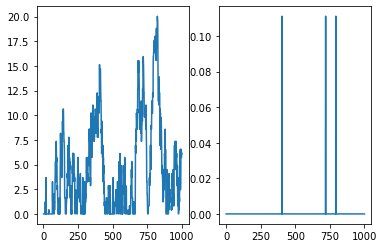

maximum steps, simulation is done ... 
elapsed_time: 50.729
Episode: 311 Exploration P: 0.0123 Total reward: -282.3757096802551 SOC: 0.4795 Cumulative_SOC_deviation: 40.1082 Fuel Consumption: 1.6180

maximum steps, simulation is done ... 
elapsed_time: 51.488
Episode: 312 Exploration P: 0.0122 Total reward: -574.0685119997711 SOC: 0.4241 Cumulative_SOC_deviation: 81.5369 Fuel Consumption: 3.3102

maximum steps, simulation is done ... 
elapsed_time: 51.060
Episode: 313 Exploration P: 0.0122 Total reward: -1131.385718771366 SOC: 0.1675 Cumulative_SOC_deviation: 160.2972 Fuel Consumption: 9.3050

battery power is 84354.08205091818(+) but condition is not avail
elapsed_time: 47.019
Episode: 314 Exploration P: 0.0121 Total reward: -1382.7721236373272 SOC: 0.3440 Cumulative_SOC_deviation: 54.3795 Fuel Consumption: 4.1865

maximum steps, simulation is done ... 
elapsed_time: 51.629
Episode: 315 Exploration P: 0.0121 Total reward: -296.97211644728657 SOC: 0.5002 Cumulative_SOC_deviation: 42.03

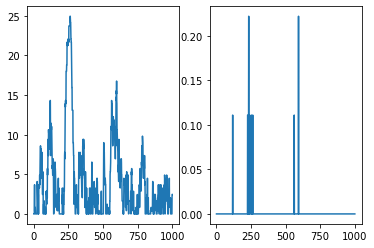

maximum steps, simulation is done ... 
elapsed_time: 50.653
Episode: 321 Exploration P: 0.0119 Total reward: -506.6428496645336 SOC: 0.4676 Cumulative_SOC_deviation: 71.9681 Fuel Consumption: 2.8665

maximum steps, simulation is done ... 
elapsed_time: 51.643
Episode: 322 Exploration P: 0.0118 Total reward: -228.01611976209412 SOC: 0.5297 Cumulative_SOC_deviation: 32.3809 Fuel Consumption: 1.3497

maximum steps, simulation is done ... 
elapsed_time: 51.860
Episode: 323 Exploration P: 0.0118 Total reward: -268.3154736923623 SOC: 0.5319 Cumulative_SOC_deviation: 38.1085 Fuel Consumption: 1.5561

maximum steps, simulation is done ... 
elapsed_time: 51.772
Episode: 324 Exploration P: 0.0117 Total reward: -293.400895825082 SOC: 0.5009 Cumulative_SOC_deviation: 41.6711 Fuel Consumption: 1.7033

maximum steps, simulation is done ... 
elapsed_time: 51.559
Episode: 325 Exploration P: 0.0117 Total reward: -46.76603721928748 SOC: 0.6051 Cumulative_SOC_deviation: 6.0278 Fuel Consumption: 4.5715

m

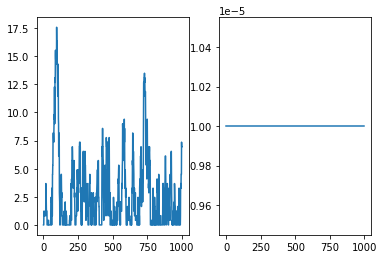

maximum steps, simulation is done ... 
elapsed_time: 51.285
Episode: 331 Exploration P: 0.0115 Total reward: -482.8786943740074 SOC: 0.4662 Cumulative_SOC_deviation: 68.7972 Fuel Consumption: 1.2981

battery power is 52828.65672865689(+) but condition is not avail
elapsed_time: 25.021
Episode: 332 Exploration P: 0.0115 Total reward: -1089.5022143982026 SOC: 0.6093 Cumulative_SOC_deviation: 8.8011 Fuel Consumption: 28.7955

maximum steps, simulation is done ... 
elapsed_time: 51.628
Episode: 333 Exploration P: 0.0115 Total reward: -431.35134699597387 SOC: 0.4786 Cumulative_SOC_deviation: 61.1705 Fuel Consumption: 3.1576

maximum steps, simulation is done ... 
elapsed_time: 52.025
Episode: 334 Exploration P: 0.0114 Total reward: -765.6764176648581 SOC: 0.4722 Cumulative_SOC_deviation: 108.5540 Fuel Consumption: 5.7983

maximum steps, simulation is done ... 
elapsed_time: 51.694
Episode: 335 Exploration P: 0.0114 Total reward: -70.07332843860688 SOC: 0.5767 Cumulative_SOC_deviation: 9.224

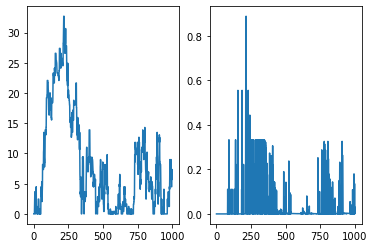

maximum steps, simulation is done ... 
elapsed_time: 51.241
Episode: 341 Exploration P: 0.0113 Total reward: -377.3991912039901 SOC: 0.5679 Cumulative_SOC_deviation: 51.0999 Fuel Consumption: 19.7002

maximum steps, simulation is done ... 
elapsed_time: 50.865
Episode: 342 Exploration P: 0.0112 Total reward: -69.87681215125 SOC: 0.5992 Cumulative_SOC_deviation: 9.0502 Fuel Consumption: 6.5252

maximum steps, simulation is done ... 
elapsed_time: 51.570
Episode: 343 Exploration P: 0.0112 Total reward: -81.99976209643195 SOC: 0.6221 Cumulative_SOC_deviation: 10.0886 Fuel Consumption: 11.3798

maximum steps, simulation is done ... 
elapsed_time: 52.121
Episode: 344 Exploration P: 0.0112 Total reward: -58.88658179346495 SOC: 0.6020 Cumulative_SOC_deviation: 6.4004 Fuel Consumption: 14.0839

maximum steps, simulation is done ... 
elapsed_time: 51.919
Episode: 345 Exploration P: 0.0112 Total reward: -57.244378137389724 SOC: 0.5971 Cumulative_SOC_deviation: 6.7086 Fuel Consumption: 10.2843

m

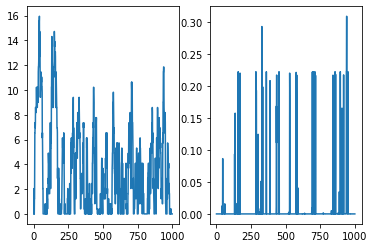

maximum steps, simulation is done ... 
elapsed_time: 51.574
Episode: 351 Exploration P: 0.0110 Total reward: -130.9459104614868 SOC: 0.5791 Cumulative_SOC_deviation: 17.7613 Fuel Consumption: 6.6170

maximum steps, simulation is done ... 
elapsed_time: 50.629
Episode: 352 Exploration P: 0.0110 Total reward: -89.17872026222543 SOC: 0.5767 Cumulative_SOC_deviation: 11.1742 Fuel Consumption: 10.9592

maximum steps, simulation is done ... 
elapsed_time: 51.058
Episode: 353 Exploration P: 0.0110 Total reward: -92.90143408979365 SOC: 0.5414 Cumulative_SOC_deviation: 11.2201 Fuel Consumption: 14.3608

maximum steps, simulation is done ... 
elapsed_time: 51.901
Episode: 354 Exploration P: 0.0110 Total reward: -172.54798528776672 SOC: 0.5313 Cumulative_SOC_deviation: 23.7590 Fuel Consumption: 6.2352

maximum steps, simulation is done ... 
elapsed_time: 51.639
Episode: 355 Exploration P: 0.0110 Total reward: -365.496434089989 SOC: 0.5069 Cumulative_SOC_deviation: 52.0947 Fuel Consumption: 0.8338

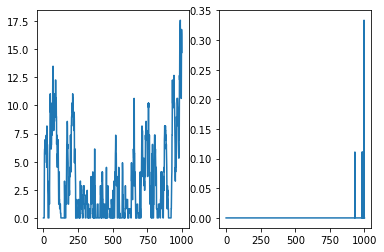

maximum steps, simulation is done ... 
elapsed_time: 51.350
Episode: 361 Exploration P: 0.0108 Total reward: -523.9589966968757 SOC: 0.4150 Cumulative_SOC_deviation: 74.4035 Fuel Consumption: 3.1348

maximum steps, simulation is done ... 
elapsed_time: 50.918
Episode: 362 Exploration P: 0.0108 Total reward: -364.1811047522625 SOC: 0.4966 Cumulative_SOC_deviation: 51.7137 Fuel Consumption: 2.1855

maximum steps, simulation is done ... 
elapsed_time: 51.355
Episode: 363 Exploration P: 0.0108 Total reward: -253.56405519624104 SOC: 0.5269 Cumulative_SOC_deviation: 35.8626 Fuel Consumption: 2.5260

maximum steps, simulation is done ... 
elapsed_time: 51.702
Episode: 364 Exploration P: 0.0108 Total reward: -463.21735236260616 SOC: 0.4368 Cumulative_SOC_deviation: 65.9383 Fuel Consumption: 1.6490

maximum steps, simulation is done ... 
elapsed_time: 51.691
Episode: 365 Exploration P: 0.0108 Total reward: -309.2463819344499 SOC: 0.4908 Cumulative_SOC_deviation: 43.9248 Fuel Consumption: 1.7728

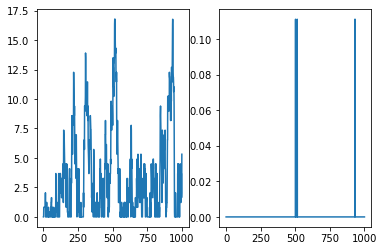

maximum steps, simulation is done ... 
elapsed_time: 50.957
Episode: 371 Exploration P: 0.0107 Total reward: -456.42767926272313 SOC: 0.4363 Cumulative_SOC_deviation: 64.8770 Fuel Consumption: 2.2887

maximum steps, simulation is done ... 
elapsed_time: 51.229
Episode: 372 Exploration P: 0.0107 Total reward: -409.92375638216816 SOC: 0.4983 Cumulative_SOC_deviation: 58.3250 Fuel Consumption: 1.6490

maximum steps, simulation is done ... 
elapsed_time: 51.576
Episode: 373 Exploration P: 0.0107 Total reward: -620.9495688653744 SOC: 0.4460 Cumulative_SOC_deviation: 88.3831 Fuel Consumption: 2.2680

battery power is 100326.3978784246(+) but condition is not avail
elapsed_time: 40.847
Episode: 374 Exploration P: 0.0107 Total reward: -1458.8866332475404 SOC: 0.1717 Cumulative_SOC_deviation: 63.4561 Fuel Consumption: 17.6919

maximum steps, simulation is done ... 
elapsed_time: 51.797
Episode: 375 Exploration P: 0.0106 Total reward: -353.2666693350283 SOC: 0.4824 Cumulative_SOC_deviation: 50.1

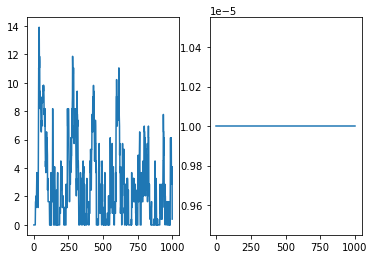

maximum steps, simulation is done ... 
elapsed_time: 50.558
Episode: 381 Exploration P: 0.0106 Total reward: -570.1523885085314 SOC: 0.3808 Cumulative_SOC_deviation: 81.0055 Fuel Consumption: 3.1141

maximum steps, simulation is done ... 
elapsed_time: 51.682
Episode: 382 Exploration P: 0.0106 Total reward: -689.9526754696802 SOC: 0.3722 Cumulative_SOC_deviation: 98.3777 Fuel Consumption: 1.3085

maximum steps, simulation is done ... 
elapsed_time: 51.749
Episode: 383 Exploration P: 0.0105 Total reward: -767.2492626553723 SOC: 0.4201 Cumulative_SOC_deviation: 109.4481 Fuel Consumption: 1.1124

maximum steps, simulation is done ... 
elapsed_time: 51.422
Episode: 384 Exploration P: 0.0105 Total reward: -611.3981573562181 SOC: 0.4106 Cumulative_SOC_deviation: 86.9965 Fuel Consumption: 2.4228

maximum steps, simulation is done ... 
elapsed_time: 51.713
Episode: 385 Exploration P: 0.0105 Total reward: -321.97240735728235 SOC: 0.5174 Cumulative_SOC_deviation: 45.7900 Fuel Consumption: 1.4426

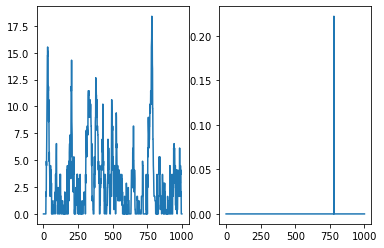

maximum steps, simulation is done ... 
elapsed_time: 50.037
Episode: 391 Exploration P: 0.0105 Total reward: -921.1497150201443 SOC: 0.3547 Cumulative_SOC_deviation: 131.3071 Fuel Consumption: 1.9998

maximum steps, simulation is done ... 
elapsed_time: 51.596
Episode: 392 Exploration P: 0.0105 Total reward: -603.1470524359569 SOC: 0.4590 Cumulative_SOC_deviation: 86.0167 Fuel Consumption: 1.0299

maximum steps, simulation is done ... 
elapsed_time: 51.655
Episode: 393 Exploration P: 0.0105 Total reward: -247.72062399583234 SOC: 0.5237 Cumulative_SOC_deviation: 35.0381 Fuel Consumption: 2.4538

maximum steps, simulation is done ... 
elapsed_time: 51.633
Episode: 394 Exploration P: 0.0104 Total reward: -502.4818164713763 SOC: 0.4513 Cumulative_SOC_deviation: 71.6006 Fuel Consumption: 1.2775

maximum steps, simulation is done ... 
elapsed_time: 51.171
Episode: 395 Exploration P: 0.0104 Total reward: -440.9648740794504 SOC: 0.4943 Cumulative_SOC_deviation: 62.8066 Fuel Consumption: 1.3188

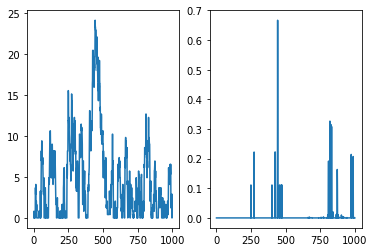

model is saved..

Trial 8

maximum steps, simulation is done ... 
elapsed_time: 9.195
Episode: 1 Exploration P: 1.0000 Total reward: -2948.7125332427067 SOC: 1.0000 Cumulative_SOC_deviation: 355.3885 Fuel Consumption: 105.6042

maximum steps, simulation is done ... 
elapsed_time: 8.492
Episode: 2 Exploration P: 1.0000 Total reward: -2915.223566168678 SOC: 1.0000 Cumulative_SOC_deviation: 352.0240 Fuel Consumption: 99.0315

maximum steps, simulation is done ... 
elapsed_time: 7.864
Episode: 3 Exploration P: 1.0000 Total reward: -2885.5792341605 SOC: 0.9999 Cumulative_SOC_deviation: 348.7944 Fuel Consumption: 95.2241

maximum steps, simulation is done ... 
elapsed_time: 6.801
Episode: 4 Exploration P: 1.0000 Total reward: -2940.8618520253985 SOC: 1.0000 Cumulative_SOC_deviation: 354.5942 Fuel Consumption: 104.1081


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model 

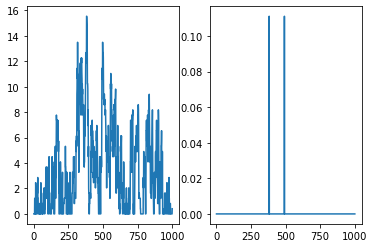

maximum steps, simulation is done ... 
elapsed_time: 49.790
Episode: 11 Exploration P: 0.8879 Total reward: -2902.101994458804 SOC: 1.0000 Cumulative_SOC_deviation: 351.0983 Fuel Consumption: 93.3153

maximum steps, simulation is done ... 
elapsed_time: 51.364
Episode: 12 Exploration P: 0.8705 Total reward: -2867.242346032686 SOC: 1.0000 Cumulative_SOC_deviation: 346.9485 Fuel Consumption: 91.6541

maximum steps, simulation is done ... 
elapsed_time: 51.202
Episode: 13 Exploration P: 0.8534 Total reward: -2857.5713342287268 SOC: 1.0000 Cumulative_SOC_deviation: 346.3381 Fuel Consumption: 86.8665

maximum steps, simulation is done ... 
elapsed_time: 51.259
Episode: 14 Exploration P: 0.8367 Total reward: -2877.457955815582 SOC: 1.0000 Cumulative_SOC_deviation: 348.7981 Fuel Consumption: 87.0728

maximum steps, simulation is done ... 
elapsed_time: 51.337
Episode: 15 Exploration P: 0.8203 Total reward: -2825.7017597539702 SOC: 1.0000 Cumulative_SOC_deviation: 342.5066 Fuel Consumption: 85

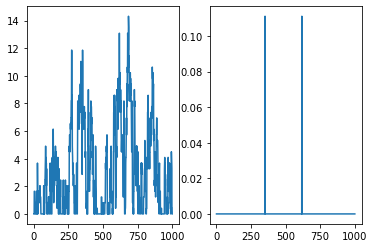

maximum steps, simulation is done ... 
elapsed_time: 50.150
Episode: 21 Exploration P: 0.7286 Total reward: -2731.776276213565 SOC: 1.0000 Cumulative_SOC_deviation: 331.3876 Fuel Consumption: 80.6756

maximum steps, simulation is done ... 
elapsed_time: 51.738
Episode: 22 Exploration P: 0.7144 Total reward: -2797.8137246082574 SOC: 1.0000 Cumulative_SOC_deviation: 339.9067 Fuel Consumption: 78.5604

maximum steps, simulation is done ... 
elapsed_time: 51.452
Episode: 23 Exploration P: 0.7004 Total reward: -2683.8549283389057 SOC: 1.0000 Cumulative_SOC_deviation: 326.4847 Fuel Consumption: 71.9774

maximum steps, simulation is done ... 
elapsed_time: 51.696
Episode: 24 Exploration P: 0.6867 Total reward: -2775.6677498064746 SOC: 1.0000 Cumulative_SOC_deviation: 337.9381 Fuel Consumption: 72.1631

maximum steps, simulation is done ... 
elapsed_time: 51.723
Episode: 25 Exploration P: 0.6733 Total reward: -2635.4367840269583 SOC: 0.9999 Cumulative_SOC_deviation: 320.5304 Fuel Consumption: 

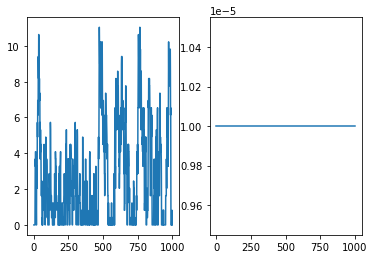

maximum steps, simulation is done ... 
elapsed_time: 51.147
Episode: 31 Exploration P: 0.5982 Total reward: -2615.5115179484715 SOC: 1.0000 Cumulative_SOC_deviation: 318.8988 Fuel Consumption: 64.3213

maximum steps, simulation is done ... 
elapsed_time: 52.134
Episode: 32 Exploration P: 0.5866 Total reward: -2659.730607552732 SOC: 0.9981 Cumulative_SOC_deviation: 324.3230 Fuel Consumption: 65.1468

maximum steps, simulation is done ... 
elapsed_time: 51.732
Episode: 33 Exploration P: 0.5751 Total reward: -2589.2776930619234 SOC: 1.0000 Cumulative_SOC_deviation: 316.1741 Fuel Consumption: 59.8845

maximum steps, simulation is done ... 
elapsed_time: 51.769
Episode: 34 Exploration P: 0.5639 Total reward: -2634.7882829302994 SOC: 1.0000 Cumulative_SOC_deviation: 321.7366 Fuel Consumption: 60.8957

maximum steps, simulation is done ... 
elapsed_time: 51.815
Episode: 35 Exploration P: 0.5530 Total reward: -2522.285463981394 SOC: 1.0000 Cumulative_SOC_deviation: 307.0559 Fuel Consumption: 6

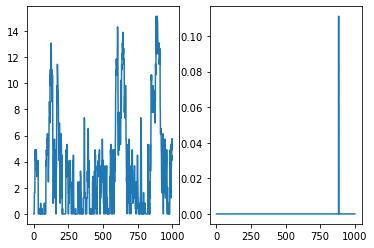

maximum steps, simulation is done ... 
elapsed_time: 51.943
Episode: 41 Exploration P: 0.4915 Total reward: -2555.590254938541 SOC: 0.9999 Cumulative_SOC_deviation: 312.2818 Fuel Consumption: 57.3359

maximum steps, simulation is done ... 
elapsed_time: 52.121
Episode: 42 Exploration P: 0.4820 Total reward: -2051.5235063497257 SOC: 1.0000 Cumulative_SOC_deviation: 249.0929 Fuel Consumption: 58.7805

maximum steps, simulation is done ... 
elapsed_time: 52.040
Episode: 43 Exploration P: 0.4726 Total reward: -2558.271983020624 SOC: 1.0000 Cumulative_SOC_deviation: 312.8595 Fuel Consumption: 55.3961

maximum steps, simulation is done ... 
elapsed_time: 51.956
Episode: 44 Exploration P: 0.4634 Total reward: -1999.3572103151737 SOC: 0.6868 Cumulative_SOC_deviation: 238.9504 Fuel Consumption: 87.7538

maximum steps, simulation is done ... 
elapsed_time: 52.291
Episode: 45 Exploration P: 0.4544 Total reward: -2315.089431473046 SOC: 1.0000 Cumulative_SOC_deviation: 283.2123 Fuel Consumption: 49

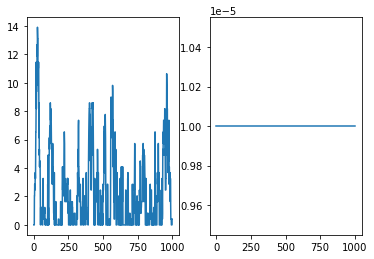

maximum steps, simulation is done ... 
elapsed_time: 52.094
Episode: 51 Exploration P: 0.4041 Total reward: -2145.057730217711 SOC: 0.9720 Cumulative_SOC_deviation: 261.9919 Fuel Consumption: 49.1227

maximum steps, simulation is done ... 
elapsed_time: 52.193
Episode: 52 Exploration P: 0.3963 Total reward: -2231.355035983113 SOC: 0.9989 Cumulative_SOC_deviation: 272.8913 Fuel Consumption: 48.2250

maximum steps, simulation is done ... 
elapsed_time: 52.118
Episode: 53 Exploration P: 0.3887 Total reward: -2105.72018343075 SOC: 1.0000 Cumulative_SOC_deviation: 257.2372 Fuel Consumption: 47.8226

maximum steps, simulation is done ... 
elapsed_time: 52.142
Episode: 54 Exploration P: 0.3812 Total reward: -2195.5501234063818 SOC: 0.9942 Cumulative_SOC_deviation: 268.3898 Fuel Consumption: 48.4314

maximum steps, simulation is done ... 
elapsed_time: 52.383
Episode: 55 Exploration P: 0.3738 Total reward: -2164.794814479864 SOC: 0.9989 Cumulative_SOC_deviation: 264.8421 Fuel Consumption: 46.0

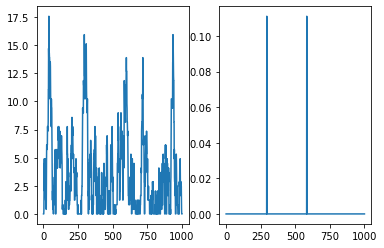

maximum steps, simulation is done ... 
elapsed_time: 52.289
Episode: 61 Exploration P: 0.3326 Total reward: -1874.0785103258104 SOC: 0.9882 Cumulative_SOC_deviation: 228.9436 Fuel Consumption: 42.5294

maximum steps, simulation is done ... 
elapsed_time: 52.082
Episode: 62 Exploration P: 0.3262 Total reward: -1917.074657717073 SOC: 0.9573 Cumulative_SOC_deviation: 234.2562 Fuel Consumption: 43.0247

maximum steps, simulation is done ... 
elapsed_time: 52.117
Episode: 63 Exploration P: 0.3200 Total reward: -1877.6295906465339 SOC: 0.9407 Cumulative_SOC_deviation: 229.0019 Fuel Consumption: 45.6145

maximum steps, simulation is done ... 
elapsed_time: 52.133
Episode: 64 Exploration P: 0.3138 Total reward: -1933.36993736066 SOC: 0.9132 Cumulative_SOC_deviation: 236.5821 Fuel Consumption: 40.7134

maximum steps, simulation is done ... 
elapsed_time: 52.389
Episode: 65 Exploration P: 0.3078 Total reward: -548.5801815492918 SOC: 0.7691 Cumulative_SOC_deviation: 61.5126 Fuel Consumption: 56.4

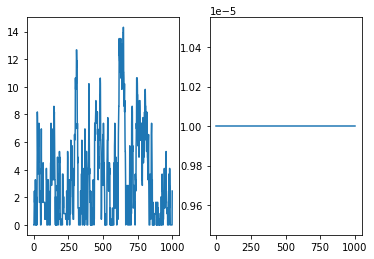

maximum steps, simulation is done ... 
elapsed_time: 52.222
Episode: 71 Exploration P: 0.2741 Total reward: -1561.3817830568428 SOC: 0.9702 Cumulative_SOC_deviation: 190.5827 Fuel Consumption: 36.7203

maximum steps, simulation is done ... 
elapsed_time: 52.438
Episode: 72 Exploration P: 0.2689 Total reward: -1856.3719057591566 SOC: 0.9804 Cumulative_SOC_deviation: 227.4100 Fuel Consumption: 37.0918

maximum steps, simulation is done ... 
elapsed_time: 52.217
Episode: 73 Exploration P: 0.2637 Total reward: -1250.8528720594804 SOC: 0.8931 Cumulative_SOC_deviation: 151.4893 Fuel Consumption: 38.9387

maximum steps, simulation is done ... 
elapsed_time: 52.446
Episode: 74 Exploration P: 0.2587 Total reward: -1927.4908943047772 SOC: 0.9986 Cumulative_SOC_deviation: 236.3218 Fuel Consumption: 36.9163

maximum steps, simulation is done ... 
elapsed_time: 52.297
Episode: 75 Exploration P: 0.2538 Total reward: -768.0770730552022 SOC: 0.6720 Cumulative_SOC_deviation: 90.4007 Fuel Consumption: 4

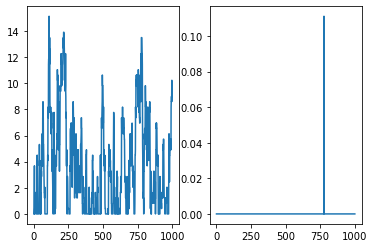

maximum steps, simulation is done ... 
elapsed_time: 52.651
Episode: 81 Exploration P: 0.2262 Total reward: -1299.9679978215431 SOC: 0.8767 Cumulative_SOC_deviation: 158.7508 Fuel Consumption: 29.9619

maximum steps, simulation is done ... 
elapsed_time: 52.629
Episode: 82 Exploration P: 0.2219 Total reward: -1254.2523578053597 SOC: 0.9046 Cumulative_SOC_deviation: 152.6494 Fuel Consumption: 33.0574

maximum steps, simulation is done ... 
elapsed_time: 52.675
Episode: 83 Exploration P: 0.2177 Total reward: -903.9619758926444 SOC: 0.8366 Cumulative_SOC_deviation: 109.5866 Fuel Consumption: 27.2689

maximum steps, simulation is done ... 
elapsed_time: 52.495
Episode: 84 Exploration P: 0.2136 Total reward: -1022.6609517452127 SOC: 0.8104 Cumulative_SOC_deviation: 123.8256 Fuel Consumption: 32.0565

maximum steps, simulation is done ... 
elapsed_time: 52.409
Episode: 85 Exploration P: 0.2095 Total reward: -1262.244674998261 SOC: 0.9034 Cumulative_SOC_deviation: 153.6420 Fuel Consumption: 3

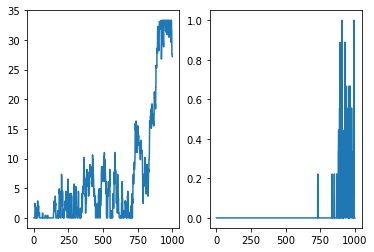

maximum steps, simulation is done ... 
elapsed_time: 52.368
Episode: 91 Exploration P: 0.1870 Total reward: -883.3428133121666 SOC: 0.8064 Cumulative_SOC_deviation: 106.9151 Fuel Consumption: 28.0221

maximum steps, simulation is done ... 
elapsed_time: 52.658
Episode: 92 Exploration P: 0.1834 Total reward: -543.6555036163406 SOC: 0.7067 Cumulative_SOC_deviation: 65.1790 Fuel Consumption: 22.2233

maximum steps, simulation is done ... 
elapsed_time: 52.478
Episode: 93 Exploration P: 0.1800 Total reward: -759.1972719188815 SOC: 0.6497 Cumulative_SOC_deviation: 91.0229 Fuel Consumption: 31.0144

maximum steps, simulation is done ... 
elapsed_time: 52.645
Episode: 94 Exploration P: 0.1766 Total reward: -959.6740636710615 SOC: 0.8296 Cumulative_SOC_deviation: 116.8447 Fuel Consumption: 24.9164

maximum steps, simulation is done ... 
elapsed_time: 52.701
Episode: 95 Exploration P: 0.1733 Total reward: -415.1097207977654 SOC: 0.6898 Cumulative_SOC_deviation: 48.8632 Fuel Consumption: 24.2044

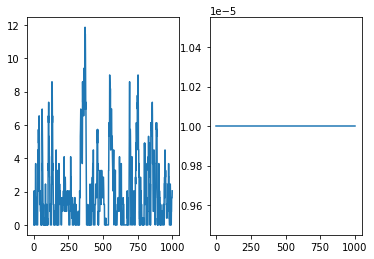

maximum steps, simulation is done ... 
elapsed_time: 53.023
Episode: 101 Exploration P: 0.1549 Total reward: -753.2485880842918 SOC: 0.7603 Cumulative_SOC_deviation: 91.5046 Fuel Consumption: 21.2121

maximum steps, simulation is done ... 
elapsed_time: 52.662
Episode: 102 Exploration P: 0.1520 Total reward: -506.550449368276 SOC: 0.7499 Cumulative_SOC_deviation: 60.2868 Fuel Consumption: 24.2560

maximum steps, simulation is done ... 
elapsed_time: 52.683
Episode: 103 Exploration P: 0.1492 Total reward: -419.64872199742297 SOC: 0.7202 Cumulative_SOC_deviation: 49.8355 Fuel Consumption: 20.9645

maximum steps, simulation is done ... 
elapsed_time: 52.828
Episode: 104 Exploration P: 0.1464 Total reward: -704.8670449421314 SOC: 0.7540 Cumulative_SOC_deviation: 85.3511 Fuel Consumption: 22.0582

maximum steps, simulation is done ... 
elapsed_time: 52.631
Episode: 105 Exploration P: 0.1437 Total reward: -388.39308530217977 SOC: 0.7057 Cumulative_SOC_deviation: 46.1620 Fuel Consumption: 19.

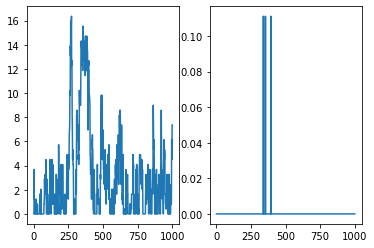

maximum steps, simulation is done ... 
elapsed_time: 52.472
Episode: 111 Exploration P: 0.1286 Total reward: -518.4184121025867 SOC: 0.7460 Cumulative_SOC_deviation: 62.3455 Fuel Consumption: 19.6541

maximum steps, simulation is done ... 
elapsed_time: 52.643
Episode: 112 Exploration P: 0.1262 Total reward: -425.82386974690223 SOC: 0.7342 Cumulative_SOC_deviation: 50.5442 Fuel Consumption: 21.4701

maximum steps, simulation is done ... 
elapsed_time: 52.808
Episode: 113 Exploration P: 0.1239 Total reward: -703.0664671387433 SOC: 0.7780 Cumulative_SOC_deviation: 85.4562 Fuel Consumption: 19.4168

maximum steps, simulation is done ... 
elapsed_time: 52.827
Episode: 114 Exploration P: 0.1217 Total reward: -435.7524826512185 SOC: 0.7031 Cumulative_SOC_deviation: 52.1284 Fuel Consumption: 18.7255

maximum steps, simulation is done ... 
elapsed_time: 52.882
Episode: 115 Exploration P: 0.1194 Total reward: -435.45549249755345 SOC: 0.6405 Cumulative_SOC_deviation: 52.3028 Fuel Consumption: 17

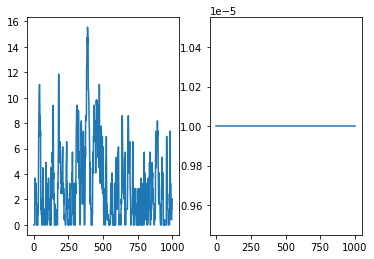

maximum steps, simulation is done ... 
elapsed_time: 53.307
Episode: 121 Exploration P: 0.1071 Total reward: -442.35313396762285 SOC: 0.7257 Cumulative_SOC_deviation: 53.1895 Fuel Consumption: 16.8373

maximum steps, simulation is done ... 
elapsed_time: 52.990
Episode: 122 Exploration P: 0.1051 Total reward: -353.21283418220787 SOC: 0.6382 Cumulative_SOC_deviation: 42.0586 Fuel Consumption: 16.7444

maximum steps, simulation is done ... 
elapsed_time: 52.971
Episode: 123 Exploration P: 0.1032 Total reward: -78.75468615718157 SOC: 0.5889 Cumulative_SOC_deviation: 8.1537 Fuel Consumption: 13.5251

maximum steps, simulation is done ... 
elapsed_time: 52.926
Episode: 124 Exploration P: 0.1014 Total reward: -177.67865330708472 SOC: 0.5931 Cumulative_SOC_deviation: 20.2819 Fuel Consumption: 15.4237

maximum steps, simulation is done ... 
elapsed_time: 53.123
Episode: 125 Exploration P: 0.0996 Total reward: -475.92128504400773 SOC: 0.7001 Cumulative_SOC_deviation: 57.2965 Fuel Consumption: 1

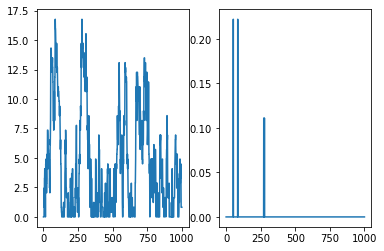

maximum steps, simulation is done ... 
elapsed_time: 53.095
Episode: 131 Exploration P: 0.0894 Total reward: -48.96514318702734 SOC: 0.6080 Cumulative_SOC_deviation: 4.8260 Fuel Consumption: 10.3575

maximum steps, simulation is done ... 
elapsed_time: 52.939
Episode: 132 Exploration P: 0.0879 Total reward: -136.93017487549375 SOC: 0.5824 Cumulative_SOC_deviation: 15.3134 Fuel Consumption: 14.4228

maximum steps, simulation is done ... 
elapsed_time: 53.005
Episode: 133 Exploration P: 0.0863 Total reward: -145.29160478486546 SOC: 0.6462 Cumulative_SOC_deviation: 16.4476 Fuel Consumption: 13.7109

maximum steps, simulation is done ... 
elapsed_time: 53.062
Episode: 134 Exploration P: 0.0848 Total reward: -421.86311657705727 SOC: 0.5333 Cumulative_SOC_deviation: 51.2435 Fuel Consumption: 11.9155

maximum steps, simulation is done ... 
elapsed_time: 53.268
Episode: 135 Exploration P: 0.0833 Total reward: -1309.3152499382707 SOC: 0.1446 Cumulative_SOC_deviation: 159.6922 Fuel Consumption: 

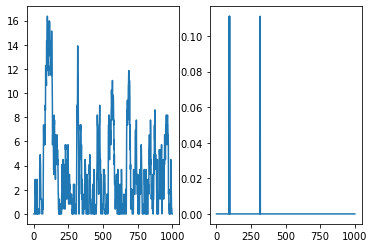

maximum steps, simulation is done ... 
elapsed_time: 52.627
Episode: 141 Exploration P: 0.0750 Total reward: -267.2529035095351 SOC: 0.6597 Cumulative_SOC_deviation: 31.7289 Fuel Consumption: 13.4219

maximum steps, simulation is done ... 
elapsed_time: 52.645
Episode: 142 Exploration P: 0.0737 Total reward: -208.61803386059532 SOC: 0.4991 Cumulative_SOC_deviation: 24.4704 Fuel Consumption: 12.8544

maximum steps, simulation is done ... 
elapsed_time: 52.860
Episode: 143 Exploration P: 0.0725 Total reward: -191.3501973952105 SOC: 0.6094 Cumulative_SOC_deviation: 22.6280 Fuel Consumption: 10.3265

maximum steps, simulation is done ... 
elapsed_time: 52.990
Episode: 144 Exploration P: 0.0712 Total reward: -64.6746177735895 SOC: 0.6091 Cumulative_SOC_deviation: 6.6503 Fuel Consumption: 11.4718

maximum steps, simulation is done ... 
elapsed_time: 52.784
Episode: 145 Exploration P: 0.0700 Total reward: -101.29564098778857 SOC: 0.5902 Cumulative_SOC_deviation: 11.6742 Fuel Consumption: 7.90

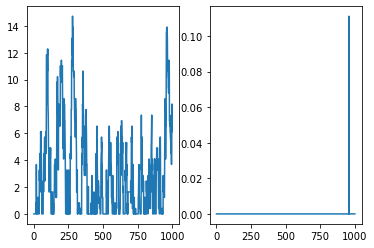

maximum steps, simulation is done ... 
elapsed_time: 52.856
Episode: 151 Exploration P: 0.0632 Total reward: -232.1825963846443 SOC: 0.5690 Cumulative_SOC_deviation: 27.9242 Fuel Consumption: 8.7891

maximum steps, simulation is done ... 
elapsed_time: 52.840
Episode: 152 Exploration P: 0.0622 Total reward: -235.3087683698165 SOC: 0.5258 Cumulative_SOC_deviation: 28.6077 Fuel Consumption: 6.4469

maximum steps, simulation is done ... 
elapsed_time: 52.988
Episode: 153 Exploration P: 0.0611 Total reward: -136.47919627819294 SOC: 0.5522 Cumulative_SOC_deviation: 15.7381 Fuel Consumption: 10.5741

maximum steps, simulation is done ... 
elapsed_time: 52.844
Episode: 154 Exploration P: 0.0601 Total reward: -130.4070663880995 SOC: 0.5763 Cumulative_SOC_deviation: 15.2280 Fuel Consumption: 8.5827

maximum steps, simulation is done ... 
elapsed_time: 52.995
Episode: 155 Exploration P: 0.0591 Total reward: -97.13033108951541 SOC: 0.5278 Cumulative_SOC_deviation: 11.2477 Fuel Consumption: 7.1485

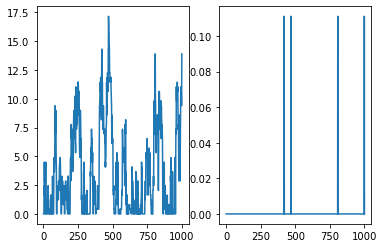

maximum steps, simulation is done ... 
elapsed_time: 53.304
Episode: 161 Exploration P: 0.0536 Total reward: -131.62368302130886 SOC: 0.5601 Cumulative_SOC_deviation: 15.4485 Fuel Consumption: 8.0359

maximum steps, simulation is done ... 
elapsed_time: 52.906
Episode: 162 Exploration P: 0.0527 Total reward: -2805.2098198750996 SOC: 0.1660 Cumulative_SOC_deviation: 349.0805 Fuel Consumption: 12.5655

maximum steps, simulation is done ... 
elapsed_time: 52.956
Episode: 163 Exploration P: 0.0519 Total reward: -127.79460060837808 SOC: 0.5561 Cumulative_SOC_deviation: 14.9092 Fuel Consumption: 8.5208

maximum steps, simulation is done ... 
elapsed_time: 53.027
Episode: 164 Exploration P: 0.0510 Total reward: -131.26741564547604 SOC: 0.5277 Cumulative_SOC_deviation: 15.5884 Fuel Consumption: 6.5604

maximum steps, simulation is done ... 
elapsed_time: 53.083
Episode: 165 Exploration P: 0.0502 Total reward: -159.58345141359914 SOC: 0.5787 Cumulative_SOC_deviation: 18.8067 Fuel Consumption: 9

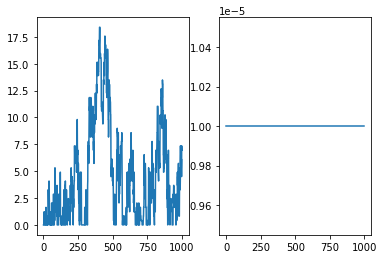

maximum steps, simulation is done ... 
elapsed_time: 53.313
Episode: 171 Exploration P: 0.0457 Total reward: -175.70496574447566 SOC: 0.5849 Cumulative_SOC_deviation: 20.8929 Fuel Consumption: 8.5621

maximum steps, simulation is done ... 
elapsed_time: 53.284
Episode: 172 Exploration P: 0.0450 Total reward: -767.7817818351789 SOC: 0.4675 Cumulative_SOC_deviation: 94.6755 Fuel Consumption: 10.3781

maximum steps, simulation is done ... 
elapsed_time: 53.217
Episode: 173 Exploration P: 0.0443 Total reward: -169.76708389549782 SOC: 0.5712 Cumulative_SOC_deviation: 20.2112 Fuel Consumption: 8.0772

maximum steps, simulation is done ... 
elapsed_time: 53.194
Episode: 174 Exploration P: 0.0436 Total reward: -138.6911677403103 SOC: 0.5602 Cumulative_SOC_deviation: 16.4003 Fuel Consumption: 7.4890

maximum steps, simulation is done ... 
elapsed_time: 53.253
Episode: 175 Exploration P: 0.0429 Total reward: -600.493391842715 SOC: 0.4789 Cumulative_SOC_deviation: 74.0237 Fuel Consumption: 8.3041

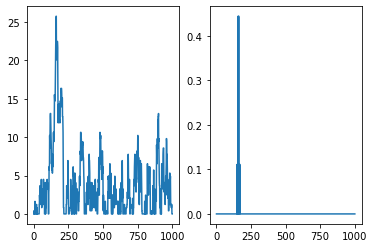

maximum steps, simulation is done ... 
elapsed_time: 53.056
Episode: 181 Exploration P: 0.0392 Total reward: -167.73143710399938 SOC: 0.5617 Cumulative_SOC_deviation: 20.0509 Fuel Consumption: 7.3239

maximum steps, simulation is done ... 
elapsed_time: 53.102
Episode: 182 Exploration P: 0.0386 Total reward: -326.85861012864945 SOC: 0.5409 Cumulative_SOC_deviation: 40.2565 Fuel Consumption: 4.8063

maximum steps, simulation is done ... 
elapsed_time: 53.205
Episode: 183 Exploration P: 0.0381 Total reward: -295.7365088085169 SOC: 0.5606 Cumulative_SOC_deviation: 36.2799 Fuel Consumption: 5.4976

maximum steps, simulation is done ... 
elapsed_time: 53.000
Episode: 184 Exploration P: 0.0375 Total reward: -467.2635711885068 SOC: 0.5057 Cumulative_SOC_deviation: 57.7027 Fuel Consumption: 5.6421

maximum steps, simulation is done ... 
elapsed_time: 53.113
Episode: 185 Exploration P: 0.0370 Total reward: -209.15385574142874 SOC: 0.5259 Cumulative_SOC_deviation: 25.2313 Fuel Consumption: 7.303

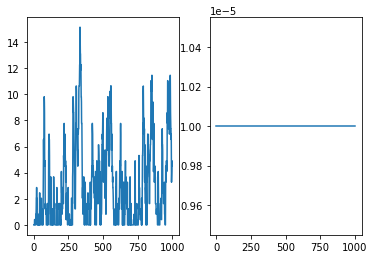

maximum steps, simulation is done ... 
elapsed_time: 53.054
Episode: 191 Exploration P: 0.0339 Total reward: -55.71192244923749 SOC: 0.5969 Cumulative_SOC_deviation: 6.2239 Fuel Consumption: 5.9207

maximum steps, simulation is done ... 
elapsed_time: 53.075
Episode: 192 Exploration P: 0.0334 Total reward: -390.41384547478214 SOC: 0.5250 Cumulative_SOC_deviation: 48.3544 Fuel Consumption: 3.5784

maximum steps, simulation is done ... 
elapsed_time: 52.881
Episode: 193 Exploration P: 0.0330 Total reward: -797.842982489368 SOC: 0.4717 Cumulative_SOC_deviation: 98.8832 Fuel Consumption: 6.7771

maximum steps, simulation is done ... 
elapsed_time: 53.205
Episode: 194 Exploration P: 0.0325 Total reward: -195.3416044639929 SOC: 0.5308 Cumulative_SOC_deviation: 23.6260 Fuel Consumption: 6.3334

maximum steps, simulation is done ... 
elapsed_time: 52.911
Episode: 195 Exploration P: 0.0321 Total reward: -48.89362909247049 SOC: 0.5860 Cumulative_SOC_deviation: 5.5367 Fuel Consumption: 4.5999

ma

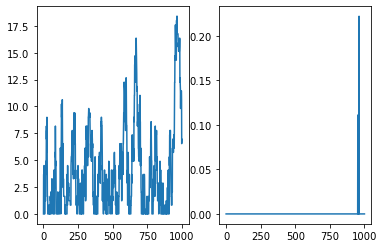

maximum steps, simulation is done ... 
elapsed_time: 52.943
Episode: 201 Exploration P: 0.0296 Total reward: -313.956313179425 SOC: 0.5486 Cumulative_SOC_deviation: 38.5625 Fuel Consumption: 5.4563

maximum steps, simulation is done ... 
elapsed_time: 52.871
Episode: 202 Exploration P: 0.0292 Total reward: -508.7754294989996 SOC: 0.4933 Cumulative_SOC_deviation: 62.9084 Fuel Consumption: 5.5079

maximum steps, simulation is done ... 
elapsed_time: 52.939
Episode: 203 Exploration P: 0.0288 Total reward: -458.55159734537426 SOC: 0.6079 Cumulative_SOC_deviation: 54.6705 Fuel Consumption: 21.1879

maximum steps, simulation is done ... 
elapsed_time: 53.198
Episode: 204 Exploration P: 0.0284 Total reward: -78.8911842757289 SOC: 0.6096 Cumulative_SOC_deviation: 7.2191 Fuel Consumption: 21.1388

maximum steps, simulation is done ... 
elapsed_time: 53.107
Episode: 205 Exploration P: 0.0281 Total reward: -37.99810268855252 SOC: 0.6057 Cumulative_SOC_deviation: 3.6809 Fuel Consumption: 8.5511

m

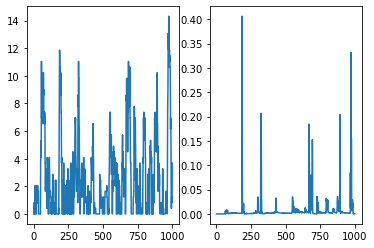

maximum steps, simulation is done ... 
elapsed_time: 52.996
Episode: 211 Exploration P: 0.0260 Total reward: -71.53452521522298 SOC: 0.6025 Cumulative_SOC_deviation: 6.8550 Fuel Consumption: 16.6948

maximum steps, simulation is done ... 
elapsed_time: 53.359
Episode: 212 Exploration P: 0.0257 Total reward: -59.50721015177761 SOC: 0.6005 Cumulative_SOC_deviation: 6.2657 Fuel Consumption: 9.3812

maximum steps, simulation is done ... 
elapsed_time: 53.417
Episode: 213 Exploration P: 0.0254 Total reward: -81.43413474424982 SOC: 0.5945 Cumulative_SOC_deviation: 6.9635 Fuel Consumption: 25.7264

maximum steps, simulation is done ... 
elapsed_time: 53.128
Episode: 214 Exploration P: 0.0251 Total reward: -101.72964874046795 SOC: 0.5969 Cumulative_SOC_deviation: 10.4794 Fuel Consumption: 17.8948

maximum steps, simulation is done ... 
elapsed_time: 52.935
Episode: 215 Exploration P: 0.0248 Total reward: -85.93046742588953 SOC: 0.5875 Cumulative_SOC_deviation: 9.4805 Fuel Consumption: 10.0868


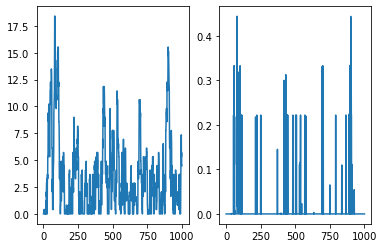

maximum steps, simulation is done ... 
elapsed_time: 53.337
Episode: 221 Exploration P: 0.0231 Total reward: -70.18303632209964 SOC: 0.5934 Cumulative_SOC_deviation: 7.4599 Fuel Consumption: 10.5036

maximum steps, simulation is done ... 
elapsed_time: 53.114
Episode: 222 Exploration P: 0.0228 Total reward: -220.118190217128 SOC: 0.5797 Cumulative_SOC_deviation: 25.6073 Fuel Consumption: 15.2595

maximum steps, simulation is done ... 
elapsed_time: 53.198
Episode: 223 Exploration P: 0.0226 Total reward: -57.57537699871177 SOC: 0.5857 Cumulative_SOC_deviation: 6.2599 Fuel Consumption: 7.4961

maximum steps, simulation is done ... 
elapsed_time: 53.287
Episode: 224 Exploration P: 0.0223 Total reward: -115.0558383763737 SOC: 0.5887 Cumulative_SOC_deviation: 13.0812 Fuel Consumption: 10.4061

maximum steps, simulation is done ... 
elapsed_time: 52.343
Episode: 225 Exploration P: 0.0221 Total reward: -101.57645311238153 SOC: 0.5957 Cumulative_SOC_deviation: 11.1926 Fuel Consumption: 12.0355

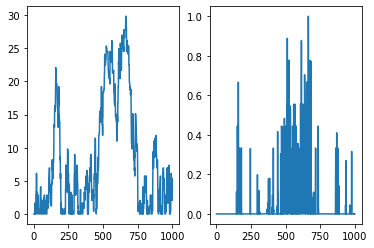

maximum steps, simulation is done ... 
elapsed_time: 53.153
Episode: 231 Exploration P: 0.0207 Total reward: -159.03382240602429 SOC: 0.5924 Cumulative_SOC_deviation: 19.1432 Fuel Consumption: 5.8880

maximum steps, simulation is done ... 
elapsed_time: 53.031
Episode: 232 Exploration P: 0.0205 Total reward: -118.05316171476785 SOC: 0.5857 Cumulative_SOC_deviation: 13.4310 Fuel Consumption: 10.6052

maximum steps, simulation is done ... 
elapsed_time: 53.219
Episode: 233 Exploration P: 0.0203 Total reward: -99.43396757238838 SOC: 0.5816 Cumulative_SOC_deviation: 9.3532 Fuel Consumption: 24.6080

maximum steps, simulation is done ... 
elapsed_time: 53.029
Episode: 234 Exploration P: 0.0201 Total reward: -136.3284979790978 SOC: 0.5820 Cumulative_SOC_deviation: 15.6813 Fuel Consumption: 10.8779

maximum steps, simulation is done ... 
elapsed_time: 52.466
Episode: 235 Exploration P: 0.0199 Total reward: -147.36469093505946 SOC: 0.5603 Cumulative_SOC_deviation: 16.9812 Fuel Consumption: 11.

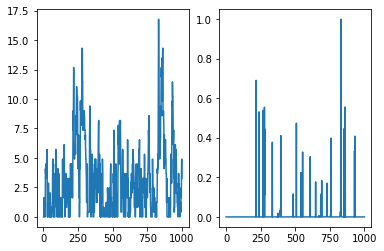

maximum steps, simulation is done ... 
elapsed_time: 53.222
Episode: 241 Exploration P: 0.0188 Total reward: -121.45014634738631 SOC: 0.6016 Cumulative_SOC_deviation: 12.8046 Fuel Consumption: 19.0131

maximum steps, simulation is done ... 
elapsed_time: 52.963
Episode: 242 Exploration P: 0.0186 Total reward: -107.81805125034121 SOC: 0.5931 Cumulative_SOC_deviation: 11.1295 Fuel Consumption: 18.7821

maximum steps, simulation is done ... 
elapsed_time: 53.092
Episode: 243 Exploration P: 0.0184 Total reward: -106.71634794153994 SOC: 0.5820 Cumulative_SOC_deviation: 11.9875 Fuel Consumption: 10.8161

maximum steps, simulation is done ... 
elapsed_time: 53.087
Episode: 244 Exploration P: 0.0183 Total reward: -134.80299118472405 SOC: 0.5713 Cumulative_SOC_deviation: 15.5359 Fuel Consumption: 10.5154

maximum steps, simulation is done ... 
elapsed_time: 52.508
Episode: 245 Exploration P: 0.0181 Total reward: -111.71808059088079 SOC: 0.5920 Cumulative_SOC_deviation: 12.0858 Fuel Consumption:

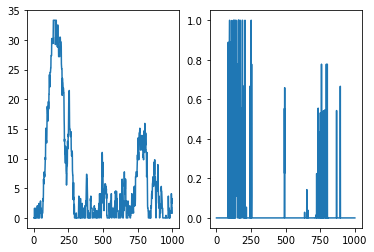

maximum steps, simulation is done ... 
elapsed_time: 53.163
Episode: 251 Exploration P: 0.0172 Total reward: -75.94861218434686 SOC: 0.5894 Cumulative_SOC_deviation: 8.0352 Fuel Consumption: 11.6672

maximum steps, simulation is done ... 
elapsed_time: 53.305
Episode: 252 Exploration P: 0.0170 Total reward: -77.19291845054569 SOC: 0.5914 Cumulative_SOC_deviation: 7.6669 Fuel Consumption: 15.8577

maximum steps, simulation is done ... 
elapsed_time: 53.271
Episode: 253 Exploration P: 0.0169 Total reward: -62.30125329119362 SOC: 0.5944 Cumulative_SOC_deviation: 6.1490 Fuel Consumption: 13.1089

maximum steps, simulation is done ... 
elapsed_time: 52.947
Episode: 254 Exploration P: 0.0168 Total reward: -64.03058088302187 SOC: 0.6038 Cumulative_SOC_deviation: 5.7736 Fuel Consumption: 17.8421

maximum steps, simulation is done ... 
elapsed_time: 51.795
Episode: 255 Exploration P: 0.0166 Total reward: -37.807331344676825 SOC: 0.5969 Cumulative_SOC_deviation: 3.1282 Fuel Consumption: 12.7821


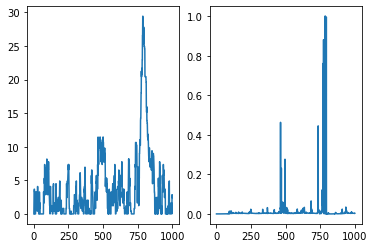

maximum steps, simulation is done ... 
elapsed_time: 53.121
Episode: 261 Exploration P: 0.0159 Total reward: -33.54601865966622 SOC: 0.5998 Cumulative_SOC_deviation: 3.3271 Fuel Consumption: 6.9296

maximum steps, simulation is done ... 
elapsed_time: 53.070
Episode: 262 Exploration P: 0.0158 Total reward: -20.919890280248477 SOC: 0.6015 Cumulative_SOC_deviation: 1.9897 Fuel Consumption: 5.0024

maximum steps, simulation is done ... 
elapsed_time: 53.288
Episode: 263 Exploration P: 0.0157 Total reward: -32.593825326595606 SOC: 0.5986 Cumulative_SOC_deviation: 3.0859 Fuel Consumption: 7.9065

maximum steps, simulation is done ... 
elapsed_time: 52.244
Episode: 264 Exploration P: 0.0155 Total reward: -37.625150122290066 SOC: 0.6028 Cumulative_SOC_deviation: 3.1160 Fuel Consumption: 12.6973

maximum steps, simulation is done ... 
elapsed_time: 52.105
Episode: 265 Exploration P: 0.0154 Total reward: -52.3693114445147 SOC: 0.5912 Cumulative_SOC_deviation: 4.8005 Fuel Consumption: 13.9650

m

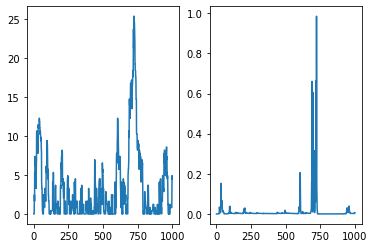

maximum steps, simulation is done ... 
elapsed_time: 52.546
Episode: 271 Exploration P: 0.0148 Total reward: -54.51167396376258 SOC: 0.6007 Cumulative_SOC_deviation: 4.3845 Fuel Consumption: 19.4357

maximum steps, simulation is done ... 
elapsed_time: 53.017
Episode: 272 Exploration P: 0.0147 Total reward: -23.837567755177766 SOC: 0.5992 Cumulative_SOC_deviation: 1.7976 Fuel Consumption: 9.4569

maximum steps, simulation is done ... 
elapsed_time: 53.018
Episode: 273 Exploration P: 0.0146 Total reward: -26.120599857400155 SOC: 0.6020 Cumulative_SOC_deviation: 1.9206 Fuel Consumption: 10.7559

maximum steps, simulation is done ... 
elapsed_time: 52.376
Episode: 274 Exploration P: 0.0145 Total reward: -35.00794951248588 SOC: 0.5919 Cumulative_SOC_deviation: 3.7216 Fuel Consumption: 5.2355

maximum steps, simulation is done ... 
elapsed_time: 52.290
Episode: 275 Exploration P: 0.0144 Total reward: -69.4045713098297 SOC: 0.6050 Cumulative_SOC_deviation: 3.5534 Fuel Consumption: 40.9772

m

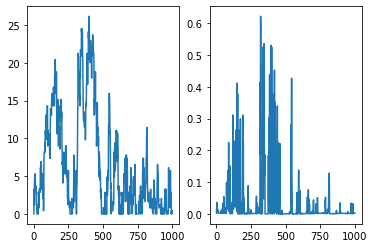

maximum steps, simulation is done ... 
elapsed_time: 53.365
Episode: 281 Exploration P: 0.0139 Total reward: -23.818116462399164 SOC: 0.5964 Cumulative_SOC_deviation: 1.7059 Fuel Consumption: 10.1708

maximum steps, simulation is done ... 
elapsed_time: 52.928
Episode: 282 Exploration P: 0.0139 Total reward: -26.534593132264852 SOC: 0.6007 Cumulative_SOC_deviation: 2.0682 Fuel Consumption: 9.9888

maximum steps, simulation is done ... 
elapsed_time: 53.358
Episode: 283 Exploration P: 0.0138 Total reward: -32.16369611484327 SOC: 0.6013 Cumulative_SOC_deviation: 2.2205 Fuel Consumption: 14.3998

maximum steps, simulation is done ... 
elapsed_time: 52.406
Episode: 284 Exploration P: 0.0137 Total reward: -30.07302152949542 SOC: 0.5990 Cumulative_SOC_deviation: 1.8822 Fuel Consumption: 15.0158

maximum steps, simulation is done ... 
elapsed_time: 52.385
Episode: 285 Exploration P: 0.0136 Total reward: -21.489548786642814 SOC: 0.5997 Cumulative_SOC_deviation: 1.7751 Fuel Consumption: 7.2887


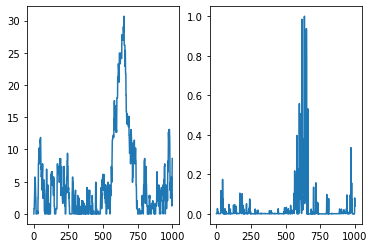

maximum steps, simulation is done ... 
elapsed_time: 53.143
Episode: 291 Exploration P: 0.0132 Total reward: -36.02176962150692 SOC: 0.6039 Cumulative_SOC_deviation: 2.1184 Fuel Consumption: 19.0744

maximum steps, simulation is done ... 
elapsed_time: 53.194
Episode: 292 Exploration P: 0.0132 Total reward: -25.873125160174688 SOC: 0.5970 Cumulative_SOC_deviation: 2.2441 Fuel Consumption: 7.9202

maximum steps, simulation is done ... 
elapsed_time: 52.942
Episode: 293 Exploration P: 0.0131 Total reward: -35.21807883978453 SOC: 0.5925 Cumulative_SOC_deviation: 3.3012 Fuel Consumption: 8.8082

maximum steps, simulation is done ... 
elapsed_time: 52.499
Episode: 294 Exploration P: 0.0130 Total reward: -36.36913677079075 SOC: 0.5993 Cumulative_SOC_deviation: 3.1096 Fuel Consumption: 11.4926

maximum steps, simulation is done ... 
elapsed_time: 52.287
Episode: 295 Exploration P: 0.0130 Total reward: -49.79610180861955 SOC: 0.5994 Cumulative_SOC_deviation: 3.8101 Fuel Consumption: 19.3153

m

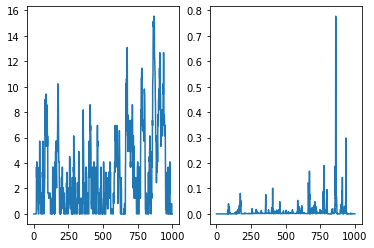

maximum steps, simulation is done ... 
elapsed_time: 52.995
Episode: 301 Exploration P: 0.0126 Total reward: -64.44544917834118 SOC: 0.5915 Cumulative_SOC_deviation: 6.4579 Fuel Consumption: 12.7819

maximum steps, simulation is done ... 
elapsed_time: 53.094
Episode: 302 Exploration P: 0.0126 Total reward: -43.284196285982716 SOC: 0.5969 Cumulative_SOC_deviation: 4.4503 Fuel Consumption: 7.6815

maximum steps, simulation is done ... 
elapsed_time: 52.352
Episode: 303 Exploration P: 0.0125 Total reward: -24.999174112068793 SOC: 0.6000 Cumulative_SOC_deviation: 1.8446 Fuel Consumption: 10.2421

maximum steps, simulation is done ... 
elapsed_time: 52.307
Episode: 304 Exploration P: 0.0125 Total reward: -31.072501060893092 SOC: 0.5971 Cumulative_SOC_deviation: 2.9563 Fuel Consumption: 7.4218

maximum steps, simulation is done ... 
elapsed_time: 53.265
Episode: 305 Exploration P: 0.0124 Total reward: -33.84694809857743 SOC: 0.5894 Cumulative_SOC_deviation: 2.6395 Fuel Consumption: 12.7308


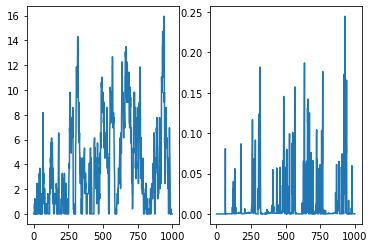

maximum steps, simulation is done ... 
elapsed_time: 52.989
Episode: 311 Exploration P: 0.0122 Total reward: -46.176641460674446 SOC: 0.6045 Cumulative_SOC_deviation: 3.4617 Fuel Consumption: 18.4834

maximum steps, simulation is done ... 
elapsed_time: 53.305
Episode: 312 Exploration P: 0.0121 Total reward: -48.20346752269664 SOC: 0.5969 Cumulative_SOC_deviation: 2.7449 Fuel Consumption: 26.2441

maximum steps, simulation is done ... 
elapsed_time: 51.585
Episode: 313 Exploration P: 0.0121 Total reward: -31.496853054185422 SOC: 0.5994 Cumulative_SOC_deviation: 2.8457 Fuel Consumption: 8.7310

maximum steps, simulation is done ... 
elapsed_time: 53.013
Episode: 314 Exploration P: 0.0120 Total reward: -25.49942170616159 SOC: 0.5918 Cumulative_SOC_deviation: 1.9986 Fuel Consumption: 9.5105

maximum steps, simulation is done ... 
elapsed_time: 53.097
Episode: 315 Exploration P: 0.0120 Total reward: -64.31239783182956 SOC: 0.5907 Cumulative_SOC_deviation: 6.6886 Fuel Consumption: 10.8038



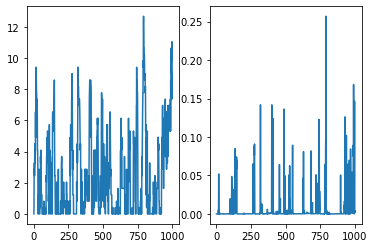

maximum steps, simulation is done ... 
elapsed_time: 52.892
Episode: 321 Exploration P: 0.0118 Total reward: -36.06116621103183 SOC: 0.6001 Cumulative_SOC_deviation: 3.3953 Fuel Consumption: 8.8987

maximum steps, simulation is done ... 
elapsed_time: 52.971
Episode: 322 Exploration P: 0.0117 Total reward: -38.29084078638344 SOC: 0.5971 Cumulative_SOC_deviation: 3.1911 Fuel Consumption: 12.7619

maximum steps, simulation is done ... 
elapsed_time: 51.830
Episode: 323 Exploration P: 0.0117 Total reward: -37.01783128848784 SOC: 0.6001 Cumulative_SOC_deviation: 3.7808 Fuel Consumption: 6.7713

maximum steps, simulation is done ... 
elapsed_time: 52.904
Episode: 324 Exploration P: 0.0117 Total reward: -49.38445481439688 SOC: 0.5986 Cumulative_SOC_deviation: 4.1257 Fuel Consumption: 16.3789

maximum steps, simulation is done ... 
elapsed_time: 53.247
Episode: 325 Exploration P: 0.0116 Total reward: -35.81534435797014 SOC: 0.6016 Cumulative_SOC_deviation: 3.1947 Fuel Consumption: 10.2577

ma

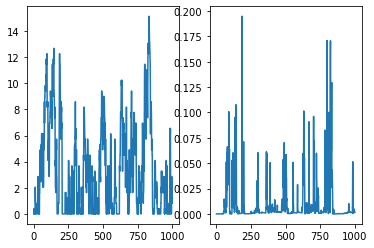

maximum steps, simulation is done ... 
elapsed_time: 53.232
Episode: 331 Exploration P: 0.0114 Total reward: -30.15218788307511 SOC: 0.6043 Cumulative_SOC_deviation: 2.8315 Fuel Consumption: 7.5003

maximum steps, simulation is done ... 
elapsed_time: 52.790
Episode: 332 Exploration P: 0.0114 Total reward: -44.872748076326175 SOC: 0.5877 Cumulative_SOC_deviation: 4.6570 Fuel Consumption: 7.6167

maximum steps, simulation is done ... 
elapsed_time: 51.857
Episode: 333 Exploration P: 0.0114 Total reward: -72.8195745217026 SOC: 0.6007 Cumulative_SOC_deviation: 7.5964 Fuel Consumption: 12.0487

maximum steps, simulation is done ... 
elapsed_time: 53.251
Episode: 334 Exploration P: 0.0114 Total reward: -23.093077678655607 SOC: 0.5972 Cumulative_SOC_deviation: 1.5168 Fuel Consumption: 10.9588

maximum steps, simulation is done ... 
elapsed_time: 52.963
Episode: 335 Exploration P: 0.0113 Total reward: -21.889219213493682 SOC: 0.6003 Cumulative_SOC_deviation: 1.8437 Fuel Consumption: 7.1398

m

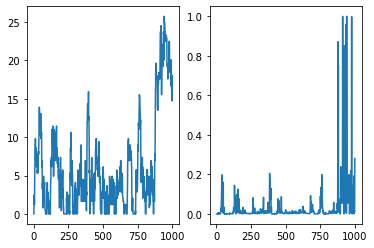

maximum steps, simulation is done ... 
elapsed_time: 53.233
Episode: 341 Exploration P: 0.0112 Total reward: -29.989462510568732 SOC: 0.6037 Cumulative_SOC_deviation: 2.5101 Fuel Consumption: 9.9087

maximum steps, simulation is done ... 
elapsed_time: 51.674
Episode: 342 Exploration P: 0.0112 Total reward: -20.439531433577248 SOC: 0.6020 Cumulative_SOC_deviation: 1.4096 Fuel Consumption: 9.1624

maximum steps, simulation is done ... 
elapsed_time: 53.218
Episode: 343 Exploration P: 0.0111 Total reward: -20.002453116258106 SOC: 0.6016 Cumulative_SOC_deviation: 1.7954 Fuel Consumption: 5.6395

maximum steps, simulation is done ... 
elapsed_time: 53.246
Episode: 344 Exploration P: 0.0111 Total reward: -20.046990626388144 SOC: 0.6007 Cumulative_SOC_deviation: 1.6044 Fuel Consumption: 7.2117

maximum steps, simulation is done ... 
elapsed_time: 53.322
Episode: 345 Exploration P: 0.0111 Total reward: -25.61542815182437 SOC: 0.6034 Cumulative_SOC_deviation: 2.1580 Fuel Consumption: 8.3516

m

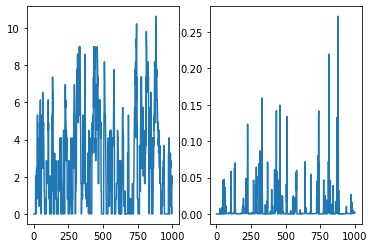

maximum steps, simulation is done ... 
elapsed_time: 52.715
Episode: 351 Exploration P: 0.0110 Total reward: -22.912707537000248 SOC: 0.6010 Cumulative_SOC_deviation: 1.9571 Fuel Consumption: 7.2562

maximum steps, simulation is done ... 
elapsed_time: 52.193
Episode: 352 Exploration P: 0.0110 Total reward: -24.47663873790269 SOC: 0.5961 Cumulative_SOC_deviation: 2.1254 Fuel Consumption: 7.4733

maximum steps, simulation is done ... 
elapsed_time: 53.313
Episode: 353 Exploration P: 0.0109 Total reward: -27.46593582297611 SOC: 0.6004 Cumulative_SOC_deviation: 2.4161 Fuel Consumption: 8.1374

maximum steps, simulation is done ... 
elapsed_time: 53.357
Episode: 354 Exploration P: 0.0109 Total reward: -47.19222730667596 SOC: 0.5983 Cumulative_SOC_deviation: 3.0949 Fuel Consumption: 22.4330

maximum steps, simulation is done ... 
elapsed_time: 53.191
Episode: 355 Exploration P: 0.0109 Total reward: -39.266852301668706 SOC: 0.5969 Cumulative_SOC_deviation: 3.7750 Fuel Consumption: 9.0670

ma

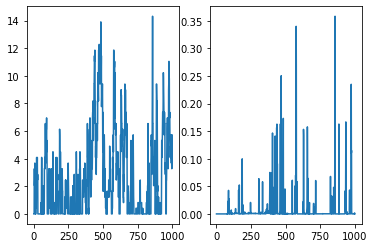

maximum steps, simulation is done ... 
elapsed_time: 52.104
Episode: 361 Exploration P: 0.0108 Total reward: -37.098823854381244 SOC: 0.5979 Cumulative_SOC_deviation: 3.1012 Fuel Consumption: 12.2889

maximum steps, simulation is done ... 
elapsed_time: 52.275
Episode: 362 Exploration P: 0.0108 Total reward: -42.505636692328906 SOC: 0.5973 Cumulative_SOC_deviation: 4.0102 Fuel Consumption: 10.4239

maximum steps, simulation is done ... 
elapsed_time: 53.082
Episode: 363 Exploration P: 0.0108 Total reward: -65.14593829564647 SOC: 0.5757 Cumulative_SOC_deviation: 7.4436 Fuel Consumption: 5.5970

maximum steps, simulation is done ... 
elapsed_time: 52.967
Episode: 364 Exploration P: 0.0107 Total reward: -63.83502503071299 SOC: 0.6028 Cumulative_SOC_deviation: 5.9533 Fuel Consumption: 16.2087

maximum steps, simulation is done ... 
elapsed_time: 53.193
Episode: 365 Exploration P: 0.0107 Total reward: -32.112451092777725 SOC: 0.5987 Cumulative_SOC_deviation: 2.8164 Fuel Consumption: 9.5811


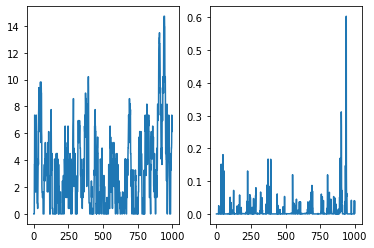

maximum steps, simulation is done ... 
elapsed_time: 52.481
Episode: 371 Exploration P: 0.0107 Total reward: -26.450326971639768 SOC: 0.5961 Cumulative_SOC_deviation: 2.6258 Fuel Consumption: 5.4438

maximum steps, simulation is done ... 
elapsed_time: 52.316
Episode: 372 Exploration P: 0.0106 Total reward: -31.087114259550795 SOC: 0.5991 Cumulative_SOC_deviation: 3.0043 Fuel Consumption: 7.0525

maximum steps, simulation is done ... 
elapsed_time: 53.104
Episode: 373 Exploration P: 0.0106 Total reward: -35.8203058799308 SOC: 0.5961 Cumulative_SOC_deviation: 3.6251 Fuel Consumption: 6.8197

maximum steps, simulation is done ... 
elapsed_time: 53.201
Episode: 374 Exploration P: 0.0106 Total reward: -47.17023213866873 SOC: 0.5930 Cumulative_SOC_deviation: 3.5751 Fuel Consumption: 18.5694

maximum steps, simulation is done ... 
elapsed_time: 53.122
Episode: 375 Exploration P: 0.0106 Total reward: -48.044595775995134 SOC: 0.5966 Cumulative_SOC_deviation: 4.9557 Fuel Consumption: 8.3991

ma

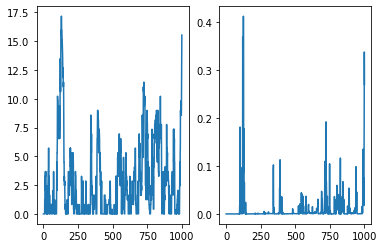

maximum steps, simulation is done ... 
elapsed_time: 51.671
Episode: 381 Exploration P: 0.0105 Total reward: -33.24924860963585 SOC: 0.6020 Cumulative_SOC_deviation: 3.0016 Fuel Consumption: 9.2365

maximum steps, simulation is done ... 
elapsed_time: 53.240
Episode: 382 Exploration P: 0.0105 Total reward: -34.58411560367288 SOC: 0.5962 Cumulative_SOC_deviation: 3.5223 Fuel Consumption: 6.4059

maximum steps, simulation is done ... 
elapsed_time: 53.231
Episode: 383 Exploration P: 0.0105 Total reward: -32.539732946638225 SOC: 0.5959 Cumulative_SOC_deviation: 3.2218 Fuel Consumption: 6.7657

battery power is 39438.76535052265(+) but condition is not avail
elapsed_time: 49.887
Episode: 384 Exploration P: 0.0105 Total reward: -1055.5901312556866 SOC: 0.5907 Cumulative_SOC_deviation: 3.9898 Fuel Consumption: 24.5721

maximum steps, simulation is done ... 
elapsed_time: 53.313
Episode: 385 Exploration P: 0.0105 Total reward: -40.02635197267496 SOC: 0.5946 Cumulative_SOC_deviation: 3.5095 Fu

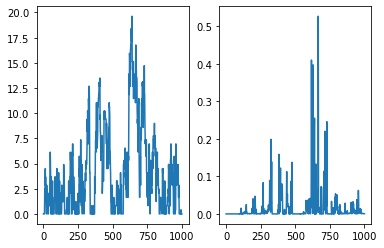

maximum steps, simulation is done ... 
elapsed_time: 47.927
Episode: 391 Exploration P: 0.0104 Total reward: -30.55851857832735 SOC: 0.5969 Cumulative_SOC_deviation: 2.9195 Fuel Consumption: 7.2028

maximum steps, simulation is done ... 
elapsed_time: 50.484
Episode: 392 Exploration P: 0.0104 Total reward: -30.61847324974826 SOC: 0.5941 Cumulative_SOC_deviation: 3.1279 Fuel Consumption: 5.5951

maximum steps, simulation is done ... 
elapsed_time: 53.529
Episode: 393 Exploration P: 0.0104 Total reward: -46.6006852463213 SOC: 0.5960 Cumulative_SOC_deviation: 4.4768 Fuel Consumption: 10.7863

maximum steps, simulation is done ... 
elapsed_time: 53.398
Episode: 394 Exploration P: 0.0104 Total reward: -42.58711877013857 SOC: 0.5964 Cumulative_SOC_deviation: 4.4521 Fuel Consumption: 6.9707

maximum steps, simulation is done ... 
elapsed_time: 53.439
Episode: 395 Exploration P: 0.0104 Total reward: -29.68715733427736 SOC: 0.5992 Cumulative_SOC_deviation: 2.9062 Fuel Consumption: 6.4375

maxim

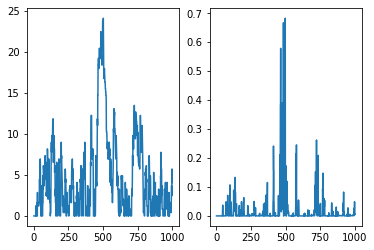

model is saved..

Trial 9

maximum steps, simulation is done ... 
elapsed_time: 9.468
Episode: 1 Exploration P: 1.0000 Total reward: -3298.033604273636 SOC: 1.0000 Cumulative_SOC_deviation: 354.9047 Fuel Consumption: 103.8914

maximum steps, simulation is done ... 
elapsed_time: 9.079
Episode: 2 Exploration P: 1.0000 Total reward: -3292.225177489385 SOC: 1.0000 Cumulative_SOC_deviation: 354.6869 Fuel Consumption: 100.0427

maximum steps, simulation is done ... 
elapsed_time: 9.103
Episode: 3 Exploration P: 1.0000 Total reward: -3313.930867925528 SOC: 1.0000 Cumulative_SOC_deviation: 356.8109 Fuel Consumption: 102.6326

maximum steps, simulation is done ... 
elapsed_time: 9.142
Episode: 4 Exploration P: 1.0000 Total reward: -3288.304167469331 SOC: 1.0000 Cumulative_SOC_deviation: 354.1859 Fuel Consumption: 100.6309


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X mode

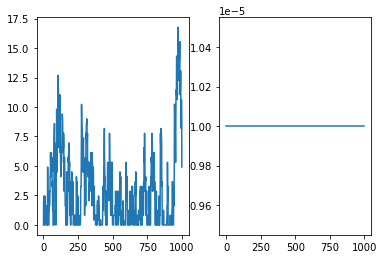

maximum steps, simulation is done ... 
elapsed_time: 50.411
Episode: 11 Exploration P: 0.8879 Total reward: -3249.9421810395124 SOC: 1.0000 Cumulative_SOC_deviation: 350.3523 Fuel Consumption: 96.7719

maximum steps, simulation is done ... 
elapsed_time: 51.038
Episode: 12 Exploration P: 0.8705 Total reward: -3210.401902890849 SOC: 1.0000 Cumulative_SOC_deviation: 346.2891 Fuel Consumption: 93.8002

maximum steps, simulation is done ... 
elapsed_time: 51.251
Episode: 13 Exploration P: 0.8534 Total reward: -3208.3862349172455 SOC: 1.0000 Cumulative_SOC_deviation: 346.9341 Fuel Consumption: 85.9791

maximum steps, simulation is done ... 
elapsed_time: 51.308
Episode: 14 Exploration P: 0.8367 Total reward: -3202.4361364382144 SOC: 1.0000 Cumulative_SOC_deviation: 346.3120 Fuel Consumption: 85.6283

maximum steps, simulation is done ... 
elapsed_time: 51.332
Episode: 15 Exploration P: 0.8203 Total reward: -3141.368360743435 SOC: 1.0000 Cumulative_SOC_deviation: 339.8878 Fuel Consumption: 8

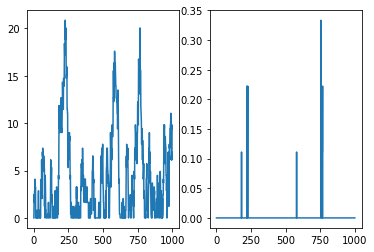

maximum steps, simulation is done ... 
elapsed_time: 50.721
Episode: 21 Exploration P: 0.7286 Total reward: -3117.3264537207237 SOC: 1.0000 Cumulative_SOC_deviation: 338.1486 Fuel Consumption: 73.9894

maximum steps, simulation is done ... 
elapsed_time: 51.331
Episode: 22 Exploration P: 0.7144 Total reward: -2998.5912051107616 SOC: 1.0000 Cumulative_SOC_deviation: 324.7677 Fuel Consumption: 75.6816

maximum steps, simulation is done ... 
elapsed_time: 51.436
Episode: 23 Exploration P: 0.7004 Total reward: -2985.6201161431504 SOC: 1.0000 Cumulative_SOC_deviation: 323.9593 Fuel Consumption: 69.9860

maximum steps, simulation is done ... 
elapsed_time: 51.531
Episode: 24 Exploration P: 0.6867 Total reward: -2984.027455323159 SOC: 1.0000 Cumulative_SOC_deviation: 322.7873 Fuel Consumption: 78.9421

maximum steps, simulation is done ... 
elapsed_time: 51.611
Episode: 25 Exploration P: 0.6733 Total reward: -3106.700121928945 SOC: 1.0000 Cumulative_SOC_deviation: 336.9094 Fuel Consumption: 7

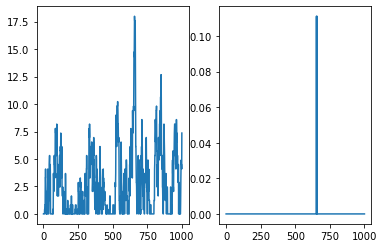

maximum steps, simulation is done ... 
elapsed_time: 50.968
Episode: 31 Exploration P: 0.5982 Total reward: -2921.8962594201257 SOC: 1.0000 Cumulative_SOC_deviation: 317.4992 Fuel Consumption: 64.4039

maximum steps, simulation is done ... 
elapsed_time: 51.860
Episode: 32 Exploration P: 0.5866 Total reward: -2870.2034505270294 SOC: 0.9693 Cumulative_SOC_deviation: 309.8650 Fuel Consumption: 81.4185

maximum steps, simulation is done ... 
elapsed_time: 51.486
Episode: 33 Exploration P: 0.5751 Total reward: -2421.86979591807 SOC: 0.9996 Cumulative_SOC_deviation: 260.5202 Fuel Consumption: 77.1880

maximum steps, simulation is done ... 
elapsed_time: 51.949
Episode: 34 Exploration P: 0.5639 Total reward: -2952.7343388026306 SOC: 1.0000 Cumulative_SOC_deviation: 320.9955 Fuel Consumption: 63.7745

maximum steps, simulation is done ... 
elapsed_time: 51.719
Episode: 35 Exploration P: 0.5530 Total reward: -2827.091550188174 SOC: 1.0000 Cumulative_SOC_deviation: 306.8403 Fuel Consumption: 65

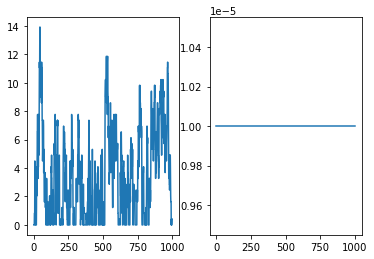

maximum steps, simulation is done ... 
elapsed_time: 51.227
Episode: 41 Exploration P: 0.4915 Total reward: -2701.6320302365866 SOC: 1.0000 Cumulative_SOC_deviation: 294.0549 Fuel Consumption: 55.1382

maximum steps, simulation is done ... 
elapsed_time: 51.891
Episode: 42 Exploration P: 0.4820 Total reward: -2584.355460226585 SOC: 0.9986 Cumulative_SOC_deviation: 280.9955 Fuel Consumption: 55.3961

maximum steps, simulation is done ... 
elapsed_time: 51.583
Episode: 43 Exploration P: 0.4726 Total reward: -2793.7033780704933 SOC: 1.0000 Cumulative_SOC_deviation: 304.1922 Fuel Consumption: 55.9739

maximum steps, simulation is done ... 
elapsed_time: 51.745
Episode: 44 Exploration P: 0.4634 Total reward: -2624.472899220314 SOC: 1.0000 Cumulative_SOC_deviation: 285.6421 Fuel Consumption: 53.6936

maximum steps, simulation is done ... 
elapsed_time: 51.848
Episode: 45 Exploration P: 0.4544 Total reward: -2806.940380343713 SOC: 0.9995 Cumulative_SOC_deviation: 305.9541 Fuel Consumption: 53

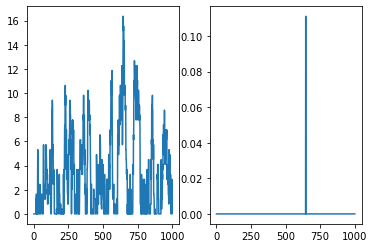

maximum steps, simulation is done ... 
elapsed_time: 51.151
Episode: 51 Exploration P: 0.4041 Total reward: -2618.122815021601 SOC: 1.0000 Cumulative_SOC_deviation: 285.4685 Fuel Consumption: 48.9060

maximum steps, simulation is done ... 
elapsed_time: 51.936
Episode: 52 Exploration P: 0.3963 Total reward: -2447.777467821811 SOC: 1.0000 Cumulative_SOC_deviation: 266.5722 Fuel Consumption: 48.6274

maximum steps, simulation is done ... 
elapsed_time: 51.757
Episode: 53 Exploration P: 0.3887 Total reward: -2111.2092720093733 SOC: 0.9998 Cumulative_SOC_deviation: 229.1907 Fuel Consumption: 48.4933

maximum steps, simulation is done ... 
elapsed_time: 51.995
Episode: 54 Exploration P: 0.3812 Total reward: -2326.2463646026176 SOC: 1.0000 Cumulative_SOC_deviation: 252.6045 Fuel Consumption: 52.8063

maximum steps, simulation is done ... 
elapsed_time: 52.210
Episode: 55 Exploration P: 0.3738 Total reward: -1906.7881766095577 SOC: 0.7641 Cumulative_SOC_deviation: 204.7380 Fuel Consumption: 6

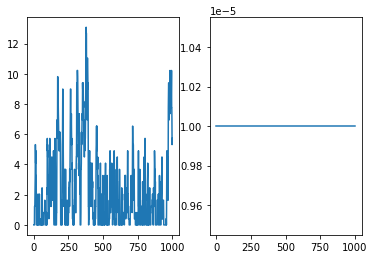

maximum steps, simulation is done ... 
elapsed_time: 51.368
Episode: 61 Exploration P: 0.3326 Total reward: -2455.580732695349 SOC: 1.0000 Cumulative_SOC_deviation: 267.7878 Fuel Consumption: 45.4907

maximum steps, simulation is done ... 
elapsed_time: 52.186
Episode: 62 Exploration P: 0.3262 Total reward: -2296.9931855867335 SOC: 1.0000 Cumulative_SOC_deviation: 250.7138 Fuel Consumption: 40.5690

maximum steps, simulation is done ... 
elapsed_time: 52.141
Episode: 63 Exploration P: 0.3200 Total reward: -2303.9858910069565 SOC: 1.0000 Cumulative_SOC_deviation: 251.3199 Fuel Consumption: 42.1064

maximum steps, simulation is done ... 
elapsed_time: 51.938
Episode: 64 Exploration P: 0.3138 Total reward: -1771.190957154688 SOC: 0.9720 Cumulative_SOC_deviation: 192.4106 Fuel Consumption: 39.4959

maximum steps, simulation is done ... 
elapsed_time: 51.854
Episode: 65 Exploration P: 0.3078 Total reward: -1931.3356392481335 SOC: 1.0000 Cumulative_SOC_deviation: 210.1746 Fuel Consumption: 3

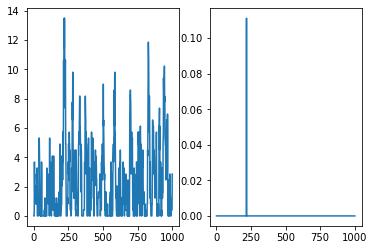

maximum steps, simulation is done ... 
elapsed_time: 52.242
Episode: 71 Exploration P: 0.2741 Total reward: -1675.9757181007542 SOC: 0.9462 Cumulative_SOC_deviation: 181.7761 Fuel Consumption: 39.9912

maximum steps, simulation is done ... 
elapsed_time: 51.917
Episode: 72 Exploration P: 0.2689 Total reward: -2059.752176931367 SOC: 1.0000 Cumulative_SOC_deviation: 224.6781 Fuel Consumption: 37.6489

maximum steps, simulation is done ... 
elapsed_time: 52.084
Episode: 73 Exploration P: 0.2637 Total reward: -1777.953822404331 SOC: 0.9282 Cumulative_SOC_deviation: 193.4005 Fuel Consumption: 37.3497

maximum steps, simulation is done ... 
elapsed_time: 52.069
Episode: 74 Exploration P: 0.2587 Total reward: -1559.7651085405505 SOC: 0.9151 Cumulative_SOC_deviation: 169.2066 Fuel Consumption: 36.9060

maximum steps, simulation is done ... 
elapsed_time: 52.392
Episode: 75 Exploration P: 0.2538 Total reward: -1465.9124417799762 SOC: 0.8957 Cumulative_SOC_deviation: 158.7945 Fuel Consumption: 3

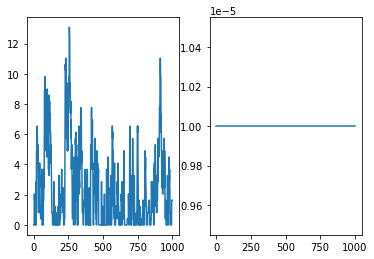

maximum steps, simulation is done ... 
elapsed_time: 52.174
Episode: 81 Exploration P: 0.2262 Total reward: -453.9731746577348 SOC: 0.7386 Cumulative_SOC_deviation: 45.8283 Fuel Consumption: 41.5182

maximum steps, simulation is done ... 
elapsed_time: 52.294
Episode: 82 Exploration P: 0.2219 Total reward: -867.5936780025398 SOC: 0.7541 Cumulative_SOC_deviation: 92.9533 Fuel Consumption: 31.0144

maximum steps, simulation is done ... 
elapsed_time: 51.920
Episode: 83 Exploration P: 0.2177 Total reward: -1358.7064244364456 SOC: 0.8567 Cumulative_SOC_deviation: 146.7314 Fuel Consumption: 38.1236

maximum steps, simulation is done ... 
elapsed_time: 52.472
Episode: 84 Exploration P: 0.2136 Total reward: -1397.9705191781338 SOC: 0.8661 Cumulative_SOC_deviation: 151.6616 Fuel Consumption: 33.0161

maximum steps, simulation is done ... 
elapsed_time: 52.043
Episode: 85 Exploration P: 0.2095 Total reward: -1103.5773927681 SOC: 0.8800 Cumulative_SOC_deviation: 118.7644 Fuel Consumption: 34.697

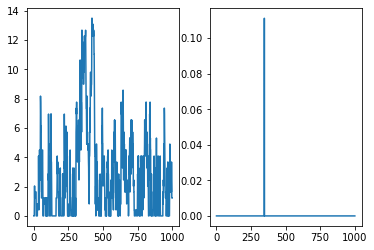

maximum steps, simulation is done ... 
elapsed_time: 51.878
Episode: 91 Exploration P: 0.1870 Total reward: -1139.8767674428964 SOC: 0.8600 Cumulative_SOC_deviation: 123.5864 Fuel Consumption: 27.5991

maximum steps, simulation is done ... 
elapsed_time: 52.192
Episode: 92 Exploration P: 0.1834 Total reward: -1034.5082773620902 SOC: 0.8148 Cumulative_SOC_deviation: 112.0473 Fuel Consumption: 26.0823

maximum steps, simulation is done ... 
elapsed_time: 52.425
Episode: 93 Exploration P: 0.1800 Total reward: -1062.285178249687 SOC: 0.8247 Cumulative_SOC_deviation: 115.1073 Fuel Consumption: 26.3196

maximum steps, simulation is done ... 
elapsed_time: 51.998
Episode: 94 Exploration P: 0.1766 Total reward: -682.2895419594203 SOC: 0.7917 Cumulative_SOC_deviation: 72.7938 Fuel Consumption: 27.1451

maximum steps, simulation is done ... 
elapsed_time: 52.311
Episode: 95 Exploration P: 0.1733 Total reward: -497.09658538506557 SOC: 0.5669 Cumulative_SOC_deviation: 50.9328 Fuel Consumption: 38.

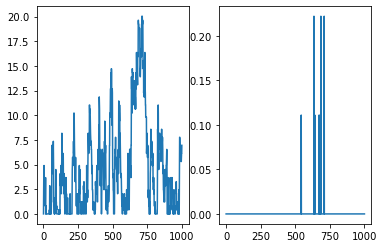

maximum steps, simulation is done ... 
elapsed_time: 52.176
Episode: 101 Exploration P: 0.1549 Total reward: -776.2726048046967 SOC: 0.7271 Cumulative_SOC_deviation: 83.9392 Fuel Consumption: 20.8201

maximum steps, simulation is done ... 
elapsed_time: 52.222
Episode: 102 Exploration P: 0.1520 Total reward: -927.8536622782374 SOC: 0.7220 Cumulative_SOC_deviation: 100.1005 Fuel Consumption: 26.9490

maximum steps, simulation is done ... 
elapsed_time: 52.225
Episode: 103 Exploration P: 0.1492 Total reward: -1000.1758449268938 SOC: 0.7876 Cumulative_SOC_deviation: 108.2464 Fuel Consumption: 25.9585

maximum steps, simulation is done ... 
elapsed_time: 52.410
Episode: 104 Exploration P: 0.1464 Total reward: -375.66590972248804 SOC: 0.6867 Cumulative_SOC_deviation: 39.6818 Fuel Consumption: 18.5294

battery power is 106169.92070603525(+) but condition is not avail
elapsed_time: 47.043
Episode: 105 Exploration P: 0.1440 Total reward: -1438.9159241138093 SOC: 0.4578 Cumulative_SOC_deviation

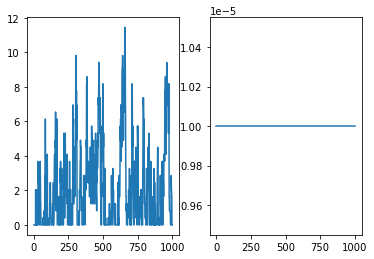

maximum steps, simulation is done ... 
elapsed_time: 52.395
Episode: 111 Exploration P: 0.1288 Total reward: -689.0246986246007 SOC: 0.7520 Cumulative_SOC_deviation: 74.3298 Fuel Consumption: 20.0565

maximum steps, simulation is done ... 
elapsed_time: 52.379
Episode: 112 Exploration P: 0.1264 Total reward: -317.51657491826643 SOC: 0.6762 Cumulative_SOC_deviation: 33.0924 Fuel Consumption: 19.6851

maximum steps, simulation is done ... 
elapsed_time: 52.397
Episode: 113 Exploration P: 0.1241 Total reward: -223.7653258063839 SOC: 0.6497 Cumulative_SOC_deviation: 22.8200 Fuel Consumption: 18.3850

maximum steps, simulation is done ... 
elapsed_time: 52.316
Episode: 114 Exploration P: 0.1219 Total reward: -440.0309822711131 SOC: 0.7156 Cumulative_SOC_deviation: 46.7842 Fuel Consumption: 18.9731

maximum steps, simulation is done ... 
elapsed_time: 52.093
Episode: 115 Exploration P: 0.1197 Total reward: -411.33198672259596 SOC: 0.6872 Cumulative_SOC_deviation: 43.4682 Fuel Consumption: 20

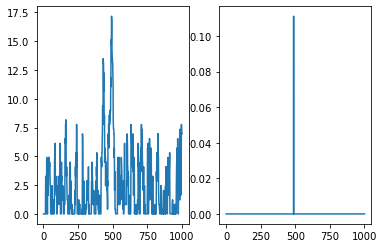

maximum steps, simulation is done ... 
elapsed_time: 52.355
Episode: 121 Exploration P: 0.1072 Total reward: -384.96351210538967 SOC: 0.6955 Cumulative_SOC_deviation: 41.1655 Fuel Consumption: 14.4744

maximum steps, simulation is done ... 
elapsed_time: 52.802
Episode: 122 Exploration P: 0.1053 Total reward: -663.8192085143222 SOC: 0.7107 Cumulative_SOC_deviation: 71.9660 Fuel Consumption: 16.1253

maximum steps, simulation is done ... 
elapsed_time: 52.425
Episode: 123 Exploration P: 0.1034 Total reward: -339.2374475876372 SOC: 0.6667 Cumulative_SOC_deviation: 35.9988 Fuel Consumption: 15.2483

maximum steps, simulation is done ... 
elapsed_time: 52.582
Episode: 124 Exploration P: 0.1016 Total reward: -196.7255429497598 SOC: 0.5888 Cumulative_SOC_deviation: 19.9234 Fuel Consumption: 17.4151

maximum steps, simulation is done ... 
elapsed_time: 52.339
Episode: 125 Exploration P: 0.0998 Total reward: -294.77520814730565 SOC: 0.6722 Cumulative_SOC_deviation: 31.1560 Fuel Consumption: 14

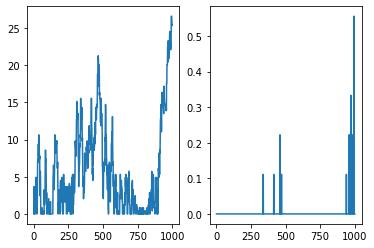

maximum steps, simulation is done ... 
elapsed_time: 52.880
Episode: 131 Exploration P: 0.0896 Total reward: -194.25530345608814 SOC: 0.6327 Cumulative_SOC_deviation: 20.0204 Fuel Consumption: 14.0720

maximum steps, simulation is done ... 
elapsed_time: 52.335
Episode: 132 Exploration P: 0.0880 Total reward: -181.28362681889493 SOC: 0.5854 Cumulative_SOC_deviation: 18.5676 Fuel Consumption: 14.1752

maximum steps, simulation is done ... 
elapsed_time: 52.429
Episode: 133 Exploration P: 0.0865 Total reward: -260.58407194461284 SOC: 0.6664 Cumulative_SOC_deviation: 27.5221 Fuel Consumption: 12.8854

maximum steps, simulation is done ... 
elapsed_time: 52.450
Episode: 134 Exploration P: 0.0850 Total reward: -315.36341391530124 SOC: 0.6536 Cumulative_SOC_deviation: 33.5341 Fuel Consumption: 13.5561

maximum steps, simulation is done ... 
elapsed_time: 52.548
Episode: 135 Exploration P: 0.0835 Total reward: -247.12817707198053 SOC: 0.6519 Cumulative_SOC_deviation: 25.9777 Fuel Consumption:

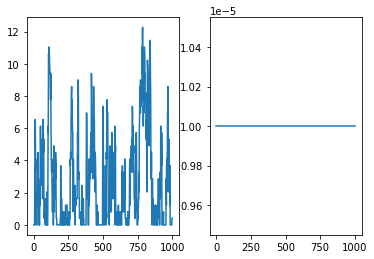

maximum steps, simulation is done ... 
elapsed_time: 52.140
Episode: 141 Exploration P: 0.0752 Total reward: -664.9357796903262 SOC: 0.4205 Cumulative_SOC_deviation: 72.0625 Fuel Consumption: 16.3729

maximum steps, simulation is done ... 
elapsed_time: 52.383
Episode: 142 Exploration P: 0.0739 Total reward: -616.3049756630503 SOC: 0.3776 Cumulative_SOC_deviation: 66.0756 Fuel Consumption: 21.6249

maximum steps, simulation is done ... 
elapsed_time: 52.155
Episode: 143 Exploration P: 0.0726 Total reward: -154.93639827420049 SOC: 0.6193 Cumulative_SOC_deviation: 15.9130 Fuel Consumption: 11.7195

maximum steps, simulation is done ... 
elapsed_time: 52.520
Episode: 144 Exploration P: 0.0714 Total reward: -145.79633725597017 SOC: 0.5769 Cumulative_SOC_deviation: 15.0992 Fuel Consumption: 9.9035

maximum steps, simulation is done ... 
elapsed_time: 52.628
Episode: 145 Exploration P: 0.0701 Total reward: -224.30812423509133 SOC: 0.5807 Cumulative_SOC_deviation: 23.6542 Fuel Consumption: 11

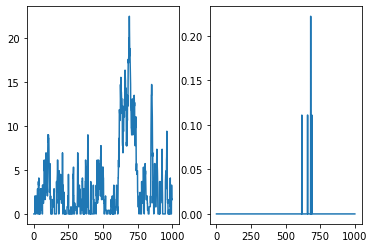

maximum steps, simulation is done ... 
elapsed_time: 52.202
Episode: 151 Exploration P: 0.0633 Total reward: -98.25255809913597 SOC: 0.5988 Cumulative_SOC_deviation: 9.7501 Fuel Consumption: 10.5019

maximum steps, simulation is done ... 
elapsed_time: 52.386
Episode: 152 Exploration P: 0.0623 Total reward: -392.51860638075306 SOC: 0.5375 Cumulative_SOC_deviation: 42.1345 Fuel Consumption: 13.3084

maximum steps, simulation is done ... 
elapsed_time: 52.169
Episode: 153 Exploration P: 0.0612 Total reward: -1149.547241396886 SOC: 0.3619 Cumulative_SOC_deviation: 126.0034 Fuel Consumption: 15.5165

maximum steps, simulation is done ... 
elapsed_time: 52.566
Episode: 154 Exploration P: 0.0602 Total reward: -200.2175617653438 SOC: 0.5574 Cumulative_SOC_deviation: 21.2607 Fuel Consumption: 8.8716

maximum steps, simulation is done ... 
elapsed_time: 52.027
Episode: 155 Exploration P: 0.0592 Total reward: -384.326443774733 SOC: 0.5386 Cumulative_SOC_deviation: 41.7161 Fuel Consumption: 8.882

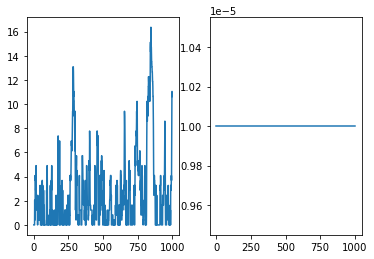

maximum steps, simulation is done ... 
elapsed_time: 51.949
Episode: 161 Exploration P: 0.0537 Total reward: -167.39019347082044 SOC: 0.5443 Cumulative_SOC_deviation: 17.5375 Fuel Consumption: 9.5526

maximum steps, simulation is done ... 
elapsed_time: 52.274
Episode: 162 Exploration P: 0.0528 Total reward: -1076.7577472973458 SOC: 0.3867 Cumulative_SOC_deviation: 118.5199 Fuel Consumption: 10.0789

maximum steps, simulation is done ... 
elapsed_time: 52.386
Episode: 163 Exploration P: 0.0519 Total reward: -121.96991586416175 SOC: 0.5667 Cumulative_SOC_deviation: 12.7832 Fuel Consumption: 6.9215

maximum steps, simulation is done ... 
elapsed_time: 51.909
Episode: 164 Exploration P: 0.0511 Total reward: -547.1889102183162 SOC: 0.3662 Cumulative_SOC_deviation: 59.1206 Fuel Consumption: 15.1038

maximum steps, simulation is done ... 
elapsed_time: 52.319
Episode: 165 Exploration P: 0.0503 Total reward: -91.5234680706701 SOC: 0.5393 Cumulative_SOC_deviation: 9.2741 Fuel Consumption: 8.05

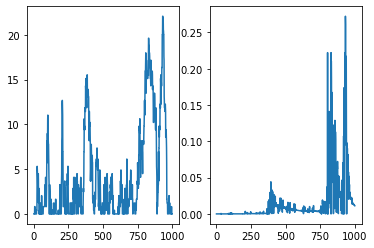

maximum steps, simulation is done ... 
elapsed_time: 52.257
Episode: 171 Exploration P: 0.0457 Total reward: -98.77413348771627 SOC: 0.5863 Cumulative_SOC_deviation: 9.9783 Fuel Consumption: 8.9697

maximum steps, simulation is done ... 
elapsed_time: 52.463
Episode: 172 Exploration P: 0.0450 Total reward: -215.9279599749489 SOC: 0.5981 Cumulative_SOC_deviation: 21.6369 Fuel Consumption: 21.1957

maximum steps, simulation is done ... 
elapsed_time: 52.629
Episode: 173 Exploration P: 0.0443 Total reward: -152.1101703570072 SOC: 0.5793 Cumulative_SOC_deviation: 16.1457 Fuel Consumption: 6.7990

maximum steps, simulation is done ... 
elapsed_time: 52.398
Episode: 174 Exploration P: 0.0437 Total reward: -82.38242653654365 SOC: 0.5944 Cumulative_SOC_deviation: 8.2278 Fuel Consumption: 8.3324

maximum steps, simulation is done ... 
elapsed_time: 52.699
Episode: 175 Exploration P: 0.0430 Total reward: -96.92696199062237 SOC: 0.5971 Cumulative_SOC_deviation: 9.7302 Fuel Consumption: 9.3551

ma

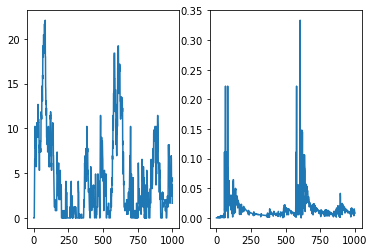

maximum steps, simulation is done ... 
elapsed_time: 52.384
Episode: 181 Exploration P: 0.0393 Total reward: -179.52311602013185 SOC: 0.5917 Cumulative_SOC_deviation: 18.8904 Fuel Consumption: 9.5097

maximum steps, simulation is done ... 
elapsed_time: 52.474
Episode: 182 Exploration P: 0.0387 Total reward: -214.85361845036275 SOC: 0.5505 Cumulative_SOC_deviation: 22.8041 Fuel Consumption: 9.6164

maximum steps, simulation is done ... 
elapsed_time: 52.571
Episode: 183 Exploration P: 0.0381 Total reward: -134.23882959028194 SOC: 0.5843 Cumulative_SOC_deviation: 14.0970 Fuel Consumption: 7.3660

maximum steps, simulation is done ... 
elapsed_time: 52.084
Episode: 184 Exploration P: 0.0375 Total reward: -229.91468921253255 SOC: 0.5744 Cumulative_SOC_deviation: 24.6247 Fuel Consumption: 8.2922

maximum steps, simulation is done ... 
elapsed_time: 51.970
Episode: 185 Exploration P: 0.0370 Total reward: -322.53744514345675 SOC: 0.5720 Cumulative_SOC_deviation: 31.0379 Fuel Consumption: 43.

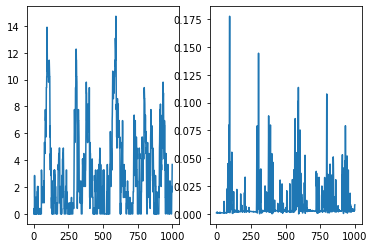

maximum steps, simulation is done ... 
elapsed_time: 52.418
Episode: 191 Exploration P: 0.0339 Total reward: -99.30942968531043 SOC: 0.6033 Cumulative_SOC_deviation: 10.1949 Fuel Consumption: 7.5551

maximum steps, simulation is done ... 
elapsed_time: 52.606
Episode: 192 Exploration P: 0.0335 Total reward: -90.70656717583145 SOC: 0.5581 Cumulative_SOC_deviation: 9.3174 Fuel Consumption: 6.8497

maximum steps, simulation is done ... 
elapsed_time: 52.420
Episode: 193 Exploration P: 0.0330 Total reward: -77.34780003588261 SOC: 0.5851 Cumulative_SOC_deviation: 8.0104 Fuel Consumption: 5.2541

maximum steps, simulation is done ... 
elapsed_time: 52.573
Episode: 194 Exploration P: 0.0326 Total reward: -278.0452271218072 SOC: 0.5778 Cumulative_SOC_deviation: 29.2873 Fuel Consumption: 14.4592

maximum steps, simulation is done ... 
elapsed_time: 52.433
Episode: 195 Exploration P: 0.0321 Total reward: -48.26333144969958 SOC: 0.5858 Cumulative_SOC_deviation: 4.3461 Fuel Consumption: 9.1488

ma

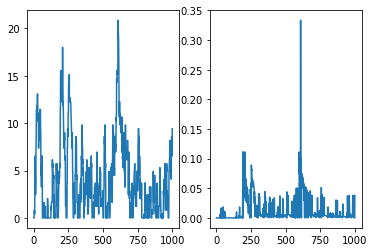

maximum steps, simulation is done ... 
elapsed_time: 52.366
Episode: 201 Exploration P: 0.0296 Total reward: -75.10972850049421 SOC: 0.5873 Cumulative_SOC_deviation: 7.5599 Fuel Consumption: 7.0703

maximum steps, simulation is done ... 
elapsed_time: 52.274
Episode: 202 Exploration P: 0.0292 Total reward: -96.65570434585437 SOC: 0.6026 Cumulative_SOC_deviation: 9.5782 Fuel Consumption: 10.4519

maximum steps, simulation is done ... 
elapsed_time: 52.483
Episode: 203 Exploration P: 0.0288 Total reward: -43.39911622723707 SOC: 0.6022 Cumulative_SOC_deviation: 3.9780 Fuel Consumption: 7.5974

maximum steps, simulation is done ... 
elapsed_time: 52.345
Episode: 204 Exploration P: 0.0285 Total reward: -57.95920726232493 SOC: 0.5990 Cumulative_SOC_deviation: 5.4238 Fuel Consumption: 9.1454

maximum steps, simulation is done ... 
elapsed_time: 52.373
Episode: 205 Exploration P: 0.0281 Total reward: -51.11937453143047 SOC: 0.6018 Cumulative_SOC_deviation: 3.9685 Fuel Consumption: 15.4027

max

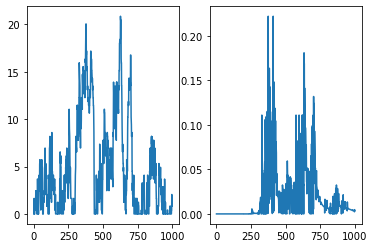

maximum steps, simulation is done ... 
elapsed_time: 52.109
Episode: 211 Exploration P: 0.0260 Total reward: -178.84266261184993 SOC: 0.5686 Cumulative_SOC_deviation: 19.3061 Fuel Consumption: 5.0882

maximum steps, simulation is done ... 
elapsed_time: 52.501
Episode: 212 Exploration P: 0.0257 Total reward: -390.9406953840758 SOC: 0.5897 Cumulative_SOC_deviation: 39.2243 Fuel Consumption: 37.9217

maximum steps, simulation is done ... 
elapsed_time: 52.449
Episode: 213 Exploration P: 0.0254 Total reward: -89.77316654950077 SOC: 0.5966 Cumulative_SOC_deviation: 8.4126 Fuel Consumption: 14.0594

maximum steps, simulation is done ... 
elapsed_time: 52.420
Episode: 214 Exploration P: 0.0251 Total reward: -43.98450624340183 SOC: 0.6023 Cumulative_SOC_deviation: 4.0608 Fuel Consumption: 7.4372

maximum steps, simulation is done ... 
elapsed_time: 52.813
Episode: 215 Exploration P: 0.0248 Total reward: -71.09193080049292 SOC: 0.6005 Cumulative_SOC_deviation: 5.3418 Fuel Consumption: 23.0158


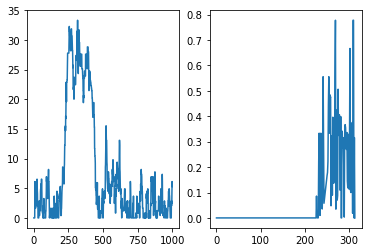

maximum steps, simulation is done ... 
elapsed_time: 52.545
Episode: 221 Exploration P: 0.0231 Total reward: -174.927184968111 SOC: 0.5856 Cumulative_SOC_deviation: 17.3373 Fuel Consumption: 18.8915

maximum steps, simulation is done ... 
elapsed_time: 52.266
Episode: 222 Exploration P: 0.0229 Total reward: -149.80535105861392 SOC: 0.5643 Cumulative_SOC_deviation: 16.0988 Fuel Consumption: 4.9160

maximum steps, simulation is done ... 
elapsed_time: 52.796
Episode: 223 Exploration P: 0.0226 Total reward: -251.85099123541096 SOC: 0.5301 Cumulative_SOC_deviation: 27.2923 Fuel Consumption: 6.2199

maximum steps, simulation is done ... 
elapsed_time: 52.433
Episode: 224 Exploration P: 0.0224 Total reward: -459.0952519815275 SOC: 0.4532 Cumulative_SOC_deviation: 50.5109 Fuel Consumption: 4.4970

maximum steps, simulation is done ... 
elapsed_time: 52.721
Episode: 225 Exploration P: 0.0221 Total reward: -129.87145451404018 SOC: 0.5619 Cumulative_SOC_deviation: 13.9087 Fuel Consumption: 4.692

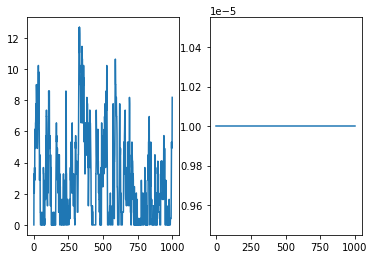

maximum steps, simulation is done ... 
elapsed_time: 52.691
Episode: 231 Exploration P: 0.0208 Total reward: -390.57307655901946 SOC: 0.5262 Cumulative_SOC_deviation: 42.8928 Fuel Consumption: 4.5380

maximum steps, simulation is done ... 
elapsed_time: 52.390
Episode: 232 Exploration P: 0.0205 Total reward: -994.5503682111871 SOC: 0.4282 Cumulative_SOC_deviation: 109.9337 Fuel Consumption: 5.1468

maximum steps, simulation is done ... 
elapsed_time: 52.556
Episode: 233 Exploration P: 0.0203 Total reward: -680.3343876880439 SOC: 0.4757 Cumulative_SOC_deviation: 75.2501 Fuel Consumption: 3.0832

maximum steps, simulation is done ... 
elapsed_time: 52.396
Episode: 234 Exploration P: 0.0201 Total reward: -649.1415940774604 SOC: 0.4676 Cumulative_SOC_deviation: 71.7063 Fuel Consumption: 3.7848

maximum steps, simulation is done ... 
elapsed_time: 52.389
Episode: 235 Exploration P: 0.0199 Total reward: -405.31977350729295 SOC: 0.5029 Cumulative_SOC_deviation: 44.7159 Fuel Consumption: 2.876

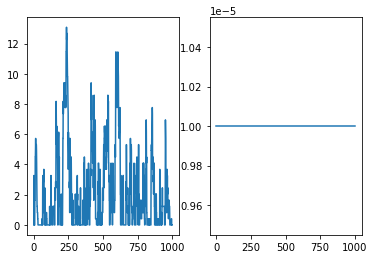

maximum steps, simulation is done ... 
elapsed_time: 52.780
Episode: 241 Exploration P: 0.0188 Total reward: -354.8015501763984 SOC: 0.5389 Cumulative_SOC_deviation: 39.2392 Fuel Consumption: 1.6490

maximum steps, simulation is done ... 
elapsed_time: 52.551
Episode: 242 Exploration P: 0.0186 Total reward: -761.318058682069 SOC: 0.4511 Cumulative_SOC_deviation: 84.3079 Fuel Consumption: 2.5466

maximum steps, simulation is done ... 
elapsed_time: 52.399
Episode: 243 Exploration P: 0.0185 Total reward: -304.75636415576247 SOC: 0.5319 Cumulative_SOC_deviation: 33.4447 Fuel Consumption: 3.7539

maximum steps, simulation is done ... 
elapsed_time: 52.814
Episode: 244 Exploration P: 0.0183 Total reward: -574.5335913677244 SOC: 0.4751 Cumulative_SOC_deviation: 63.5965 Fuel Consumption: 2.1649

maximum steps, simulation is done ... 
elapsed_time: 52.613
Episode: 245 Exploration P: 0.0181 Total reward: -333.42643912058855 SOC: 0.5415 Cumulative_SOC_deviation: 36.7690 Fuel Consumption: 2.5054


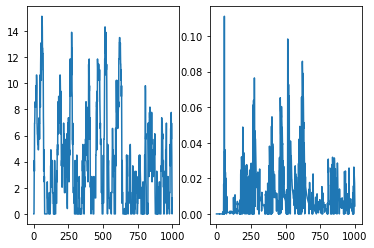

maximum steps, simulation is done ... 
elapsed_time: 52.617
Episode: 251 Exploration P: 0.0172 Total reward: -226.65593715212677 SOC: 0.5741 Cumulative_SOC_deviation: 24.3446 Fuel Consumption: 7.5544

maximum steps, simulation is done ... 
elapsed_time: 52.438
Episode: 252 Exploration P: 0.0171 Total reward: -71.98920631581409 SOC: 0.6003 Cumulative_SOC_deviation: 7.1074 Fuel Consumption: 8.0230

maximum steps, simulation is done ... 
elapsed_time: 52.646
Episode: 253 Exploration P: 0.0169 Total reward: -140.13149744142137 SOC: 0.5965 Cumulative_SOC_deviation: 12.3078 Fuel Consumption: 29.3613

maximum steps, simulation is done ... 
elapsed_time: 52.462
Episode: 254 Exploration P: 0.0168 Total reward: -302.36494720102655 SOC: 0.5100 Cumulative_SOC_deviation: 33.0780 Fuel Consumption: 4.6628

maximum steps, simulation is done ... 
elapsed_time: 52.898
Episode: 255 Exploration P: 0.0166 Total reward: -407.89052849919506 SOC: 0.5022 Cumulative_SOC_deviation: 45.0242 Fuel Consumption: 2.67

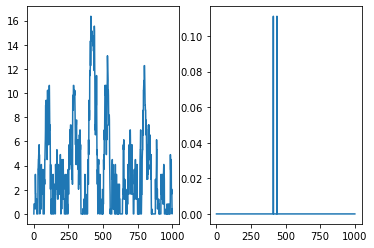

maximum steps, simulation is done ... 
elapsed_time: 52.602
Episode: 261 Exploration P: 0.0159 Total reward: -729.9791054079083 SOC: 0.4668 Cumulative_SOC_deviation: 80.7236 Fuel Consumption: 3.4664

battery power is 113165.17429351204(+) but condition is not avail
elapsed_time: 30.795
Episode: 262 Exploration P: 0.0158 Total reward: -1271.7452475814061 SOC: 0.2654 Cumulative_SOC_deviation: 29.0679 Fuel Consumption: 13.1455

maximum steps, simulation is done ... 
elapsed_time: 52.469
Episode: 263 Exploration P: 0.0157 Total reward: -194.89258087742652 SOC: 0.6031 Cumulative_SOC_deviation: 20.2142 Fuel Consumption: 12.9644

maximum steps, simulation is done ... 
elapsed_time: 52.435
Episode: 264 Exploration P: 0.0156 Total reward: -37.56542903254476 SOC: 0.6064 Cumulative_SOC_deviation: 3.5415 Fuel Consumption: 5.6922

maximum steps, simulation is done ... 
elapsed_time: 52.503
Episode: 265 Exploration P: 0.0155 Total reward: -45.581865087133494 SOC: 0.6031 Cumulative_SOC_deviation: 3.9

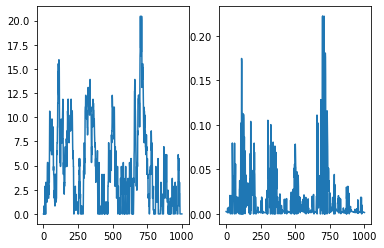

maximum steps, simulation is done ... 
elapsed_time: 52.517
Episode: 271 Exploration P: 0.0149 Total reward: -24.363232431013113 SOC: 0.6079 Cumulative_SOC_deviation: 1.7701 Fuel Consumption: 8.4327

maximum steps, simulation is done ... 
elapsed_time: 52.547
Episode: 272 Exploration P: 0.0148 Total reward: -28.653627849966558 SOC: 0.6006 Cumulative_SOC_deviation: 1.9956 Fuel Consumption: 10.6931

maximum steps, simulation is done ... 
elapsed_time: 52.351
Episode: 273 Exploration P: 0.0147 Total reward: -29.531619400815682 SOC: 0.6045 Cumulative_SOC_deviation: 2.2033 Fuel Consumption: 9.7018

maximum steps, simulation is done ... 
elapsed_time: 52.429
Episode: 274 Exploration P: 0.0146 Total reward: -48.75814822675382 SOC: 0.5754 Cumulative_SOC_deviation: 4.9861 Fuel Consumption: 3.8835

maximum steps, simulation is done ... 
elapsed_time: 52.250
Episode: 275 Exploration P: 0.0145 Total reward: -686.7810073754874 SOC: 0.4341 Cumulative_SOC_deviation: 76.0126 Fuel Consumption: 2.6679



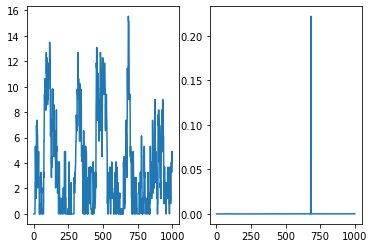

maximum steps, simulation is done ... 
elapsed_time: 52.516
Episode: 281 Exploration P: 0.0140 Total reward: -595.6719007409068 SOC: 0.4545 Cumulative_SOC_deviation: 65.9626 Fuel Consumption: 2.0082

maximum steps, simulation is done ... 
elapsed_time: 52.423
Episode: 282 Exploration P: 0.0139 Total reward: -81.04449993387213 SOC: 0.6053 Cumulative_SOC_deviation: 7.8823 Fuel Consumption: 10.1038

maximum steps, simulation is done ... 
elapsed_time: 52.497
Episode: 283 Exploration P: 0.0138 Total reward: -50.05330940481745 SOC: 0.6027 Cumulative_SOC_deviation: 4.7619 Fuel Consumption: 7.1963

maximum steps, simulation is done ... 
elapsed_time: 52.256
Episode: 284 Exploration P: 0.0138 Total reward: -46.400833737980165 SOC: 0.6008 Cumulative_SOC_deviation: 4.3997 Fuel Consumption: 6.8038

maximum steps, simulation is done ... 
elapsed_time: 52.361
Episode: 285 Exploration P: 0.0137 Total reward: -29.522922813754192 SOC: 0.6027 Cumulative_SOC_deviation: 2.1305 Fuel Consumption: 10.3481



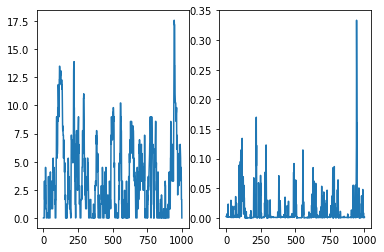

maximum steps, simulation is done ... 
elapsed_time: 52.577
Episode: 291 Exploration P: 0.0133 Total reward: -37.12796431310253 SOC: 0.5954 Cumulative_SOC_deviation: 2.1846 Fuel Consumption: 17.4668

maximum steps, simulation is done ... 
elapsed_time: 52.318
Episode: 292 Exploration P: 0.0132 Total reward: -30.426857334155592 SOC: 0.5693 Cumulative_SOC_deviation: 1.9555 Fuel Consumption: 12.8273

maximum steps, simulation is done ... 
elapsed_time: 52.580
Episode: 293 Exploration P: 0.0131 Total reward: -19.95495383734643 SOC: 0.5998 Cumulative_SOC_deviation: 1.4953 Fuel Consumption: 6.4969

maximum steps, simulation is done ... 
elapsed_time: 52.318
Episode: 294 Exploration P: 0.0131 Total reward: -22.77284982867589 SOC: 0.5994 Cumulative_SOC_deviation: 1.5878 Fuel Consumption: 8.4827

maximum steps, simulation is done ... 
elapsed_time: 52.536
Episode: 295 Exploration P: 0.0130 Total reward: -30.8261713818126 SOC: 0.6021 Cumulative_SOC_deviation: 2.5483 Fuel Consumption: 7.8917

max

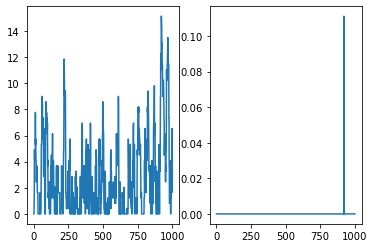

maximum steps, simulation is done ... 
elapsed_time: 52.250
Episode: 301 Exploration P: 0.0127 Total reward: -476.67392182979296 SOC: 0.5149 Cumulative_SOC_deviation: 52.6761 Fuel Consumption: 2.5886

maximum steps, simulation is done ... 
elapsed_time: 52.455
Episode: 302 Exploration P: 0.0126 Total reward: -377.7018727609825 SOC: 0.5414 Cumulative_SOC_deviation: 41.1659 Fuel Consumption: 7.2088

maximum steps, simulation is done ... 
elapsed_time: 52.033
Episode: 303 Exploration P: 0.0126 Total reward: -698.9249423705622 SOC: 0.3301 Cumulative_SOC_deviation: 72.5045 Fuel Consumption: 46.3841

maximum steps, simulation is done ... 
elapsed_time: 52.387
Episode: 304 Exploration P: 0.0125 Total reward: -39.56695673213577 SOC: 0.5997 Cumulative_SOC_deviation: 3.1516 Fuel Consumption: 11.2024

maximum steps, simulation is done ... 
elapsed_time: 51.630
Episode: 305 Exploration P: 0.0125 Total reward: -240.72679164329716 SOC: 0.5946 Cumulative_SOC_deviation: 23.1704 Fuel Consumption: 32.19

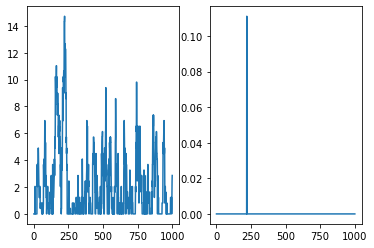

maximum steps, simulation is done ... 
elapsed_time: 52.485
Episode: 311 Exploration P: 0.0122 Total reward: -425.6387013827802 SOC: 0.5005 Cumulative_SOC_deviation: 47.1375 Fuel Consumption: 1.4013

maximum steps, simulation is done ... 
elapsed_time: 52.463
Episode: 312 Exploration P: 0.0121 Total reward: -661.2872741629502 SOC: 0.4512 Cumulative_SOC_deviation: 73.1980 Fuel Consumption: 2.5054

maximum steps, simulation is done ... 
elapsed_time: 52.724
Episode: 313 Exploration P: 0.0121 Total reward: -960.1101695493523 SOC: 0.3961 Cumulative_SOC_deviation: 106.3535 Fuel Consumption: 2.9284

maximum steps, simulation is done ... 
elapsed_time: 52.651
Episode: 314 Exploration P: 0.0121 Total reward: -505.76435598172424 SOC: 0.4654 Cumulative_SOC_deviation: 55.9406 Fuel Consumption: 2.2990

maximum steps, simulation is done ... 
elapsed_time: 52.412
Episode: 315 Exploration P: 0.0120 Total reward: -886.779928758759 SOC: 0.4355 Cumulative_SOC_deviation: 98.2006 Fuel Consumption: 2.9748


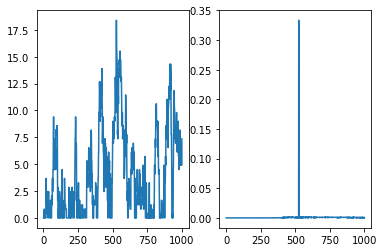

maximum steps, simulation is done ... 
elapsed_time: 52.406
Episode: 321 Exploration P: 0.0118 Total reward: -1511.8727881070774 SOC: 0.1031 Cumulative_SOC_deviation: 166.0592 Fuel Consumption: 17.3395

maximum steps, simulation is done ... 
elapsed_time: 52.533
Episode: 322 Exploration P: 0.0118 Total reward: -528.8095839001686 SOC: 0.4656 Cumulative_SOC_deviation: 58.5228 Fuel Consumption: 2.1048

maximum steps, simulation is done ... 
elapsed_time: 52.309
Episode: 323 Exploration P: 0.0117 Total reward: -294.6104045394673 SOC: 0.5376 Cumulative_SOC_deviation: 32.5169 Fuel Consumption: 1.9584

maximum steps, simulation is done ... 
elapsed_time: 52.276
Episode: 324 Exploration P: 0.0117 Total reward: -1449.6142918534144 SOC: 0.1783 Cumulative_SOC_deviation: 159.4812 Fuel Consumption: 14.2836

maximum steps, simulation is done ... 
elapsed_time: 52.757
Episode: 325 Exploration P: 0.0117 Total reward: -493.4379371169698 SOC: 0.4822 Cumulative_SOC_deviation: 54.5698 Fuel Consumption: 2.

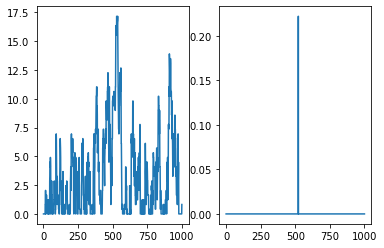

maximum steps, simulation is done ... 
elapsed_time: 52.393
Episode: 331 Exploration P: 0.0115 Total reward: -445.5627883599577 SOC: 0.4889 Cumulative_SOC_deviation: 49.2103 Fuel Consumption: 2.6704

maximum steps, simulation is done ... 
elapsed_time: 51.995
Episode: 332 Exploration P: 0.0114 Total reward: -602.0837926373375 SOC: 0.4798 Cumulative_SOC_deviation: 66.6840 Fuel Consumption: 1.9276

maximum steps, simulation is done ... 
elapsed_time: 52.197
Episode: 333 Exploration P: 0.0114 Total reward: -1856.3055151838232 SOC: 0.1753 Cumulative_SOC_deviation: 205.2165 Fuel Consumption: 9.3566

maximum steps, simulation is done ... 
elapsed_time: 52.637
Episode: 334 Exploration P: 0.0114 Total reward: -734.2425201050894 SOC: 0.4463 Cumulative_SOC_deviation: 81.3259 Fuel Consumption: 2.3094

maximum steps, simulation is done ... 
elapsed_time: 52.437
Episode: 335 Exploration P: 0.0114 Total reward: -644.4411354024112 SOC: 0.4704 Cumulative_SOC_deviation: 71.4351 Fuel Consumption: 1.5251

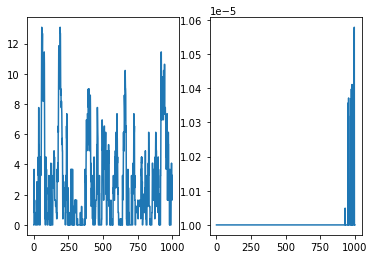

maximum steps, simulation is done ... 
elapsed_time: 52.415
Episode: 341 Exploration P: 0.0112 Total reward: -1409.1798211498553 SOC: 0.3455 Cumulative_SOC_deviation: 156.3201 Fuel Consumption: 2.2990

maximum steps, simulation is done ... 
elapsed_time: 52.353
Episode: 342 Exploration P: 0.0112 Total reward: -1678.5449410189367 SOC: 0.3160 Cumulative_SOC_deviation: 186.0707 Fuel Consumption: 3.9086

maximum steps, simulation is done ... 
elapsed_time: 52.662
Episode: 343 Exploration P: 0.0112 Total reward: -391.3699561325106 SOC: 0.5001 Cumulative_SOC_deviation: 43.3769 Fuel Consumption: 0.9783

maximum steps, simulation is done ... 
elapsed_time: 52.394
Episode: 344 Exploration P: 0.0111 Total reward: -779.0362435507118 SOC: 0.4758 Cumulative_SOC_deviation: 86.0863 Fuel Consumption: 4.2595

maximum steps, simulation is done ... 
elapsed_time: 52.030
Episode: 345 Exploration P: 0.0111 Total reward: -418.0725856785379 SOC: 0.4342 Cumulative_SOC_deviation: 46.2532 Fuel Consumption: 1.79

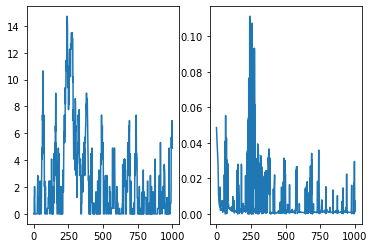

maximum steps, simulation is done ... 
elapsed_time: 52.659
Episode: 351 Exploration P: 0.0110 Total reward: -64.94743646109512 SOC: 0.6096 Cumulative_SOC_deviation: 6.4416 Fuel Consumption: 6.9732

maximum steps, simulation is done ... 
elapsed_time: 52.438
Episode: 352 Exploration P: 0.0110 Total reward: -89.4629576087512 SOC: 0.5203 Cumulative_SOC_deviation: 9.1715 Fuel Consumption: 6.9199

maximum steps, simulation is done ... 
elapsed_time: 52.313
Episode: 353 Exploration P: 0.0109 Total reward: -788.9132215006257 SOC: 0.3768 Cumulative_SOC_deviation: 87.2170 Fuel Consumption: 3.9607

maximum steps, simulation is done ... 
elapsed_time: 52.749
Episode: 354 Exploration P: 0.0109 Total reward: -49.886160106488006 SOC: 0.6005 Cumulative_SOC_deviation: 4.6542 Fuel Consumption: 7.9981

maximum steps, simulation is done ... 
elapsed_time: 52.212
Episode: 355 Exploration P: 0.0109 Total reward: -290.26044666038865 SOC: 0.5301 Cumulative_SOC_deviation: 31.7031 Fuel Consumption: 4.9330

ma

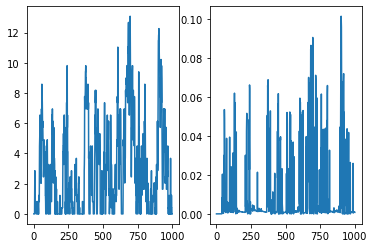

maximum steps, simulation is done ... 
elapsed_time: 52.440
Episode: 361 Exploration P: 0.0108 Total reward: -201.2452658613337 SOC: 0.5331 Cumulative_SOC_deviation: 22.1321 Fuel Consumption: 2.0566

maximum steps, simulation is done ... 
elapsed_time: 52.108
Episode: 362 Exploration P: 0.0108 Total reward: -374.4710341226526 SOC: 0.5938 Cumulative_SOC_deviation: 40.2917 Fuel Consumption: 11.8459

maximum steps, simulation is done ... 
elapsed_time: 52.472
Episode: 363 Exploration P: 0.0108 Total reward: -440.44415308888915 SOC: 0.4843 Cumulative_SOC_deviation: 48.8497 Fuel Consumption: 0.7967

maximum steps, simulation is done ... 
elapsed_time: 52.389
Episode: 364 Exploration P: 0.0108 Total reward: -205.0420934697433 SOC: 0.5399 Cumulative_SOC_deviation: 22.6096 Fuel Consumption: 1.5561

maximum steps, simulation is done ... 
elapsed_time: 51.735
Episode: 365 Exploration P: 0.0107 Total reward: -333.66028910557867 SOC: 0.5997 Cumulative_SOC_deviation: 36.0105 Fuel Consumption: 9.565

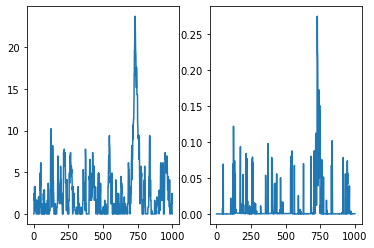

maximum steps, simulation is done ... 
elapsed_time: 52.494
Episode: 371 Exploration P: 0.0107 Total reward: -38.72441653844619 SOC: 0.5971 Cumulative_SOC_deviation: 3.4878 Fuel Consumption: 7.3340

maximum steps, simulation is done ... 
elapsed_time: 52.521
Episode: 372 Exploration P: 0.0106 Total reward: -41.27649492486208 SOC: 0.5918 Cumulative_SOC_deviation: 3.6272 Fuel Consumption: 8.6315

maximum steps, simulation is done ... 
elapsed_time: 52.479
Episode: 373 Exploration P: 0.0106 Total reward: -38.58144462323158 SOC: 0.5973 Cumulative_SOC_deviation: 3.2733 Fuel Consumption: 9.1219

maximum steps, simulation is done ... 
elapsed_time: 52.403
Episode: 374 Exploration P: 0.0106 Total reward: -42.6304058883204 SOC: 0.5976 Cumulative_SOC_deviation: 3.4511 Fuel Consumption: 11.5707

maximum steps, simulation is done ... 
elapsed_time: 51.929
Episode: 375 Exploration P: 0.0106 Total reward: -45.932963477379076 SOC: 0.5957 Cumulative_SOC_deviation: 3.6838 Fuel Consumption: 12.7789

max

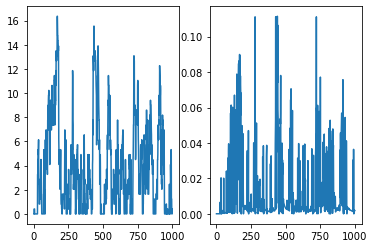

maximum steps, simulation is done ... 
elapsed_time: 52.434
Episode: 381 Exploration P: 0.0105 Total reward: -61.41484333659203 SOC: 0.5905 Cumulative_SOC_deviation: 5.8560 Fuel Consumption: 8.7105

maximum steps, simulation is done ... 
elapsed_time: 52.393
Episode: 382 Exploration P: 0.0105 Total reward: -79.94414290898014 SOC: 0.5953 Cumulative_SOC_deviation: 7.2944 Fuel Consumption: 14.2941

maximum steps, simulation is done ... 
elapsed_time: 52.617
Episode: 383 Exploration P: 0.0105 Total reward: -42.14081941789832 SOC: 0.5976 Cumulative_SOC_deviation: 4.0692 Fuel Consumption: 5.5177

maximum steps, simulation is done ... 
elapsed_time: 48.488
Episode: 384 Exploration P: 0.0105 Total reward: -745.3113895137043 SOC: 0.4624 Cumulative_SOC_deviation: 82.5742 Fuel Consumption: 2.1434

maximum steps, simulation is done ... 
elapsed_time: 47.315
Episode: 385 Exploration P: 0.0105 Total reward: -579.7302336534076 SOC: 0.4967 Cumulative_SOC_deviation: 64.1943 Fuel Consumption: 1.9819

ma

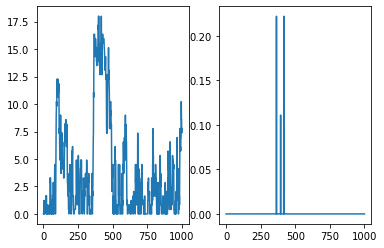

maximum steps, simulation is done ... 
elapsed_time: 45.173
Episode: 391 Exploration P: 0.0104 Total reward: -364.62737970272116 SOC: 0.4322 Cumulative_SOC_deviation: 40.1025 Fuel Consumption: 3.7049

maximum steps, simulation is done ... 
elapsed_time: 42.031
Episode: 392 Exploration P: 0.0104 Total reward: -456.1241031659303 SOC: 0.5103 Cumulative_SOC_deviation: 50.5967 Fuel Consumption: 0.7537

maximum steps, simulation is done ... 
elapsed_time: 42.467
Episode: 393 Exploration P: 0.0104 Total reward: -430.35158109000383 SOC: 0.4702 Cumulative_SOC_deviation: 47.5817 Fuel Consumption: 2.1167

maximum steps, simulation is done ... 
elapsed_time: 41.879
Episode: 394 Exploration P: 0.0104 Total reward: -809.5400082140825 SOC: 0.4465 Cumulative_SOC_deviation: 89.6496 Fuel Consumption: 2.6939

maximum steps, simulation is done ... 
elapsed_time: 42.129
Episode: 395 Exploration P: 0.0104 Total reward: -852.6199821825733 SOC: 0.4019 Cumulative_SOC_deviation: 94.4587 Fuel Consumption: 2.4916

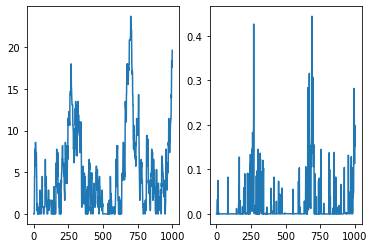

model is saved..

Trial 10

maximum steps, simulation is done ... 
elapsed_time: 6.134
Episode: 1 Exploration P: 1.0000 Total reward: -3677.303752600616 SOC: 1.0000 Cumulative_SOC_deviation: 357.0234 Fuel Consumption: 107.0694

maximum steps, simulation is done ... 
elapsed_time: 6.014
Episode: 2 Exploration P: 1.0000 Total reward: -3637.6073837283566 SOC: 1.0000 Cumulative_SOC_deviation: 353.8060 Fuel Consumption: 99.5474

maximum steps, simulation is done ... 
elapsed_time: 6.318
Episode: 3 Exploration P: 1.0000 Total reward: -3602.540118081268 SOC: 1.0000 Cumulative_SOC_deviation: 350.4241 Fuel Consumption: 98.2990

maximum steps, simulation is done ... 
elapsed_time: 6.366
Episode: 4 Exploration P: 1.0000 Total reward: -3620.123871939902 SOC: 1.0000 Cumulative_SOC_deviation: 348.4803 Fuel Consumption: 135.3204


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X mode

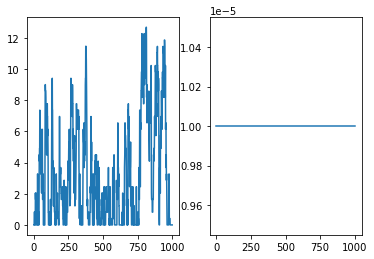

maximum steps, simulation is done ... 
elapsed_time: 40.520
Episode: 11 Exploration P: 0.8879 Total reward: -3516.834643247406 SOC: 1.0000 Cumulative_SOC_deviation: 342.3571 Fuel Consumption: 93.2637

maximum steps, simulation is done ... 
elapsed_time: 40.636
Episode: 12 Exploration P: 0.8705 Total reward: -3529.8810963199976 SOC: 1.0000 Cumulative_SOC_deviation: 344.2230 Fuel Consumption: 87.6506

maximum steps, simulation is done ... 
elapsed_time: 40.595
Episode: 13 Exploration P: 0.8534 Total reward: -3533.2932774510473 SOC: 1.0000 Cumulative_SOC_deviation: 344.0133 Fuel Consumption: 93.1605

maximum steps, simulation is done ... 
elapsed_time: 40.529
Episode: 14 Exploration P: 0.8367 Total reward: -3559.95139930962 SOC: 1.0000 Cumulative_SOC_deviation: 347.2146 Fuel Consumption: 87.8054

maximum steps, simulation is done ... 
elapsed_time: 40.641
Episode: 15 Exploration P: 0.8203 Total reward: -3550.517950573301 SOC: 1.0000 Cumulative_SOC_deviation: 346.5973 Fuel Consumption: 84.

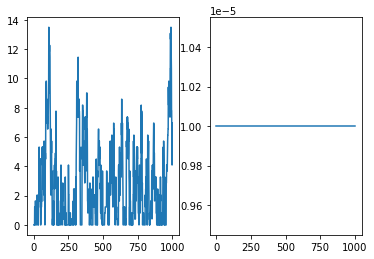

maximum steps, simulation is done ... 
elapsed_time: 41.341
Episode: 21 Exploration P: 0.7286 Total reward: -3506.000499445371 SOC: 1.0000 Cumulative_SOC_deviation: 343.0092 Fuel Consumption: 75.9086

maximum steps, simulation is done ... 
elapsed_time: 40.939
Episode: 22 Exploration P: 0.7144 Total reward: -3442.9183321352766 SOC: 1.0000 Cumulative_SOC_deviation: 336.7371 Fuel Consumption: 75.5475

maximum steps, simulation is done ... 
elapsed_time: 40.990
Episode: 23 Exploration P: 0.7004 Total reward: -3358.8844155295665 SOC: 1.0000 Cumulative_SOC_deviation: 328.5555 Fuel Consumption: 73.3291

maximum steps, simulation is done ... 
elapsed_time: 41.211
Episode: 24 Exploration P: 0.6867 Total reward: -3412.7774944018165 SOC: 1.0000 Cumulative_SOC_deviation: 333.6353 Fuel Consumption: 76.4245

maximum steps, simulation is done ... 
elapsed_time: 41.028
Episode: 25 Exploration P: 0.6733 Total reward: -3421.692366706162 SOC: 1.0000 Cumulative_SOC_deviation: 334.7476 Fuel Consumption: 7

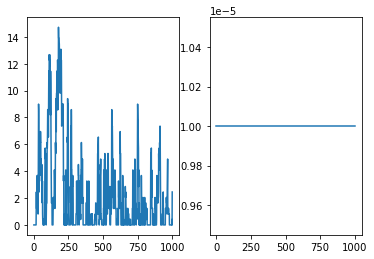

maximum steps, simulation is done ... 
elapsed_time: 41.078
Episode: 31 Exploration P: 0.5982 Total reward: -3183.4380624943747 SOC: 0.9994 Cumulative_SOC_deviation: 311.7136 Fuel Consumption: 66.3024

maximum steps, simulation is done ... 
elapsed_time: 41.085
Episode: 32 Exploration P: 0.5866 Total reward: -3260.8596605361545 SOC: 1.0000 Cumulative_SOC_deviation: 319.5269 Fuel Consumption: 65.5905

maximum steps, simulation is done ... 
elapsed_time: 41.253
Episode: 33 Exploration P: 0.5751 Total reward: -3149.989213488007 SOC: 1.0000 Cumulative_SOC_deviation: 308.1623 Fuel Consumption: 68.3660

maximum steps, simulation is done ... 
elapsed_time: 41.076
Episode: 34 Exploration P: 0.5639 Total reward: -3083.8600074408305 SOC: 0.9998 Cumulative_SOC_deviation: 301.3523 Fuel Consumption: 70.3368

maximum steps, simulation is done ... 
elapsed_time: 41.471
Episode: 35 Exploration P: 0.5530 Total reward: -2940.644377992461 SOC: 1.0000 Cumulative_SOC_deviation: 287.8841 Fuel Consumption: 6

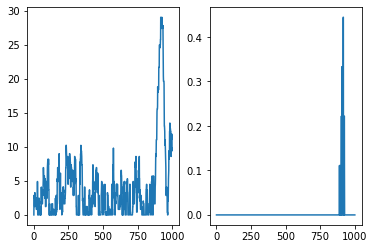

maximum steps, simulation is done ... 
elapsed_time: 41.491
Episode: 41 Exploration P: 0.4915 Total reward: -3090.029130193822 SOC: 1.0000 Cumulative_SOC_deviation: 303.1372 Fuel Consumption: 58.6567

maximum steps, simulation is done ... 
elapsed_time: 41.478
Episode: 42 Exploration P: 0.4820 Total reward: -3078.448560558409 SOC: 0.9994 Cumulative_SOC_deviation: 302.5199 Fuel Consumption: 53.2500

maximum steps, simulation is done ... 
elapsed_time: 41.448
Episode: 43 Exploration P: 0.4726 Total reward: -3064.7720843983666 SOC: 0.9986 Cumulative_SOC_deviation: 300.8055 Fuel Consumption: 56.7169

maximum steps, simulation is done ... 
elapsed_time: 41.544
Episode: 44 Exploration P: 0.4634 Total reward: -2841.1200967861246 SOC: 0.8972 Cumulative_SOC_deviation: 278.1019 Fuel Consumption: 60.1012

maximum steps, simulation is done ... 
elapsed_time: 41.153
Episode: 45 Exploration P: 0.4544 Total reward: -2928.0475103420545 SOC: 0.9994 Cumulative_SOC_deviation: 287.7408 Fuel Consumption: 5

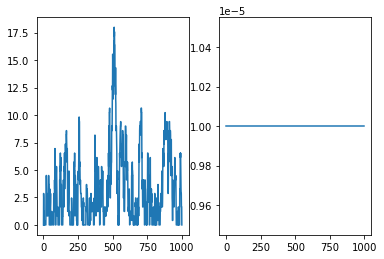

maximum steps, simulation is done ... 
elapsed_time: 41.393
Episode: 51 Exploration P: 0.4041 Total reward: -2743.15332799254 SOC: 1.0000 Cumulative_SOC_deviation: 269.5888 Fuel Consumption: 47.2654

maximum steps, simulation is done ... 
elapsed_time: 41.266
Episode: 52 Exploration P: 0.3963 Total reward: -2662.425511915263 SOC: 0.9995 Cumulative_SOC_deviation: 261.4200 Fuel Consumption: 48.2250

maximum steps, simulation is done ... 
elapsed_time: 41.467
Episode: 53 Exploration P: 0.3887 Total reward: -2455.933285077515 SOC: 0.9990 Cumulative_SOC_deviation: 241.4302 Fuel Consumption: 41.6317

maximum steps, simulation is done ... 
elapsed_time: 41.408
Episode: 54 Exploration P: 0.3812 Total reward: -2335.138392414712 SOC: 1.0000 Cumulative_SOC_deviation: 228.5190 Fuel Consumption: 49.9482

maximum steps, simulation is done ... 
elapsed_time: 41.244
Episode: 55 Exploration P: 0.3738 Total reward: -2645.5223808330084 SOC: 1.0000 Cumulative_SOC_deviation: 259.7720 Fuel Consumption: 47.8

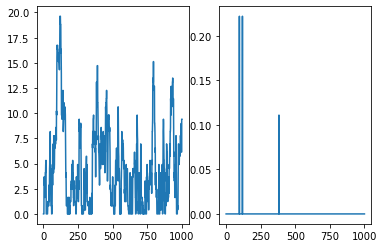

maximum steps, simulation is done ... 
elapsed_time: 41.669
Episode: 61 Exploration P: 0.3326 Total reward: -1902.1889159863945 SOC: 0.9206 Cumulative_SOC_deviation: 185.9453 Fuel Consumption: 42.7358

maximum steps, simulation is done ... 
elapsed_time: 41.588
Episode: 62 Exploration P: 0.3262 Total reward: -2419.866130320579 SOC: 0.9999 Cumulative_SOC_deviation: 237.9142 Fuel Consumption: 40.7237

maximum steps, simulation is done ... 
elapsed_time: 41.888
Episode: 63 Exploration P: 0.3200 Total reward: -2403.4474976247275 SOC: 0.9534 Cumulative_SOC_deviation: 236.3436 Fuel Consumption: 40.0118

maximum steps, simulation is done ... 
elapsed_time: 41.661
Episode: 64 Exploration P: 0.3138 Total reward: -2427.598140642459 SOC: 1.0000 Cumulative_SOC_deviation: 238.7318 Fuel Consumption: 40.2801

maximum steps, simulation is done ... 
elapsed_time: 41.563
Episode: 65 Exploration P: 0.3078 Total reward: -634.482239784905 SOC: 0.6429 Cumulative_SOC_deviation: 57.5299 Fuel Consumption: 59.1

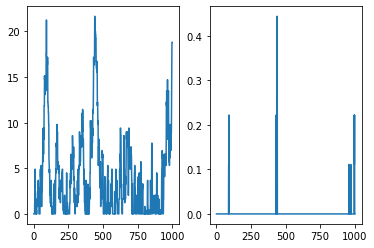

maximum steps, simulation is done ... 
elapsed_time: 41.738
Episode: 71 Exploration P: 0.2741 Total reward: -1920.5994224776464 SOC: 0.9033 Cumulative_SOC_deviation: 188.4777 Fuel Consumption: 35.8226

maximum steps, simulation is done ... 
elapsed_time: 41.484
Episode: 72 Exploration P: 0.2689 Total reward: -2095.6970147570855 SOC: 0.9695 Cumulative_SOC_deviation: 205.9410 Fuel Consumption: 36.2869

maximum steps, simulation is done ... 
elapsed_time: 41.590
Episode: 73 Exploration P: 0.2637 Total reward: -1946.8603376851884 SOC: 0.9578 Cumulative_SOC_deviation: 191.0790 Fuel Consumption: 36.0703

maximum steps, simulation is done ... 
elapsed_time: 41.502
Episode: 74 Exploration P: 0.2587 Total reward: -2136.6644147927072 SOC: 0.9665 Cumulative_SOC_deviation: 210.1131 Fuel Consumption: 35.5337

maximum steps, simulation is done ... 
elapsed_time: 41.484
Episode: 75 Exploration P: 0.2538 Total reward: -1952.4656163705602 SOC: 0.9684 Cumulative_SOC_deviation: 191.7149 Fuel Consumption:

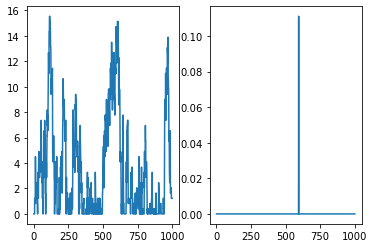

maximum steps, simulation is done ... 
elapsed_time: 41.653
Episode: 81 Exploration P: 0.2262 Total reward: -1468.7448936884552 SOC: 0.9060 Cumulative_SOC_deviation: 143.4676 Fuel Consumption: 34.0685

maximum steps, simulation is done ... 
elapsed_time: 41.393
Episode: 82 Exploration P: 0.2219 Total reward: -1098.6616723083064 SOC: 0.8051 Cumulative_SOC_deviation: 106.1529 Fuel Consumption: 37.1330

maximum steps, simulation is done ... 
elapsed_time: 41.700
Episode: 83 Exploration P: 0.2177 Total reward: -1380.5694239799047 SOC: 0.8504 Cumulative_SOC_deviation: 134.6945 Fuel Consumption: 33.6249

maximum steps, simulation is done ... 
elapsed_time: 41.652
Episode: 84 Exploration P: 0.2136 Total reward: -693.1024728101149 SOC: 0.7521 Cumulative_SOC_deviation: 65.9942 Fuel Consumption: 33.1605

maximum steps, simulation is done ... 
elapsed_time: 41.771
Episode: 85 Exploration P: 0.2095 Total reward: -1586.187160005 SOC: 0.9279 Cumulative_SOC_deviation: 155.2408 Fuel Consumption: 33.77

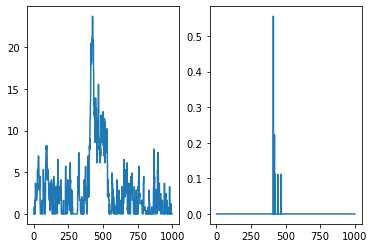

maximum steps, simulation is done ... 
elapsed_time: 41.766
Episode: 91 Exploration P: 0.1870 Total reward: -1269.5812420565424 SOC: 0.7892 Cumulative_SOC_deviation: 124.2023 Fuel Consumption: 27.5578

maximum steps, simulation is done ... 
elapsed_time: 41.704
Episode: 92 Exploration P: 0.1834 Total reward: -1290.347947000263 SOC: 0.8579 Cumulative_SOC_deviation: 126.1800 Fuel Consumption: 28.5483

maximum steps, simulation is done ... 
elapsed_time: 41.824
Episode: 93 Exploration P: 0.1800 Total reward: -649.1265129210336 SOC: 0.6768 Cumulative_SOC_deviation: 61.8711 Fuel Consumption: 30.4159

maximum steps, simulation is done ... 
elapsed_time: 41.539
Episode: 94 Exploration P: 0.1766 Total reward: -1276.7466664771482 SOC: 0.8137 Cumulative_SOC_deviation: 124.8890 Fuel Consumption: 27.8570

maximum steps, simulation is done ... 
elapsed_time: 41.762
Episode: 95 Exploration P: 0.1733 Total reward: -448.7848596925628 SOC: 0.7330 Cumulative_SOC_deviation: 41.6821 Fuel Consumption: 31.9

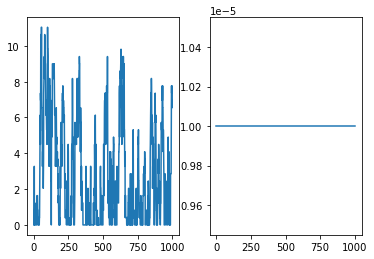

maximum steps, simulation is done ... 
elapsed_time: 41.664
Episode: 101 Exploration P: 0.1549 Total reward: -1036.1975916506199 SOC: 0.8267 Cumulative_SOC_deviation: 100.9455 Fuel Consumption: 26.7427

maximum steps, simulation is done ... 
elapsed_time: 41.889
Episode: 102 Exploration P: 0.1520 Total reward: -578.8003681956457 SOC: 0.7130 Cumulative_SOC_deviation: 55.4132 Fuel Consumption: 24.6687

maximum steps, simulation is done ... 
elapsed_time: 41.774
Episode: 103 Exploration P: 0.1492 Total reward: -817.7168783917244 SOC: 0.7592 Cumulative_SOC_deviation: 79.8166 Fuel Consumption: 19.5509

maximum steps, simulation is done ... 
elapsed_time: 41.743
Episode: 104 Exploration P: 0.1464 Total reward: -870.3982798387013 SOC: 0.8031 Cumulative_SOC_deviation: 84.7319 Fuel Consumption: 23.0797

maximum steps, simulation is done ... 
elapsed_time: 41.680
Episode: 105 Exploration P: 0.1437 Total reward: -905.6327569482664 SOC: 0.7959 Cumulative_SOC_deviation: 87.9540 Fuel Consumption: 26

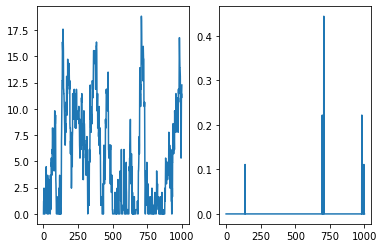

maximum steps, simulation is done ... 
elapsed_time: 41.817
Episode: 111 Exploration P: 0.1286 Total reward: -416.57594514577045 SOC: 0.6481 Cumulative_SOC_deviation: 39.8697 Fuel Consumption: 17.8794

maximum steps, simulation is done ... 
elapsed_time: 41.605
Episode: 112 Exploration P: 0.1262 Total reward: -316.5048859588408 SOC: 0.5608 Cumulative_SOC_deviation: 29.7645 Fuel Consumption: 18.8596

maximum steps, simulation is done ... 
elapsed_time: 41.565
Episode: 113 Exploration P: 0.1239 Total reward: -485.9820733789855 SOC: 0.6906 Cumulative_SOC_deviation: 46.7907 Fuel Consumption: 18.0754

maximum steps, simulation is done ... 
elapsed_time: 41.771
Episode: 114 Exploration P: 0.1217 Total reward: -408.25637461188984 SOC: 0.6460 Cumulative_SOC_deviation: 39.1161 Fuel Consumption: 17.0952

maximum steps, simulation is done ... 
elapsed_time: 41.792
Episode: 115 Exploration P: 0.1194 Total reward: -390.21618743572776 SOC: 0.6852 Cumulative_SOC_deviation: 37.3606 Fuel Consumption: 1

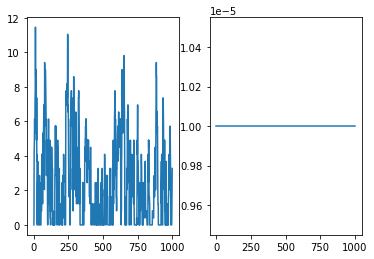

maximum steps, simulation is done ... 
elapsed_time: 41.725
Episode: 121 Exploration P: 0.1071 Total reward: -248.0522135553809 SOC: 0.6519 Cumulative_SOC_deviation: 23.6075 Fuel Consumption: 11.9774

maximum steps, simulation is done ... 
elapsed_time: 41.970
Episode: 122 Exploration P: 0.1051 Total reward: -597.8459357752931 SOC: 0.7180 Cumulative_SOC_deviation: 58.3372 Fuel Consumption: 14.4744

maximum steps, simulation is done ... 
elapsed_time: 41.854
Episode: 123 Exploration P: 0.1032 Total reward: -279.58256735158164 SOC: 0.4236 Cumulative_SOC_deviation: 26.2776 Fuel Consumption: 16.8063

maximum steps, simulation is done ... 
elapsed_time: 42.004
Episode: 124 Exploration P: 0.1014 Total reward: -183.29608909645168 SOC: 0.6169 Cumulative_SOC_deviation: 17.0019 Fuel Consumption: 13.2775

maximum steps, simulation is done ... 
elapsed_time: 41.580
Episode: 125 Exploration P: 0.0996 Total reward: -478.3679481920131 SOC: 0.6866 Cumulative_SOC_deviation: 46.5410 Fuel Consumption: 12

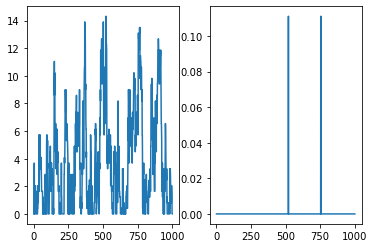

maximum steps, simulation is done ... 
elapsed_time: 41.927
Episode: 131 Exploration P: 0.0894 Total reward: -214.14450449792065 SOC: 0.6584 Cumulative_SOC_deviation: 20.1517 Fuel Consumption: 12.6274

maximum steps, simulation is done ... 
elapsed_time: 41.658
Episode: 132 Exploration P: 0.0879 Total reward: -446.38514487002834 SOC: 0.6835 Cumulative_SOC_deviation: 43.2870 Fuel Consumption: 13.5148

maximum steps, simulation is done ... 
elapsed_time: 41.517
Episode: 133 Exploration P: 0.0863 Total reward: -113.77338549297984 SOC: 0.6117 Cumulative_SOC_deviation: 10.0228 Fuel Consumption: 13.5458

maximum steps, simulation is done ... 
elapsed_time: 41.898
Episode: 134 Exploration P: 0.0848 Total reward: -117.64854733512215 SOC: 0.6039 Cumulative_SOC_deviation: 10.3865 Fuel Consumption: 13.7831

maximum steps, simulation is done ... 
elapsed_time: 41.977
Episode: 135 Exploration P: 0.0833 Total reward: -137.74716958219048 SOC: 0.6179 Cumulative_SOC_deviation: 12.4593 Fuel Consumption:

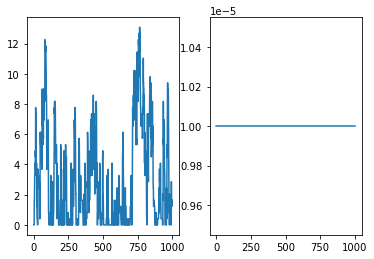

maximum steps, simulation is done ... 
elapsed_time: 42.008
Episode: 141 Exploration P: 0.0750 Total reward: -77.49816743040087 SOC: 0.6139 Cumulative_SOC_deviation: 6.7295 Fuel Consumption: 10.2027

battery power is 119652.31449560319(+) but condition is not avail
elapsed_time: 17.396
Episode: 142 Exploration P: 0.0745 Total reward: -1133.181994961865 SOC: 0.4811 Cumulative_SOC_deviation: 12.7124 Fuel Consumption: 7.2468

maximum steps, simulation is done ... 
elapsed_time: 43.428
Episode: 143 Exploration P: 0.0732 Total reward: -168.68759515358903 SOC: 0.5784 Cumulative_SOC_deviation: 15.6762 Fuel Consumption: 11.9258

maximum steps, simulation is done ... 
elapsed_time: 41.885
Episode: 144 Exploration P: 0.0720 Total reward: -425.2948952869017 SOC: 0.5525 Cumulative_SOC_deviation: 41.3833 Fuel Consumption: 11.4615

maximum steps, simulation is done ... 
elapsed_time: 41.848
Episode: 145 Exploration P: 0.0707 Total reward: -161.07987066448513 SOC: 0.6051 Cumulative_SOC_deviation: 15.

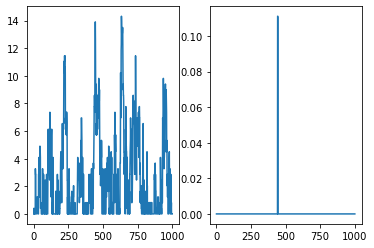

maximum steps, simulation is done ... 
elapsed_time: 41.901
Episode: 151 Exploration P: 0.0639 Total reward: -251.87625073553286 SOC: 0.5661 Cumulative_SOC_deviation: 23.8300 Fuel Consumption: 13.5767

maximum steps, simulation is done ... 
elapsed_time: 41.697
Episode: 152 Exploration P: 0.0628 Total reward: -197.07710020601476 SOC: 0.6344 Cumulative_SOC_deviation: 18.9351 Fuel Consumption: 7.7263

maximum steps, simulation is done ... 
elapsed_time: 41.817
Episode: 153 Exploration P: 0.0617 Total reward: -277.62190891147634 SOC: 0.5555 Cumulative_SOC_deviation: 26.9803 Fuel Consumption: 7.8192

maximum steps, simulation is done ... 
elapsed_time: 41.950
Episode: 154 Exploration P: 0.0607 Total reward: -120.81376943551226 SOC: 0.6214 Cumulative_SOC_deviation: 10.6897 Fuel Consumption: 13.9172

maximum steps, simulation is done ... 
elapsed_time: 41.929
Episode: 155 Exploration P: 0.0597 Total reward: -60.03060819037573 SOC: 0.5725 Cumulative_SOC_deviation: 5.0911 Fuel Consumption: 9.1

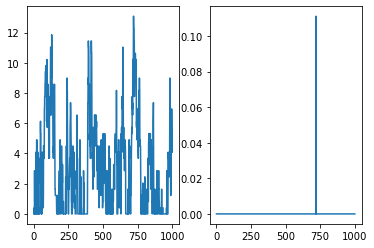

maximum steps, simulation is done ... 
elapsed_time: 42.048
Episode: 161 Exploration P: 0.0541 Total reward: -87.56466954358879 SOC: 0.5743 Cumulative_SOC_deviation: 7.8899 Fuel Consumption: 8.6653

maximum steps, simulation is done ... 
elapsed_time: 41.846
Episode: 162 Exploration P: 0.0532 Total reward: -614.0866438322569 SOC: 0.4950 Cumulative_SOC_deviation: 60.6402 Fuel Consumption: 7.6851

maximum steps, simulation is done ... 
elapsed_time: 41.947
Episode: 163 Exploration P: 0.0524 Total reward: -432.37008849849155 SOC: 0.5059 Cumulative_SOC_deviation: 42.6470 Fuel Consumption: 5.9000

maximum steps, simulation is done ... 
elapsed_time: 41.736
Episode: 164 Exploration P: 0.0515 Total reward: -1004.2630724445718 SOC: 0.4048 Cumulative_SOC_deviation: 99.4566 Fuel Consumption: 9.6971

maximum steps, simulation is done ... 
elapsed_time: 41.793
Episode: 165 Exploration P: 0.0507 Total reward: -144.9804217766155 SOC: 0.5768 Cumulative_SOC_deviation: 13.7450 Fuel Consumption: 7.5303


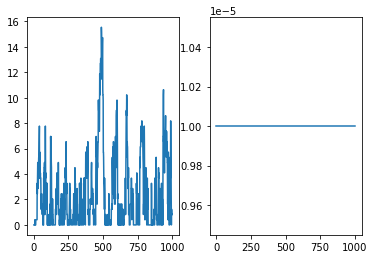

maximum steps, simulation is done ... 
elapsed_time: 41.891
Episode: 171 Exploration P: 0.0461 Total reward: -263.7636029426442 SOC: 0.5014 Cumulative_SOC_deviation: 25.6481 Fuel Consumption: 7.2827

maximum steps, simulation is done ... 
elapsed_time: 41.742
Episode: 172 Exploration P: 0.0454 Total reward: -153.68732922355184 SOC: 0.5667 Cumulative_SOC_deviation: 14.4857 Fuel Consumption: 8.8304

maximum steps, simulation is done ... 
elapsed_time: 41.654
Episode: 173 Exploration P: 0.0447 Total reward: -60.81337912905985 SOC: 0.6050 Cumulative_SOC_deviation: 5.2509 Fuel Consumption: 8.3041

maximum steps, simulation is done ... 
elapsed_time: 41.721
Episode: 174 Exploration P: 0.0440 Total reward: -578.3246990483763 SOC: 0.5204 Cumulative_SOC_deviation: 57.1166 Fuel Consumption: 7.1588

maximum steps, simulation is done ... 
elapsed_time: 41.690
Episode: 175 Exploration P: 0.0433 Total reward: -1274.2371970949057 SOC: 0.2836 Cumulative_SOC_deviation: 126.5118 Fuel Consumption: 9.1193

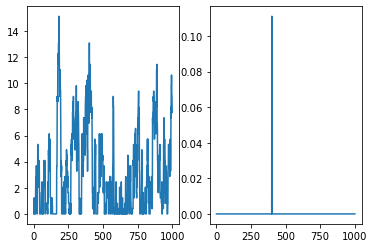

maximum steps, simulation is done ... 
elapsed_time: 41.944
Episode: 181 Exploration P: 0.0395 Total reward: -728.5859242360597 SOC: 0.4392 Cumulative_SOC_deviation: 72.3130 Fuel Consumption: 5.4563

maximum steps, simulation is done ... 
elapsed_time: 42.037
Episode: 182 Exploration P: 0.0390 Total reward: -257.6038491563546 SOC: 0.5528 Cumulative_SOC_deviation: 25.1921 Fuel Consumption: 5.6833

maximum steps, simulation is done ... 
elapsed_time: 42.070
Episode: 183 Exploration P: 0.0384 Total reward: -237.4418118024609 SOC: 0.5122 Cumulative_SOC_deviation: 23.1728 Fuel Consumption: 5.7143

maximum steps, simulation is done ... 
elapsed_time: 41.730
Episode: 184 Exploration P: 0.0378 Total reward: -215.86276655898217 SOC: 0.5536 Cumulative_SOC_deviation: 21.0840 Fuel Consumption: 5.0230

maximum steps, simulation is done ... 
elapsed_time: 42.148
Episode: 185 Exploration P: 0.0373 Total reward: -340.21940927774784 SOC: 0.5423 Cumulative_SOC_deviation: 33.6497 Fuel Consumption: 3.7229

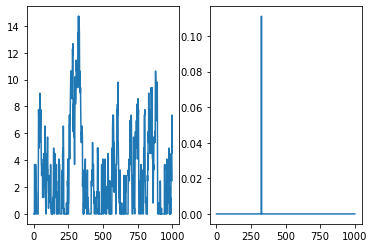

maximum steps, simulation is done ... 
elapsed_time: 42.188
Episode: 191 Exploration P: 0.0342 Total reward: -307.11603145766804 SOC: 0.5258 Cumulative_SOC_deviation: 30.1319 Fuel Consumption: 5.7968

maximum steps, simulation is done ... 
elapsed_time: 41.539
Episode: 192 Exploration P: 0.0337 Total reward: -462.2861823615494 SOC: 0.5086 Cumulative_SOC_deviation: 45.6778 Fuel Consumption: 5.5079

maximum steps, simulation is done ... 
elapsed_time: 41.680
Episode: 193 Exploration P: 0.0332 Total reward: -453.3835394600585 SOC: 0.5278 Cumulative_SOC_deviation: 44.8330 Fuel Consumption: 5.0539

maximum steps, simulation is done ... 
elapsed_time: 41.826
Episode: 194 Exploration P: 0.0328 Total reward: -255.17814014875947 SOC: 0.5741 Cumulative_SOC_deviation: 24.8896 Fuel Consumption: 6.2818

maximum steps, simulation is done ... 
elapsed_time: 41.936
Episode: 195 Exploration P: 0.0323 Total reward: -486.24790677441473 SOC: 0.5318 Cumulative_SOC_deviation: 47.9141 Fuel Consumption: 7.107

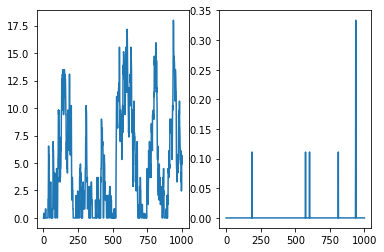

maximum steps, simulation is done ... 
elapsed_time: 41.753
Episode: 201 Exploration P: 0.0298 Total reward: -771.0048573571937 SOC: 0.4588 Cumulative_SOC_deviation: 76.6632 Fuel Consumption: 4.3729

maximum steps, simulation is done ... 
elapsed_time: 41.985
Episode: 202 Exploration P: 0.0294 Total reward: -247.39730663119119 SOC: 0.5349 Cumulative_SOC_deviation: 24.2818 Fuel Consumption: 4.5793

maximum steps, simulation is done ... 
elapsed_time: 41.926
Episode: 203 Exploration P: 0.0290 Total reward: -414.72970255183645 SOC: 0.5325 Cumulative_SOC_deviation: 41.0161 Fuel Consumption: 4.5690

maximum steps, simulation is done ... 
elapsed_time: 41.754
Episode: 204 Exploration P: 0.0286 Total reward: -3339.7833631998965 SOC: 0.1247 Cumulative_SOC_deviation: 332.0191 Fuel Consumption: 19.5922

maximum steps, simulation is done ... 
elapsed_time: 41.943
Episode: 205 Exploration P: 0.0283 Total reward: -887.6943259858793 SOC: 0.4479 Cumulative_SOC_deviation: 88.4106 Fuel Consumption: 3.5

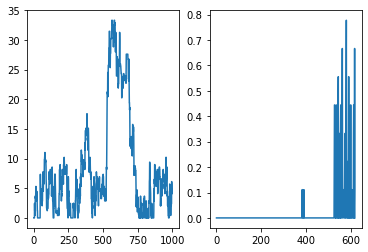

maximum steps, simulation is done ... 
elapsed_time: 42.073
Episode: 211 Exploration P: 0.0262 Total reward: -393.8333529202115 SOC: 0.4713 Cumulative_SOC_deviation: 38.8893 Fuel Consumption: 4.9404

maximum steps, simulation is done ... 
elapsed_time: 42.324
Episode: 212 Exploration P: 0.0259 Total reward: -1751.5097513872208 SOC: 0.3147 Cumulative_SOC_deviation: 174.5765 Fuel Consumption: 5.7453

maximum steps, simulation is done ... 
elapsed_time: 41.736
Episode: 213 Exploration P: 0.0256 Total reward: -381.3958448845771 SOC: 0.5245 Cumulative_SOC_deviation: 37.8622 Fuel Consumption: 2.7736

maximum steps, simulation is done ... 
elapsed_time: 41.841
Episode: 214 Exploration P: 0.0253 Total reward: -429.62444327659637 SOC: 0.5115 Cumulative_SOC_deviation: 42.5200 Fuel Consumption: 4.4245

maximum steps, simulation is done ... 
elapsed_time: 42.089
Episode: 215 Exploration P: 0.0250 Total reward: -564.0489641197601 SOC: 0.4824 Cumulative_SOC_deviation: 56.0759 Fuel Consumption: 3.289

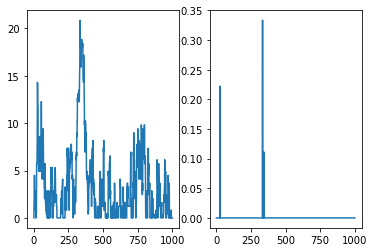

maximum steps, simulation is done ... 
elapsed_time: 42.171
Episode: 221 Exploration P: 0.0233 Total reward: -535.6463305746905 SOC: 0.5060 Cumulative_SOC_deviation: 53.1294 Fuel Consumption: 4.3523

maximum steps, simulation is done ... 
elapsed_time: 41.977
Episode: 222 Exploration P: 0.0230 Total reward: -1147.44163458441 SOC: 0.4432 Cumulative_SOC_deviation: 114.2522 Fuel Consumption: 4.9198

maximum steps, simulation is done ... 
elapsed_time: 41.777
Episode: 223 Exploration P: 0.0227 Total reward: -214.71873252019313 SOC: 0.5641 Cumulative_SOC_deviation: 21.0067 Fuel Consumption: 4.6515

maximum steps, simulation is done ... 
elapsed_time: 41.850
Episode: 224 Exploration P: 0.0225 Total reward: -446.46484338164385 SOC: 0.4822 Cumulative_SOC_deviation: 44.4558 Fuel Consumption: 1.9069

maximum steps, simulation is done ... 
elapsed_time: 41.939
Episode: 225 Exploration P: 0.0222 Total reward: -447.26853752772223 SOC: 0.4326 Cumulative_SOC_deviation: 44.2772 Fuel Consumption: 4.496

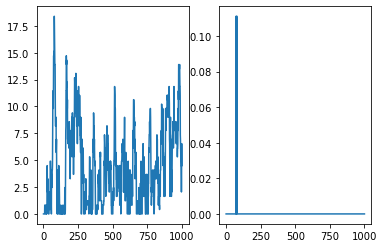

maximum steps, simulation is done ... 
elapsed_time: 41.957
Episode: 231 Exploration P: 0.0209 Total reward: -434.75166027404504 SOC: 0.5104 Cumulative_SOC_deviation: 42.9646 Fuel Consumption: 5.1055

maximum steps, simulation is done ... 
elapsed_time: 41.886
Episode: 232 Exploration P: 0.0206 Total reward: -685.225861365681 SOC: 0.5024 Cumulative_SOC_deviation: 68.1720 Fuel Consumption: 3.5062

maximum steps, simulation is done ... 
elapsed_time: 41.981
Episode: 233 Exploration P: 0.0204 Total reward: -706.117610131041 SOC: 0.4167 Cumulative_SOC_deviation: 70.1487 Fuel Consumption: 4.6309

maximum steps, simulation is done ... 
elapsed_time: 41.869
Episode: 234 Exploration P: 0.0202 Total reward: -454.73573814361265 SOC: 0.4795 Cumulative_SOC_deviation: 45.1095 Fuel Consumption: 3.6404

maximum steps, simulation is done ... 
elapsed_time: 41.878
Episode: 235 Exploration P: 0.0200 Total reward: -1162.2047817801258 SOC: 0.3986 Cumulative_SOC_deviation: 116.0329 Fuel Consumption: 1.8759

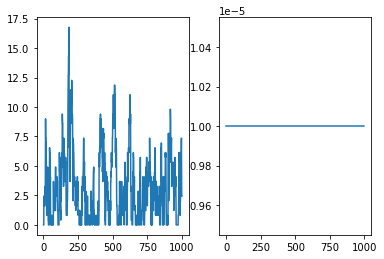

maximum steps, simulation is done ... 
elapsed_time: 41.836
Episode: 241 Exploration P: 0.0189 Total reward: -726.7217459680288 SOC: 0.4767 Cumulative_SOC_deviation: 72.4206 Fuel Consumption: 2.5157

maximum steps, simulation is done ... 
elapsed_time: 42.114
Episode: 242 Exploration P: 0.0187 Total reward: -604.9738934096216 SOC: 0.4934 Cumulative_SOC_deviation: 60.1282 Fuel Consumption: 3.6919

maximum steps, simulation is done ... 
elapsed_time: 41.896
Episode: 243 Exploration P: 0.0185 Total reward: -318.85767832082115 SOC: 0.5307 Cumulative_SOC_deviation: 31.6084 Fuel Consumption: 2.7736

maximum steps, simulation is done ... 
elapsed_time: 42.156
Episode: 244 Exploration P: 0.0184 Total reward: -856.049794767499 SOC: 0.4317 Cumulative_SOC_deviation: 85.2667 Fuel Consumption: 3.3824

maximum steps, simulation is done ... 
elapsed_time: 42.258
Episode: 245 Exploration P: 0.0182 Total reward: -430.05010165106347 SOC: 0.5013 Cumulative_SOC_deviation: 42.5935 Fuel Consumption: 4.1150


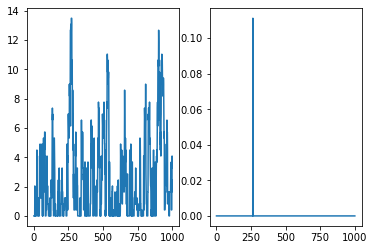

maximum steps, simulation is done ... 
elapsed_time: 42.047
Episode: 251 Exploration P: 0.0173 Total reward: -388.72355767840736 SOC: 0.5024 Cumulative_SOC_deviation: 38.7260 Fuel Consumption: 1.4632

maximum steps, simulation is done ... 
elapsed_time: 42.028
Episode: 252 Exploration P: 0.0171 Total reward: -2845.08160651221 SOC: 0.2146 Cumulative_SOC_deviation: 283.8635 Fuel Consumption: 6.4469

maximum steps, simulation is done ... 
elapsed_time: 41.955
Episode: 253 Exploration P: 0.0170 Total reward: -585.5691784129134 SOC: 0.4872 Cumulative_SOC_deviation: 58.2837 Fuel Consumption: 2.7324

maximum steps, simulation is done ... 
elapsed_time: 41.599
Episode: 254 Exploration P: 0.0169 Total reward: -502.6203090332465 SOC: 0.4760 Cumulative_SOC_deviation: 50.0208 Fuel Consumption: 2.4125

maximum steps, simulation is done ... 
elapsed_time: 42.020
Episode: 255 Exploration P: 0.0167 Total reward: -245.8897679009312 SOC: 0.5483 Cumulative_SOC_deviation: 24.3673 Fuel Consumption: 2.2164


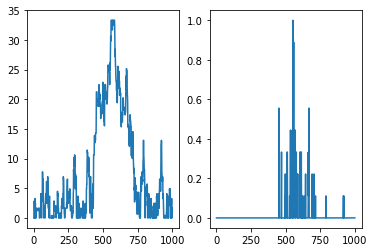

maximum steps, simulation is done ... 
elapsed_time: 42.452
Episode: 261 Exploration P: 0.0160 Total reward: -307.02521195510474 SOC: 0.5962 Cumulative_SOC_deviation: 30.0449 Fuel Consumption: 6.5767

maximum steps, simulation is done ... 
elapsed_time: 41.927
Episode: 262 Exploration P: 0.0158 Total reward: -393.1147631028242 SOC: 0.6053 Cumulative_SOC_deviation: 37.5735 Fuel Consumption: 17.3802

maximum steps, simulation is done ... 
elapsed_time: 41.835
Episode: 263 Exploration P: 0.0157 Total reward: -124.6281802655822 SOC: 0.6080 Cumulative_SOC_deviation: 10.7976 Fuel Consumption: 16.6519

maximum steps, simulation is done ... 
elapsed_time: 42.094
Episode: 264 Exploration P: 0.0156 Total reward: -74.28382638093865 SOC: 0.5986 Cumulative_SOC_deviation: 6.3518 Fuel Consumption: 10.7658

maximum steps, simulation is done ... 
elapsed_time: 42.140
Episode: 265 Exploration P: 0.0155 Total reward: -43.1419065463508 SOC: 0.5973 Cumulative_SOC_deviation: 2.2608 Fuel Consumption: 20.5342

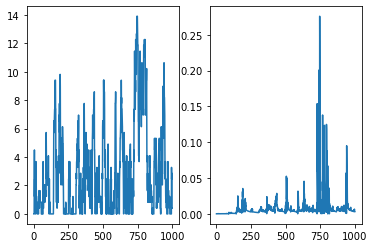

maximum steps, simulation is done ... 
elapsed_time: 42.008
Episode: 271 Exploration P: 0.0149 Total reward: -61.16895022475058 SOC: 0.5911 Cumulative_SOC_deviation: 5.2457 Fuel Consumption: 8.7119

maximum steps, simulation is done ... 
elapsed_time: 41.978
Episode: 272 Exploration P: 0.0148 Total reward: -134.70039575207758 SOC: 0.5960 Cumulative_SOC_deviation: 8.3968 Fuel Consumption: 50.7323

maximum steps, simulation is done ... 
elapsed_time: 42.037
Episode: 273 Exploration P: 0.0147 Total reward: -59.75603105747992 SOC: 0.5957 Cumulative_SOC_deviation: 5.1790 Fuel Consumption: 7.9660

maximum steps, simulation is done ... 
elapsed_time: 42.053
Episode: 274 Exploration P: 0.0146 Total reward: -85.97865812575273 SOC: 0.5955 Cumulative_SOC_deviation: 6.8901 Fuel Consumption: 17.0772

maximum steps, simulation is done ... 
elapsed_time: 41.994
Episode: 275 Exploration P: 0.0145 Total reward: -72.28756684967999 SOC: 0.5947 Cumulative_SOC_deviation: 6.1169 Fuel Consumption: 11.1182

m

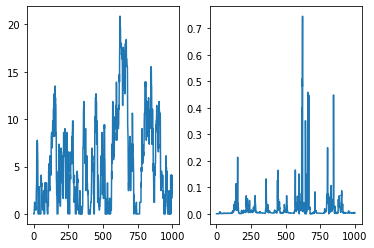

maximum steps, simulation is done ... 
elapsed_time: 42.133
Episode: 281 Exploration P: 0.0140 Total reward: -41.55865019028899 SOC: 0.5981 Cumulative_SOC_deviation: 3.2969 Fuel Consumption: 8.5899

maximum steps, simulation is done ... 
elapsed_time: 41.984
Episode: 282 Exploration P: 0.0139 Total reward: -85.19743305163806 SOC: 0.5953 Cumulative_SOC_deviation: 7.7822 Fuel Consumption: 7.3758

maximum steps, simulation is done ... 
elapsed_time: 42.022
Episode: 283 Exploration P: 0.0138 Total reward: -60.18202388443113 SOC: 0.5904 Cumulative_SOC_deviation: 5.0048 Fuel Consumption: 10.1335

maximum steps, simulation is done ... 
elapsed_time: 42.036
Episode: 284 Exploration P: 0.0138 Total reward: -53.71418001205571 SOC: 0.5996 Cumulative_SOC_deviation: 4.0481 Fuel Consumption: 13.2330

maximum steps, simulation is done ... 
elapsed_time: 41.893
Episode: 285 Exploration P: 0.0137 Total reward: -71.5394524251684 SOC: 0.6058 Cumulative_SOC_deviation: 5.6078 Fuel Consumption: 15.4614

max

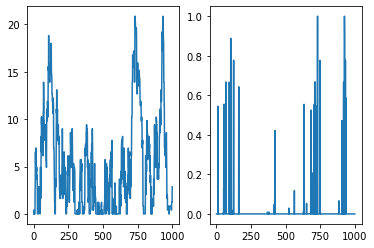

maximum steps, simulation is done ... 
elapsed_time: 42.212
Episode: 291 Exploration P: 0.0133 Total reward: -42.2801688879565 SOC: 0.5879 Cumulative_SOC_deviation: 3.7589 Fuel Consumption: 4.6909

maximum steps, simulation is done ... 
elapsed_time: 41.944
Episode: 292 Exploration P: 0.0132 Total reward: -315.8027842013675 SOC: 0.5487 Cumulative_SOC_deviation: 31.1900 Fuel Consumption: 3.9027

maximum steps, simulation is done ... 
elapsed_time: 42.043
Episode: 293 Exploration P: 0.0131 Total reward: -304.9059603418727 SOC: 0.5379 Cumulative_SOC_deviation: 29.7850 Fuel Consumption: 7.0560

maximum steps, simulation is done ... 
elapsed_time: 41.901
Episode: 294 Exploration P: 0.0131 Total reward: -409.6017105202206 SOC: 0.5330 Cumulative_SOC_deviation: 40.4011 Fuel Consumption: 5.5910

maximum steps, simulation is done ... 
elapsed_time: 41.768
Episode: 295 Exploration P: 0.0130 Total reward: -389.8849158809755 SOC: 0.5366 Cumulative_SOC_deviation: 38.7100 Fuel Consumption: 2.7852

ma

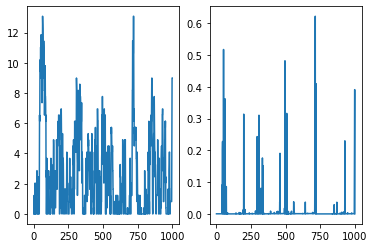

maximum steps, simulation is done ... 
elapsed_time: 41.972
Episode: 301 Exploration P: 0.0127 Total reward: -63.19575971449867 SOC: 0.5974 Cumulative_SOC_deviation: 4.4450 Fuel Consumption: 18.7463

maximum steps, simulation is done ... 
elapsed_time: 41.951
Episode: 302 Exploration P: 0.0126 Total reward: -60.517178776051594 SOC: 0.5926 Cumulative_SOC_deviation: 5.3976 Fuel Consumption: 6.5409

maximum steps, simulation is done ... 
elapsed_time: 41.885
Episode: 303 Exploration P: 0.0126 Total reward: -68.07549111454121 SOC: 0.5910 Cumulative_SOC_deviation: 6.0676 Fuel Consumption: 7.3994

maximum steps, simulation is done ... 
elapsed_time: 41.752
Episode: 304 Exploration P: 0.0125 Total reward: -57.58080085182985 SOC: 0.5984 Cumulative_SOC_deviation: 3.9217 Fuel Consumption: 18.3634

maximum steps, simulation is done ... 
elapsed_time: 41.963
Episode: 305 Exploration P: 0.0125 Total reward: -66.95432847464076 SOC: 0.5850 Cumulative_SOC_deviation: 6.0594 Fuel Consumption: 6.3602

ma

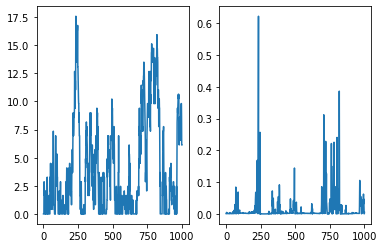

maximum steps, simulation is done ... 
elapsed_time: 41.889
Episode: 311 Exploration P: 0.0122 Total reward: -13.815673740996655 SOC: 0.5982 Cumulative_SOC_deviation: 0.9777 Fuel Consumption: 4.0384

maximum steps, simulation is done ... 
elapsed_time: 41.818
Episode: 312 Exploration P: 0.0121 Total reward: -64.61225853188087 SOC: 0.5985 Cumulative_SOC_deviation: 3.7156 Fuel Consumption: 27.4558

maximum steps, simulation is done ... 
elapsed_time: 41.890
Episode: 313 Exploration P: 0.0121 Total reward: -22.091560045818603 SOC: 0.5976 Cumulative_SOC_deviation: 1.4094 Fuel Consumption: 7.9980

maximum steps, simulation is done ... 
elapsed_time: 41.741
Episode: 314 Exploration P: 0.0121 Total reward: -30.468732198179143 SOC: 0.5999 Cumulative_SOC_deviation: 2.0837 Fuel Consumption: 9.6320

maximum steps, simulation is done ... 
elapsed_time: 41.731
Episode: 315 Exploration P: 0.0120 Total reward: -29.73338394019761 SOC: 0.6023 Cumulative_SOC_deviation: 2.1978 Fuel Consumption: 7.7552

m

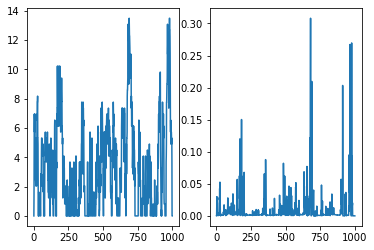

maximum steps, simulation is done ... 
elapsed_time: 41.833
Episode: 321 Exploration P: 0.0118 Total reward: -41.68025456794882 SOC: 0.5935 Cumulative_SOC_deviation: 3.3803 Fuel Consumption: 7.8772

maximum steps, simulation is done ... 
elapsed_time: 41.943
Episode: 322 Exploration P: 0.0118 Total reward: -49.78705748358589 SOC: 0.5958 Cumulative_SOC_deviation: 4.2819 Fuel Consumption: 6.9686

maximum steps, simulation is done ... 
elapsed_time: 41.934
Episode: 323 Exploration P: 0.0117 Total reward: -109.10582273226908 SOC: 0.5936 Cumulative_SOC_deviation: 6.6851 Fuel Consumption: 42.2545

maximum steps, simulation is done ... 
elapsed_time: 41.733
Episode: 324 Exploration P: 0.0117 Total reward: -79.86015350660519 SOC: 0.5954 Cumulative_SOC_deviation: 7.2086 Fuel Consumption: 7.7740

maximum steps, simulation is done ... 
elapsed_time: 41.922
Episode: 325 Exploration P: 0.0117 Total reward: -84.92240393459157 SOC: 0.5928 Cumulative_SOC_deviation: 5.2497 Fuel Consumption: 32.4253

ma

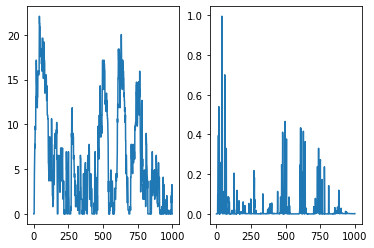

maximum steps, simulation is done ... 
elapsed_time: 41.883
Episode: 331 Exploration P: 0.0115 Total reward: -77.9611656802262 SOC: 0.6063 Cumulative_SOC_deviation: 5.5301 Fuel Consumption: 22.6599

maximum steps, simulation is done ... 
elapsed_time: 41.795
Episode: 332 Exploration P: 0.0114 Total reward: -40.48480070738759 SOC: 0.5992 Cumulative_SOC_deviation: 2.9934 Fuel Consumption: 10.5504

maximum steps, simulation is done ... 
elapsed_time: 41.878
Episode: 333 Exploration P: 0.0114 Total reward: -57.90278247287172 SOC: 0.5960 Cumulative_SOC_deviation: 4.4748 Fuel Consumption: 13.1544

maximum steps, simulation is done ... 
elapsed_time: 41.814
Episode: 334 Exploration P: 0.0114 Total reward: -231.16072375139697 SOC: 0.5720 Cumulative_SOC_deviation: 22.1648 Fuel Consumption: 9.5128

maximum steps, simulation is done ... 
elapsed_time: 41.856
Episode: 335 Exploration P: 0.0114 Total reward: -233.59870419196585 SOC: 0.5780 Cumulative_SOC_deviation: 21.4999 Fuel Consumption: 18.5996

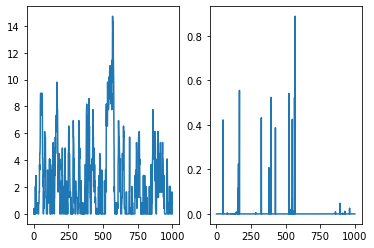

maximum steps, simulation is done ... 
elapsed_time: 41.728
Episode: 341 Exploration P: 0.0112 Total reward: -40.735205424717904 SOC: 0.6013 Cumulative_SOC_deviation: 3.2560 Fuel Consumption: 8.1752

maximum steps, simulation is done ... 
elapsed_time: 41.965
Episode: 342 Exploration P: 0.0112 Total reward: -29.907244509019524 SOC: 0.5920 Cumulative_SOC_deviation: 2.3082 Fuel Consumption: 6.8252

maximum steps, simulation is done ... 
elapsed_time: 42.096
Episode: 343 Exploration P: 0.0112 Total reward: -138.00742503604093 SOC: 0.5956 Cumulative_SOC_deviation: 12.8788 Fuel Consumption: 9.2193

maximum steps, simulation is done ... 
elapsed_time: 42.001
Episode: 344 Exploration P: 0.0111 Total reward: -90.20025014111675 SOC: 0.6043 Cumulative_SOC_deviation: 8.0998 Fuel Consumption: 9.2019

maximum steps, simulation is done ... 
elapsed_time: 42.072
Episode: 345 Exploration P: 0.0111 Total reward: -26.31270986563762 SOC: 0.5996 Cumulative_SOC_deviation: 1.7819 Fuel Consumption: 8.4936

m

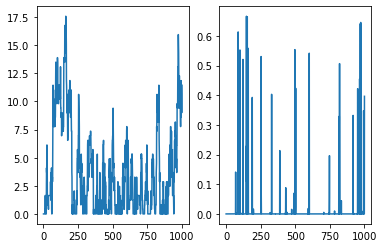

maximum steps, simulation is done ... 
elapsed_time: 41.847
Episode: 351 Exploration P: 0.0110 Total reward: -104.64547740463964 SOC: 0.5906 Cumulative_SOC_deviation: 9.4193 Fuel Consumption: 10.4522

maximum steps, simulation is done ... 
elapsed_time: 41.782
Episode: 352 Exploration P: 0.0110 Total reward: -117.48404538456482 SOC: 0.5941 Cumulative_SOC_deviation: 9.9142 Fuel Consumption: 18.3420

maximum steps, simulation is done ... 
elapsed_time: 41.709
Episode: 353 Exploration P: 0.0109 Total reward: -117.81141979941717 SOC: 0.5943 Cumulative_SOC_deviation: 9.5223 Fuel Consumption: 22.5887

maximum steps, simulation is done ... 
elapsed_time: 41.841
Episode: 354 Exploration P: 0.0109 Total reward: -85.43375710355116 SOC: 0.6045 Cumulative_SOC_deviation: 6.4486 Fuel Consumption: 20.9478

maximum steps, simulation is done ... 
elapsed_time: 41.638
Episode: 355 Exploration P: 0.0109 Total reward: -28.98636058409803 SOC: 0.5963 Cumulative_SOC_deviation: 1.9867 Fuel Consumption: 9.1194

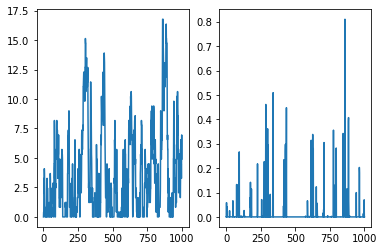

maximum steps, simulation is done ... 
elapsed_time: 42.144
Episode: 361 Exploration P: 0.0108 Total reward: -20.812401330004487 SOC: 0.6011 Cumulative_SOC_deviation: 1.1056 Fuel Consumption: 9.7559

maximum steps, simulation is done ... 
elapsed_time: 42.159
Episode: 362 Exploration P: 0.0108 Total reward: -33.6586073436006 SOC: 0.6020 Cumulative_SOC_deviation: 2.4631 Fuel Consumption: 9.0279

maximum steps, simulation is done ... 
elapsed_time: 41.728
Episode: 363 Exploration P: 0.0108 Total reward: -53.06069680913726 SOC: 0.5935 Cumulative_SOC_deviation: 4.4223 Fuel Consumption: 8.8372

maximum steps, simulation is done ... 
elapsed_time: 41.662
Episode: 364 Exploration P: 0.0108 Total reward: -80.82401206032155 SOC: 0.5986 Cumulative_SOC_deviation: 5.2846 Fuel Consumption: 27.9784

maximum steps, simulation is done ... 
elapsed_time: 41.636
Episode: 365 Exploration P: 0.0107 Total reward: -146.14047585888153 SOC: 0.5872 Cumulative_SOC_deviation: 13.1623 Fuel Consumption: 14.5173

m

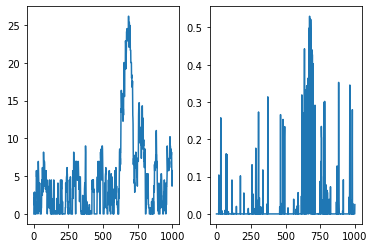

maximum steps, simulation is done ... 
elapsed_time: 41.779
Episode: 371 Exploration P: 0.0107 Total reward: -37.830751409222074 SOC: 0.5959 Cumulative_SOC_deviation: 3.0089 Fuel Consumption: 7.7416

maximum steps, simulation is done ... 
elapsed_time: 42.037
Episode: 372 Exploration P: 0.0106 Total reward: -44.32770982728099 SOC: 0.6048 Cumulative_SOC_deviation: 2.9521 Fuel Consumption: 14.8065

maximum steps, simulation is done ... 
elapsed_time: 41.638
Episode: 373 Exploration P: 0.0106 Total reward: -102.02162332477361 SOC: 0.5894 Cumulative_SOC_deviation: 6.9492 Fuel Consumption: 32.5300

maximum steps, simulation is done ... 
elapsed_time: 41.816
Episode: 374 Exploration P: 0.0106 Total reward: -73.39885154821117 SOC: 0.5889 Cumulative_SOC_deviation: 6.6427 Fuel Consumption: 6.9718

maximum steps, simulation is done ... 
elapsed_time: 41.851
Episode: 375 Exploration P: 0.0106 Total reward: -88.15253883508024 SOC: 0.5877 Cumulative_SOC_deviation: 8.0099 Fuel Consumption: 8.0537

m

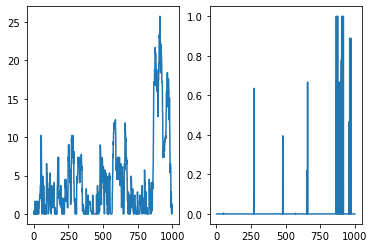

maximum steps, simulation is done ... 
elapsed_time: 41.823
Episode: 381 Exploration P: 0.0105 Total reward: -127.85123982726299 SOC: 0.5899 Cumulative_SOC_deviation: 12.0394 Fuel Consumption: 7.4572

maximum steps, simulation is done ... 
elapsed_time: 41.654
Episode: 382 Exploration P: 0.0105 Total reward: -69.38946923826263 SOC: 0.5841 Cumulative_SOC_deviation: 6.4037 Fuel Consumption: 5.3529

maximum steps, simulation is done ... 
elapsed_time: 42.116
Episode: 383 Exploration P: 0.0105 Total reward: -49.05745290375118 SOC: 0.5945 Cumulative_SOC_deviation: 4.3141 Fuel Consumption: 5.9168

maximum steps, simulation is done ... 
elapsed_time: 41.794
Episode: 384 Exploration P: 0.0105 Total reward: -42.88911525895542 SOC: 0.5960 Cumulative_SOC_deviation: 3.6174 Fuel Consumption: 6.7146

maximum steps, simulation is done ... 
elapsed_time: 41.869
Episode: 385 Exploration P: 0.0105 Total reward: -105.80630157812145 SOC: 0.6057 Cumulative_SOC_deviation: 5.9459 Fuel Consumption: 46.3468

m

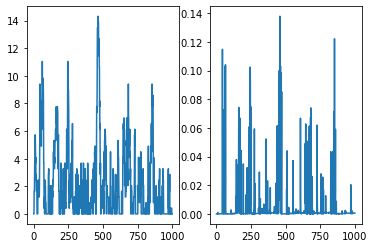

maximum steps, simulation is done ... 
elapsed_time: 41.963
Episode: 391 Exploration P: 0.0104 Total reward: -44.794865944987116 SOC: 0.5973 Cumulative_SOC_deviation: 3.6713 Fuel Consumption: 8.0818

maximum steps, simulation is done ... 
elapsed_time: 41.825
Episode: 392 Exploration P: 0.0104 Total reward: -24.348645442406323 SOC: 0.5965 Cumulative_SOC_deviation: 1.6619 Fuel Consumption: 7.7297

maximum steps, simulation is done ... 
elapsed_time: 42.019
Episode: 393 Exploration P: 0.0104 Total reward: -34.059125735445434 SOC: 0.5994 Cumulative_SOC_deviation: 1.8249 Fuel Consumption: 15.8103

maximum steps, simulation is done ... 
elapsed_time: 41.927
Episode: 394 Exploration P: 0.0104 Total reward: -28.693583220841596 SOC: 0.5988 Cumulative_SOC_deviation: 1.3091 Fuel Consumption: 15.6027

maximum steps, simulation is done ... 
elapsed_time: 41.831
Episode: 395 Exploration P: 0.0104 Total reward: -22.23640686937637 SOC: 0.5981 Cumulative_SOC_deviation: 1.4301 Fuel Consumption: 7.9356


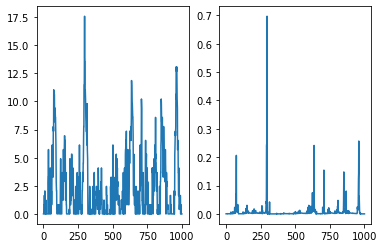

model is saved..


In [15]:
# print(env.version)

# num_trials = 1
reward_factors = [7, 8, 9, 10]
results_dict = {} 

for reward_factor in reward_factors: 
    print("")
    print("Trial {}".format(reward_factor))
    print("")
    
    actor_model, critic_model, target_actor, target_critic, buffer = initialization()
    
    eps = MAX_EPSILON 
    steps = 0
    
    episode_rewards = [] 
    episode_SOCs = [] 
    episode_FCs = [] 
    episode_test_history = [] 
    episode_num_test = [] 
    for ep in range(total_episodes): 
        
        driving_cycle = driver.get_cycle() 
        env = initialization_env(driving_cycle, reward_factor)
        
        start = time.time() 
        state = env.reset() 
        episodic_reward = 0 

        while True: 
            tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
            action = policy_epsilon_greedy(tf_state, eps)
    #         print(action)
            next_state, reward, done = env.step(action)
            if done: 
                next_state = [0] * num_states 

            buffer.record((state, action, reward, next_state))
            episodic_reward += reward 

            if steps > DELAY_TRAINING: 
                buffer.learn() 
                update_target(tau)
                eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-DECAY_RATE * (steps
                                                                        -DELAY_TRAINING))

            steps += 1

            if done: 
                break 

            state = next_state 

        elapsed_time = time.time() - start 
        print("elapsed_time: {:.3f}".format(elapsed_time))
        episode_rewards.append(episodic_reward) 
        episode_SOCs.append(env.SOC)
        episode_FCs.append(env.fuel_consumption) 

    #     print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
        SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
        print(
              'Episode: {}'.format(ep + 1),
              "Exploration P: {:.4f}".format(eps),
              'Total reward: {}'.format(episodic_reward), 
              "SOC: {:.4f}".format(env.SOC), 
              "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
              "Fuel Consumption: {:.4f}".format(env.fuel_consumption), 
        )
        print("")
        
        if (ep + 1) % 10 == 0: 
            history = test_agent(actor_model, reward_factor)
            episode_test_history.append(history) 
            episode_num_test.append(ep + 1)
            
#         if (ep + 1) % 200 == 0:             
    root = "DDPG_MDP_reward_factor{}".format(reward_factor)
    save_weights(actor_model, critic_model, target_actor, target_critic, root)
            
    
    results_dict[reward_factor] = {
        "rewards": episode_rewards, 
        "SOCs": episode_SOCs, 
        "FCs": episode_FCs, 
        "test_history": episode_test_history, 
        "test_episode_num": episode_num_test, 
    }

In [16]:
with open("DDPG_MDP_7to10.pkl", "wb") as f: 
    pickle.dump(results_dict, f, pickle.HIGHEST_PROTOCOL)

In [17]:
# results_dict